In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential

from keras.regularizers import l2, l1, l1_l2


import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


import pickle


2025-03-30 22:02:45.191550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 22:02:45.208093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8463] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 22:02:45.213066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import optree
import keras
print( '\n\n')
print(' optree version:  %s' % str(optree.__version__))
print(' keras version:  %s' % str(keras.__version__))
print('\n\n')




 optree version:  0.13.0
 keras version:  3.4.1





In [3]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.17.0





In [4]:
from keras.layers import Activation

beta = 4

def custom_activation(x):
    return 0.5 * x * (1 + K.tanh( beta * 0.79788 * (x + 0.044715 * x * x * x)))

## Set model and resolution parameters

In [5]:
##====================

ndim = 6

n_boot_samples = 200

first_boot_sample_index = 100

random_seed = 1

resolution_sf = 1.0

output_dir = 'output-run-nn-study-nd-v1c-ndim%d-res-sf-%.2f' % (ndim, resolution_sf)


##-------------

if ndim == 6 :

    mc_mu = [ 1.,  0.,  -0.5,   0.5, -1., 0.3 ]

    mc_rho = [ 
                  [0.0, 0.0, -0.3, 0.2, 0.1],  #0
                  [0.1, 0.3, -0.2, 0.0 ],   #1
                  [0.3, -0.2, 0.1   ],  #2
                  [0.0, 0.1],  #3
                  [0.7],  #4
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8, 1.2, 1.4 ]


    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7, -0.8, 0.1 ]

    true_rho  = [ [0.0, 0.1, -0.2, 0.2, 0.0 ], #0
                  [0.0, 0.2, -0.1, 0.0],  #1
                  [0.4, -0.3, 0.0   ],  #2
                  [0.0, 0.2],  #3
                  [0.5],  #4
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6, 1.0, 1.1 ]
    
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3, 0.4, 0.4  ]
    
    

##-------------

if ndim == 4 :
    
    mc_mu = [ 1.,  0.,  -0.5,   0.5 ]

    mc_rho = [ 
                  [0.3, -0.2, 0.1   ],  #0
                  [0.0, 0.1],  #1
                  [0.7],  #2
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8 ]
    
    
    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]

    true_rho  = [ 
                  [0.4, -0.3, 0.0   ],  #0
                  [0.0, 0.2],  #1
                  [0.5],  #2
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6 ]
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3  ]
    
    

##-------------

if ndim == 2 :
    
    mc_mu = [ 0.0, 1.0 ]

    mc_rho = [ [-0.6] ]

    mc_sig = [ 1.0, 1.5 ]


    ##-------------

    true_mu = [ 0.2, 0.8 ]

    true_rho  = [ [-0.6] ]

    true_sig = [ 0.9, 1.3 ]
    
    
    resolution = [ 0.5, 0.8  ]

    
##-------------

if ndim == 1 :

    ##-------------

    mc_mu = [ 0.0 ]

    mc_rho = [ [0.0] ]

    mc_sig = [ 1.0 ]


    ##-------------


    true_mu = [ 0.2 ]

    true_rho  = [ [0.0] ]

    true_sig = [ 0.9 ]  

    
    resolution = [ 0.5  ]









##=====================


#-- scale resolution 

for i in range( len(resolution) ) :
    resolution[i] = resolution_sf * resolution[i]
print('\n\n Resolution: %s\n\n' % str(resolution))


mc_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n mc covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            mc_cov[i][j] = mc_sig[i] * mc_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, mc_cov[i][j]))
        else :
            k = ndim - j - 1
            mc_cov[i][j] = mc_sig[i] * mc_sig[j] * mc_rho[i][k]
            mc_cov[j][i] = mc_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, mc_sig[i], mc_sig[j], mc_rho[i][k], mc_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_mc = 100000
ngen_true =  10000



of_niter = 5

learning_rate_setval = 0.0005





epochs_setval = 50

#patience_setval = 25
patience_setval = -1

restore_best_weights_setval = False



l1reg_kernel_setval = 0.0
l2reg_kernel_setval = 0.0
l1reg_activation_setval = 0.0
l2reg_activation_setval = 0.0
l1reg_bias_setval = 0.0
l2reg_bias_setval = 0.0



use_batch_norm = False

units_per_layer = 50


number_of_layers = 3




dropout_setval = 0.0


batch_size_setval = int( ngen_true )






#activation_setval = 'relu'

activation_setval = custom_activation





do_bootstrap = False




use_poisson_fluctuations_around_ngen_true = True


n_models_to_ensemble = 10



save_step2_model = False




 Resolution: [0.4, 0.5, 0.6, 0.3, 0.4, 0.4]





 mc covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    0.700 *    0.100 =   0.0700
   0,  2 :              1.000 *    1.100 *    0.200 =   0.2200
   0,  3 :              1.000 *    0.800 *   -0.300 =  -0.2400
   0,  4 :              1.000 *    1.200 *    0.000 =   0.0000
   0,  5 :              1.000 *    1.400 *    0.000 =   0.0000
   1,  1 : diagonal    0.4900
   1,  2 :              0.700 *    1.100 *    0.000 =   0.0000
   1,  3 :              0.700 *    0.800 *   -0.200 =  -0.1120
   1,  4 :              0.700 *    1.200 *    0.300 =   0.2520
   1,  5 :              0.700 *    1.400 *    0.100 =   0.0980
   2,  2 : diagonal    1.2100
   2,  3 :              1.100 *    0.800 *    0.100 =   0.0880
   2,  4 :              1.100 *    1.200 *   -0.200 =  -0.2640
   2,  5 :              1.100 *    1.400 *    0.300 =   0.4620
   3,  3 : diagonal    0.6400
   3,  4 :              0.800 *    1.200 *    0.100 =   0

In [6]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [7]:
print("\n\n")
print("mc covariance determinant:  %f" % np.linalg.det( mc_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




mc covariance determinant:  0.172508
True covariance determinant:   0.021873





In [8]:
mc_cov_inv = np.linalg.inv( mc_cov )

In [9]:
mc_cov_inv_test = np.matmul( mc_cov, mc_cov_inv )

In [10]:
print("\n\n")
print(" mc covariance")
print( mc_cov )
print("\n mc covariance inverse")
print( mc_cov_inv )
print("\n mc covariance inverse test")
print(mc_cov_inv_test)
print("\n\n")




 mc covariance
[[ 1.     0.07   0.22  -0.24   0.     0.   ]
 [ 0.07   0.49   0.    -0.112  0.252  0.098]
 [ 0.22   0.     1.21   0.088 -0.264  0.462]
 [-0.24  -0.112  0.088  0.64   0.096  0.   ]
 [ 0.     0.252 -0.264  0.096  1.44   1.176]
 [ 0.     0.098  0.462  0.     1.176  1.96 ]]

 mc covariance inverse
[[ 1.27716902  0.1656726  -0.58002342  0.67150396 -0.55879766  0.46371477]
 [ 0.1656726   2.73570114 -0.70653543  0.84055786 -1.35022875  0.83989269]
 [-0.58002342 -0.70653543  1.92056726 -0.8623171   1.7139108  -1.44572485]
 [ 0.67150396  0.84055786 -0.8623171   2.25263852 -1.15105541  0.85186581]
 [-0.55879766 -1.35022875  1.7139108  -1.15105541  3.1303568  -2.2146959 ]
 [ 0.46371477  0.83989269 -1.44572485  0.85186581 -2.2146959   2.13780499]]

 mc covariance inverse test
[[ 1.00000000e+00  3.85518982e-17  2.34273303e-17  6.68477293e-18
   2.53037110e-17  1.97785416e-17]
 [ 1.03272453e-18  1.00000000e+00 -7.55439088e-17  5.16034005e-18
  -6.75529269e-17 -1.93778609e-17]
 [-5.

In [11]:
true_cov_inv = np.linalg.inv( true_cov )

In [12]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [13]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.64   0.     0.16  -0.096  0.08   0.   ]
 [ 0.     0.36   0.    -0.036  0.12   0.   ]
 [ 0.16   0.     1.     0.    -0.3    0.44 ]
 [-0.096 -0.036  0.     0.36   0.12   0.   ]
 [ 0.08   0.12  -0.3    0.12   1.     0.55 ]
 [ 0.     0.     0.44   0.     0.55   1.21 ]]

 True covariance inverse
[[ 2.16720735  0.5238541  -1.16089127  1.0492377  -1.25679098  0.99341091]
 [ 0.5238541   3.3098402  -0.88711059  0.91158261 -1.32271248  0.92381861]
 [-1.16089127 -0.88711059  2.78705675 -1.16853878  2.31077013 -2.06382524]
 [ 1.0492377   0.91158261 -1.16853878  3.69119578 -1.62738908  1.1646455 ]
 [-1.25679098 -1.32271248  2.31077013 -1.62738908  3.47992071 -2.42206219]
 [ 0.99341091  0.92381861 -2.06382524  1.1646455  -2.42206219  2.67786555]]

 True covariance inverse test
[[ 1.00000000e+00  1.33027204e-17 -1.95945683e-17  4.79800120e-17
  -1.36869527e-16 -2.54339557e-17]
 [-1.08006500e-18  1.00000000e+00  4.52492704e-17  3.38724119e-17
  -2.43357366e-17  1.51970089e-17]

## Generate samples, save events and config

In [14]:

np.random.seed( random_seed )
keras.utils.set_random_seed( random_seed )


mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

mc_det_pts = np.random.normal( mc_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights



In [15]:
with open( '%s/mc-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, mc_pts)
    np.save(f, mc_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [16]:
with open('%s/config-pars.pkl' % output_dir, 'wb') as f :
    pickle.dump( mc_mu, f)
    pickle.dump( mc_rho, f)
    pickle.dump( mc_sig, f)
    pickle.dump( true_mu,f)
    pickle.dump( true_rho,f)
    pickle.dump( true_sig,f)
    pickle.dump( resolution,f)
    pickle.dump( mc_cov,f)
    pickle.dump( true_cov,f)


In [17]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_mc %d\n' % ngen_mc )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )
config_file.write( 'random_seed:  %d\n' % random_seed  )

config_file.write('l1reg_kernel_setval  %s\n' % l1reg_kernel_setval )
config_file.write('l2reg_kernel_setval  %s\n' % l2reg_kernel_setval )
config_file.write('l1reg_activation_setval  %s\n' % l1reg_activation_setval )
config_file.write('l2reg_activation_setval  %s\n' % l2reg_activation_setval )
config_file.write('l1reg_bias_setval  %s\n' % l1reg_bias_setval )
config_file.write('l2reg_bias_setval  %s\n' % l2reg_bias_setval )

config_file.write('activation_setval  %s\n' % activation_setval )
config_file.write('beta  %s\n' % beta )
config_file.write('patience_setval  %d\n' % patience_setval )
config_file.write('restore_best_weights_setval  %s\n' % str(restore_best_weights_setval) )
config_file.write('n_models_to_ensemble  %d\n' % n_models_to_ensemble )


config_file.write('\n\n')
config_file.write('mc_mu : %s\n' % str(mc_mu))
config_file.write('mc_rho : %s\n' % str(mc_rho))
config_file.write('mc_sig : %s\n' % str(mc_sig))
config_file.write('mc_cov : %s\n' % str(mc_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution_sf :  %.2f\n' % resolution_sf )
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-run-nn-study-nd-v1c-ndim6-res-sf-1.00/config.txt

2025-03-30 22:02:47.267537

ngen_mc 100000
ngen_true  10000
of_niter   5
ndim       6
learning_rate_setval  0.000500
epochs_setval  50
batch_size_setval  10000
use_poisson_fluctuations_around_total : True
random_seed:  1
l1reg_kernel_setval  0.0
l2reg_kernel_setval  0.0
l1reg_activation_setval  0.0
l2reg_activation_setval  0.0
l1reg_bias_setval  0.0
l2reg_bias_setval  0.0
activation_setval  <function custom_activation at 0x77ee6ef96f80>
beta  4
patience_setval  -1
restore_best_weights_setval  False
n_models_to_ensemble  10


mc_mu : [1.0, 0.0, -0.5, 0.5, -1.0, 0.3]
mc_rho : [[0.0, 0.0, -0.3, 0.2, 0.1], [0.1, 0.3, -0.2, 0.0], [0.3, -0.2, 0.1], [0.0, 0.1], [0.7]]
mc_sig : [1.0, 0.7, 1.1, 0.8, 1.2, 1.4]
mc_cov : [[ 1.     0.07   0.22  -0.24   0.     0.   ]
 [ 0.07   0.49   0.    -0.112  0.252  0.098]
 [ 0.22   0.     1.21   0.088 -0.264  0.462]
 [-0.24  -0.112  0.088  0.64   0.096  0.   ]
 [ 0.     0.252 -

## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

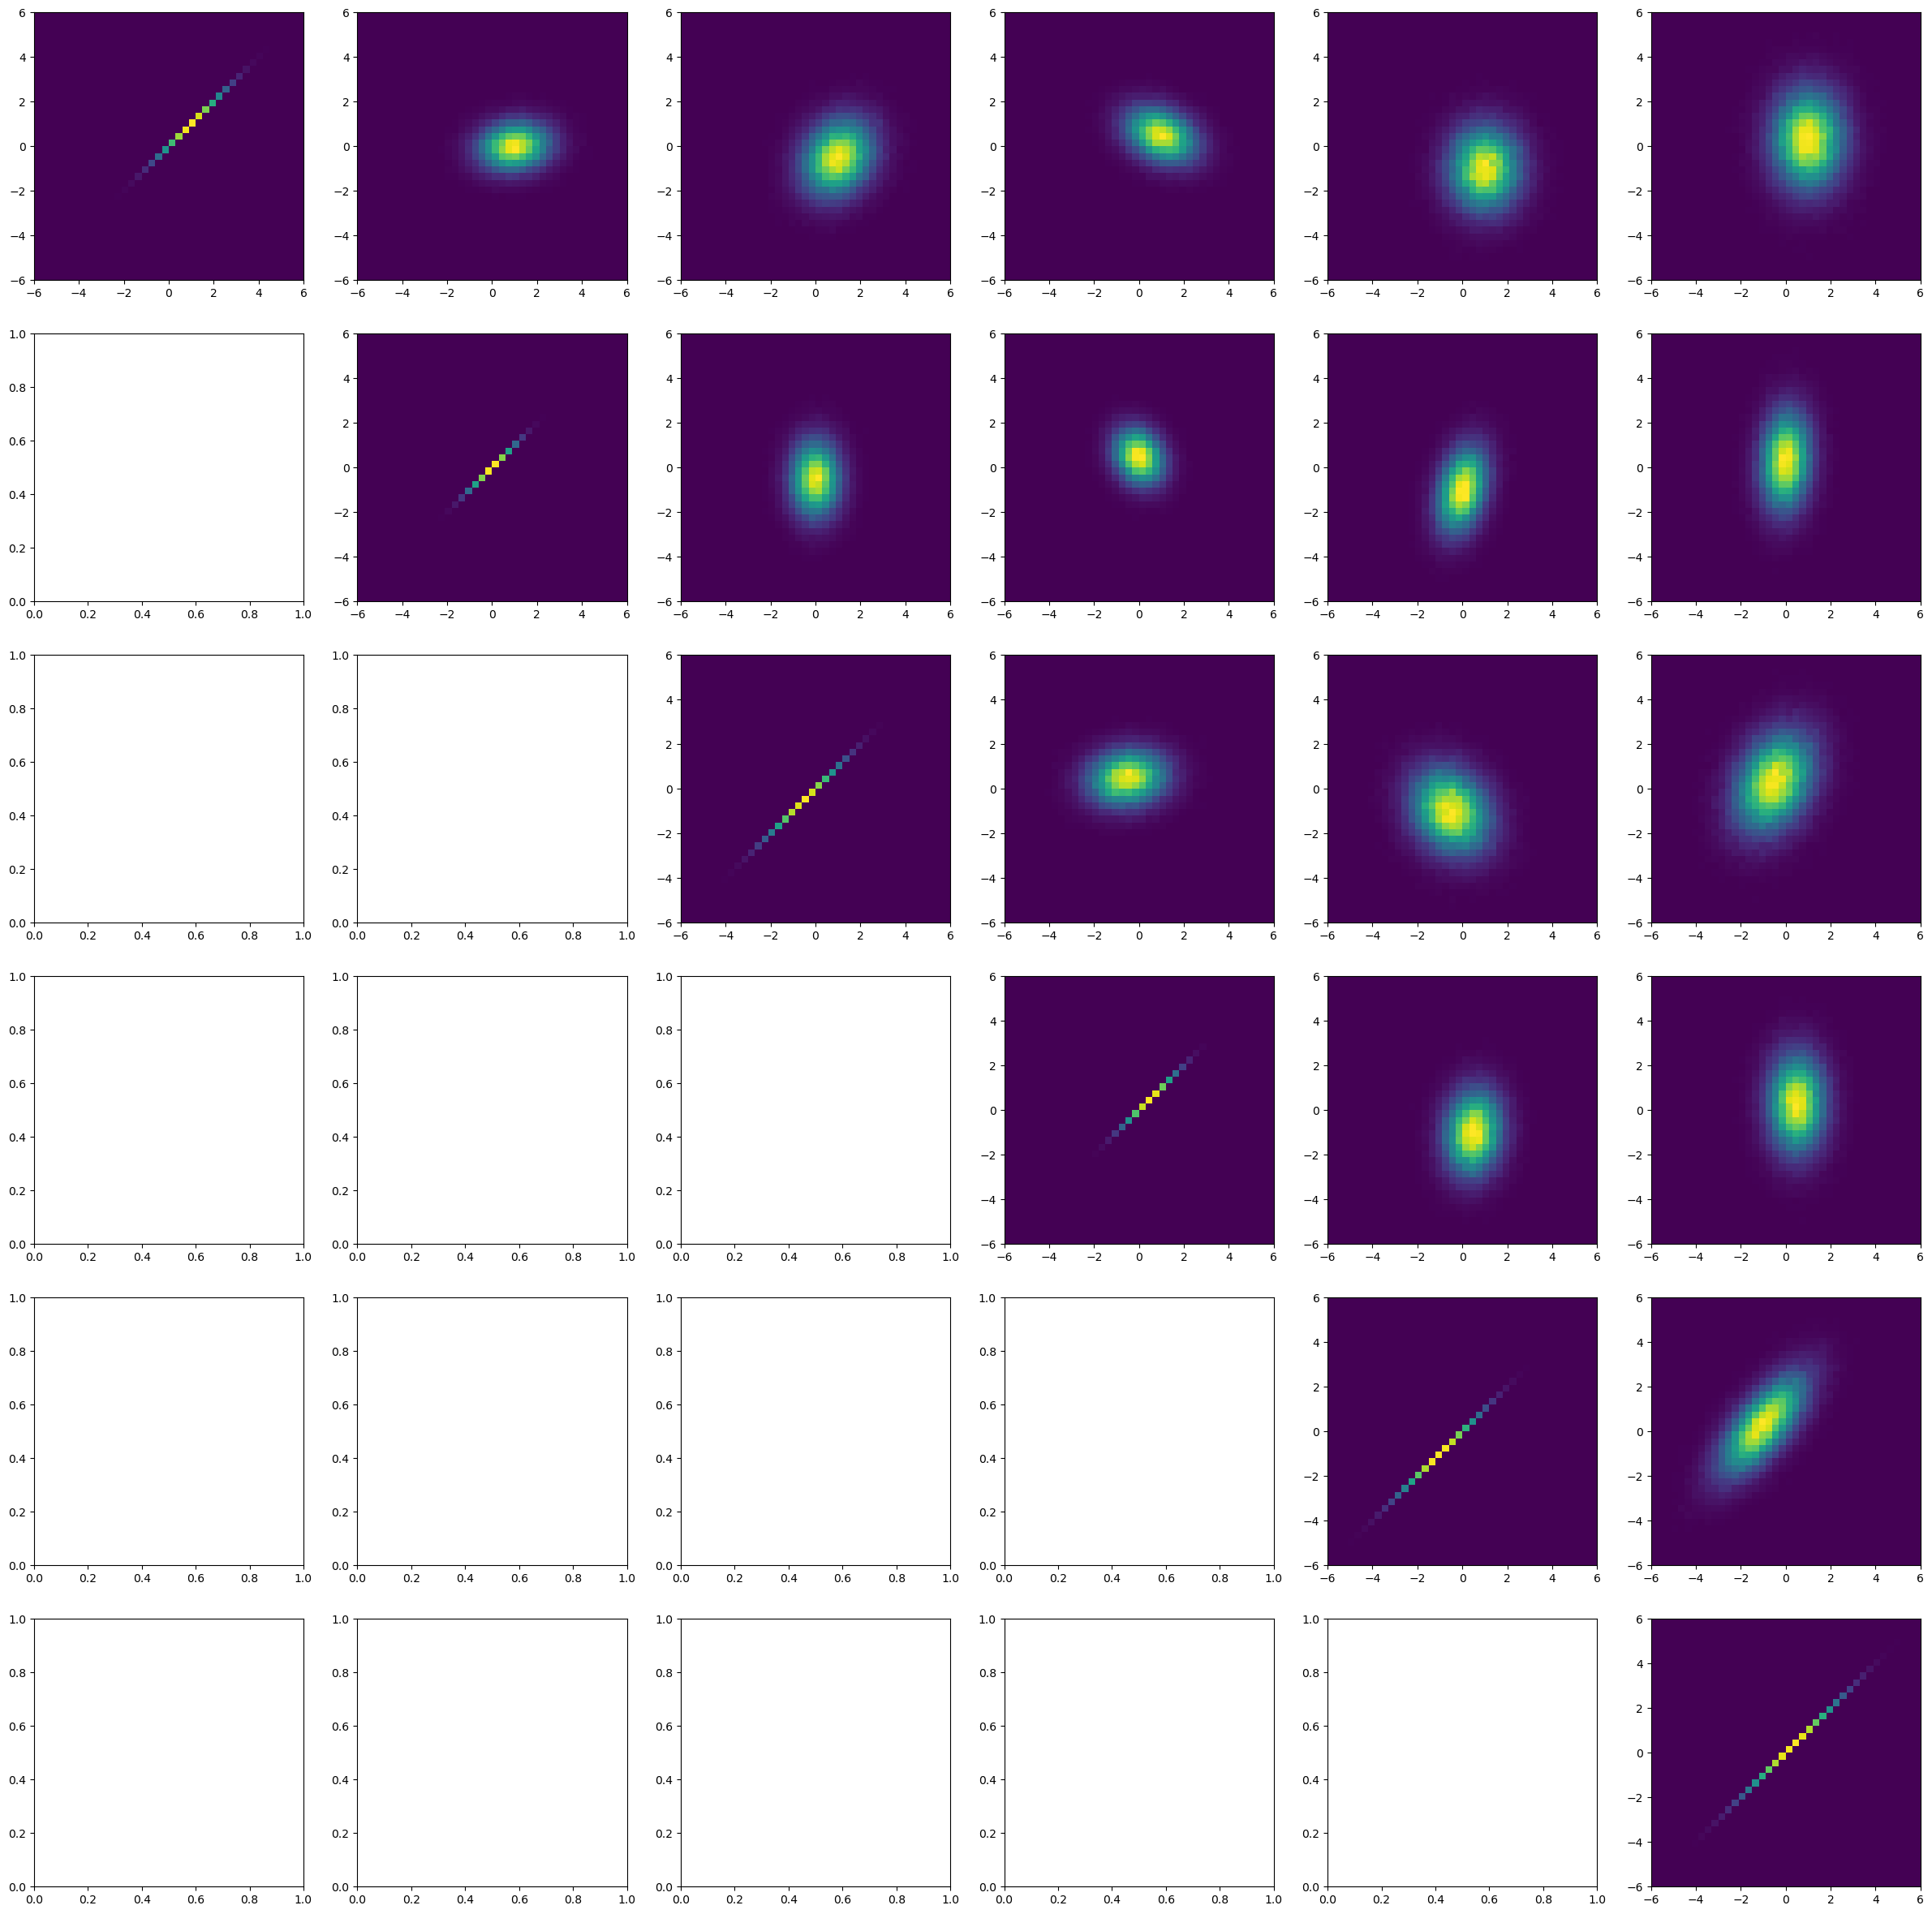

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( mc_pts[:,i], mc_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

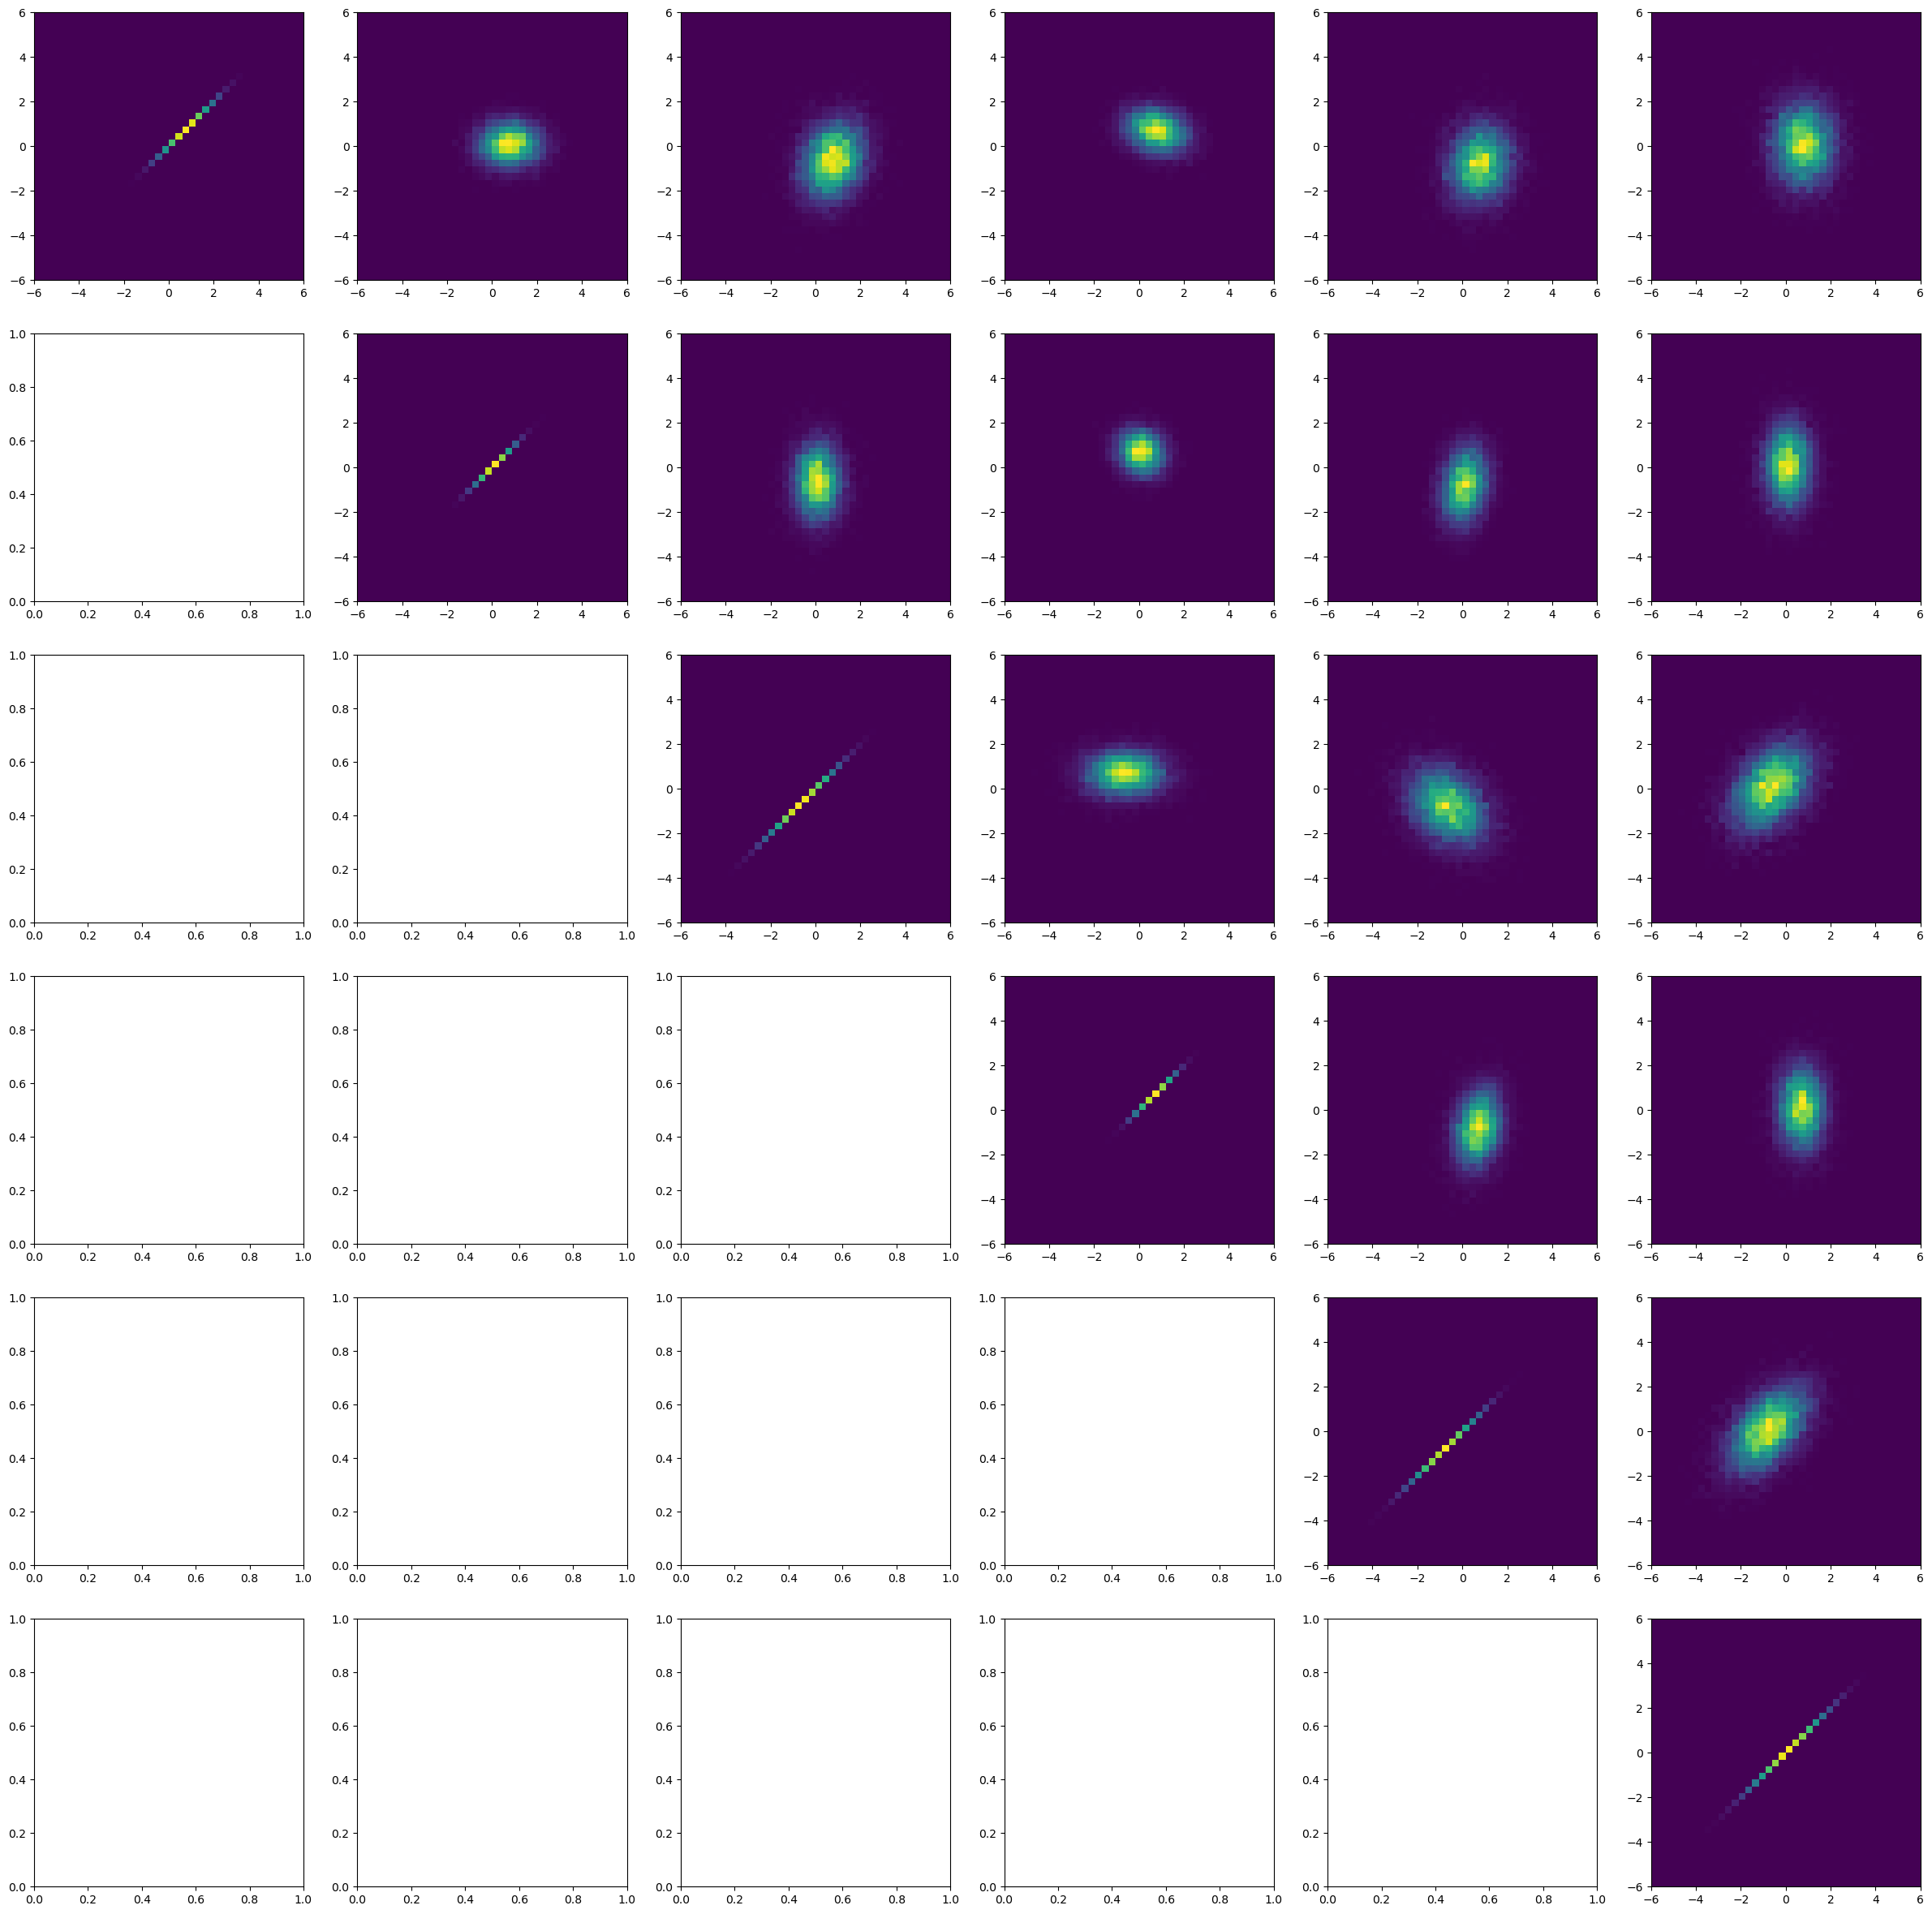

In [19]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

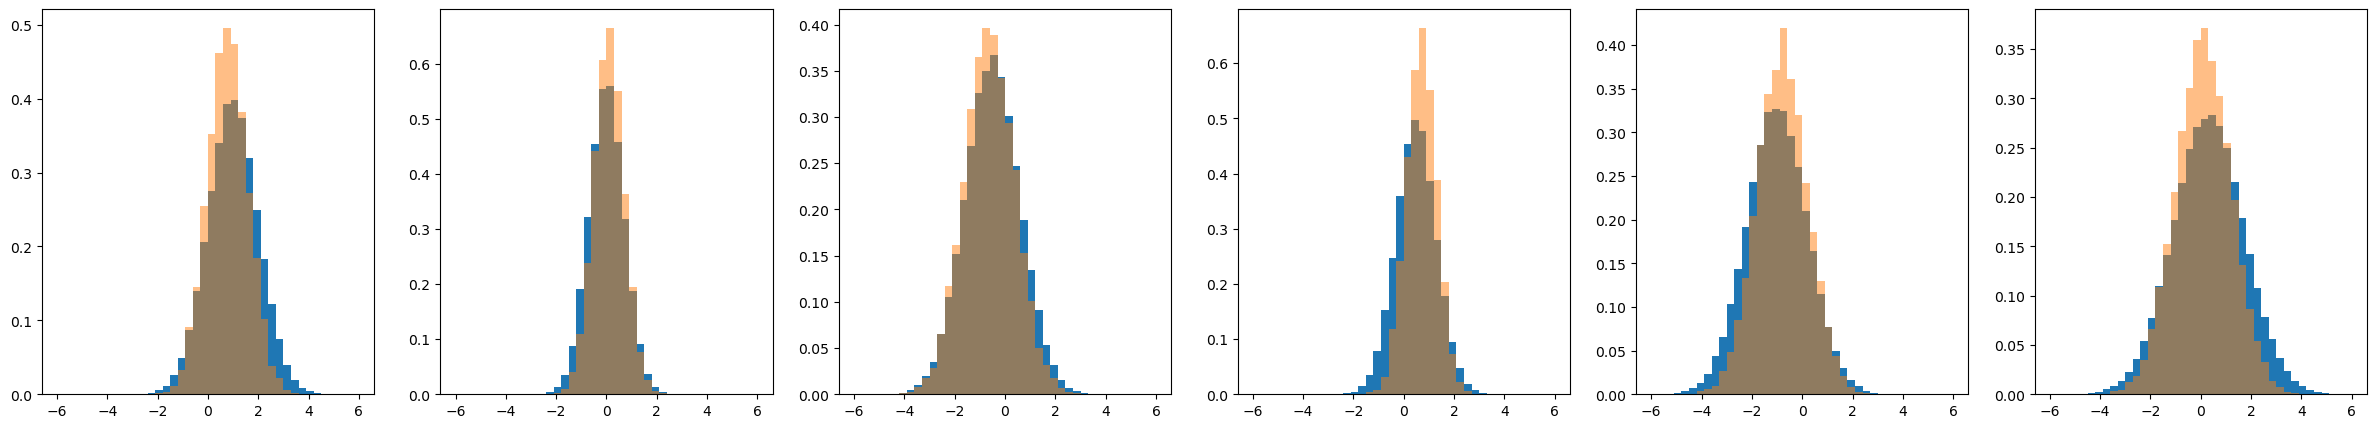

In [20]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i]
        axi.hist( mc_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        axi.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [21]:
mc_pts_minus_mc_mu = mc_pts - mc_mu
mc_pts_minus_true_mu = mc_pts - true_mu
true_cov_inv_times_v = np.tensordot( true_cov_inv, mc_pts_minus_true_mu.T, axes=(1,0) )
v_times_true_cov_inv_times_v =  np.sum( mc_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)
mc_cov_inv_times_v = np.tensordot( mc_cov_inv, mc_pts_minus_mc_mu.T, axes=(1,0) )
v_times_mc_cov_inv_times_v =  np.sum( mc_pts_minus_mc_mu.T * mc_cov_inv_times_v, axis=0)
exp_v_times_mc_cov_inv_times_v = np.exp( -0.5 * v_times_mc_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )
true_cov_det = np.linalg.det( true_cov )
mc_cov_det = np.linalg.det( mc_cov )
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )
norm2_train = np.power( 3.14159265, ndim) * mc_cov_det
print("\n norm2_train : %f\n" % norm2_train )
pdf_train = exp_v_times_mc_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)
pdf_ratio = pdf_true / pdf_train
sample_sf = (1.*len(true_pts))/(1.*len(mc_pts))
print('\n sample_sf = %f' % sample_sf )
calc_weight = pdf_ratio
calc_weight_scaled = sample_sf * pdf_ratio
print('\n Calculated weights :  %s\n' % str(calc_weight))


 norm2_true : 21.028028


 norm2_train : 165.846901

[0.00040973 0.00048064 0.01318022 ... 0.0061279  0.00186692 0.00249655]
[2.96654632e-05 2.38045396e-05 7.87498151e-03 ... 1.10913911e-02
 7.53218968e-04 1.01835874e-03]

 sample_sf = 0.100000

 Calculated weights :  [0.07240328 0.04952666 0.59748495 ... 1.8099821  0.40345575 0.40790677]



## Set up NN model for OmniFold

In [22]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [23]:

reg_setval_zero = 0.0


model_step1 = Sequential()

model_step1.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
if use_batch_norm : model_step1.add( BatchNormalization() )
model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval), 
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

model_step1.add( Dense(1, activation='sigmoid') )





model_step2 = Sequential()

model_step2.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval), 
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
if use_batch_norm : model_step2.add( BatchNormalization() )
model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

model_step2.add( Dense(1, activation='sigmoid') )


#----








opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )



model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])

print('\n\n ------ model_step1:')
model_step1.summary()

print('\n\n ------ model_step2:')
model_step2.summary()




 ------ model_step1:


/usr/lib/python3/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743397371.504212 1652432 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743397371.550222 1652432 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743397371.550516 1652432 cuda_executor.cc:1015] successful NUMA n

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,501 (21.49 KB)

 Trainable params: 5,501 (21.49 KB)

 Non-trainable params: 0 (0.00 B)



 ------ model_step2:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,501 (21.49 KB)

 Trainable params: 5,501 (21.49 KB)

 Non-trainable params: 0 (0.00 B)

## Show some model structure details

In [24]:
for li in range(len(model_step1.layers)) :
    print( ' \n layer index %2d : name = %s' % (li, model_step1.layers[li].name) )
    if 'dropout' in model_step1.layers[li].name : continue
    for gwi in range( len( model_step1.layers[li].get_weights() )) :
        print( ' %3d, %3d : shape %s' % (li, gwi, str(model_step1.layers[li].get_weights()[gwi].shape)) )
        print( ' %3d, %3d : range %5.3f to %5.3f' % (li, gwi, 
                                                     np.min(model_step1.layers[li].get_weights()[gwi]),
                                                     np.max(model_step1.layers[li].get_weights()[gwi]),
                                                    ))
        #print( ' %3d : %s' % (gwi, str(model_step1.layers[li].get_weights()[gwi])) )
    

 
 layer index  0 : name = dense
   0,   0 : shape (6, 50)
   0,   0 : range -0.326 to 0.326
   0,   1 : shape (50,)
   0,   1 : range 0.000 to 0.000
 
 layer index  1 : name = dropout
 
 layer index  2 : name = dense_1
   2,   0 : shape (50, 50)
   2,   0 : range -0.244 to 0.245
   2,   1 : shape (50,)
   2,   1 : range 0.000 to 0.000
 
 layer index  3 : name = dropout_1
 
 layer index  4 : name = dense_2
   4,   0 : shape (50, 50)
   4,   0 : range -0.245 to 0.245
   4,   1 : shape (50,)
   4,   1 : range 0.000 to 0.000
 
 layer index  5 : name = dropout_2
 
 layer index  6 : name = dense_3
   6,   0 : shape (50, 1)
   6,   0 : range -0.338 to 0.312
   6,   1 : shape (1,)
   6,   1 : range 0.000 to 0.000


## Define and test function to reset the model weights

In [25]:
def reset_model_weights( model, verb=False ) :
    print('Resetting weights for model %s' % model)
    for li in range(len(model.layers)) :
        if verb : print( ' \n layer index %2d : name = %s' % (li, model.layers[li].name) )
        if 'dropout' in model.layers[li].name : continue
        weights, biases = model.layers[li].get_weights()
        weight_shape_sum = np.sum( weights.shape )
        weight_max = np.sqrt(6/weight_shape_sum)
        weight_min = -1 * weight_max
        new_weights = np.random.uniform( weight_min, weight_max, weights.shape )
        if verb :
            print( ' %3d : weights shape %s, sum %d, range [%.3f,%.3f], biases shape %s' % 
                  (li, str(weights.shape), weight_shape_sum, 
                   weight_min, weight_max, str(biases.shape)))
            print( ' old weights: %s  %s' % (str(weights.shape), str(weights) ) )
            print( ' new weights: %s  %s' % (str(new_weights.shape), str(new_weights) ) )
        new_biases = np.zeros( biases.shape )
        model.layers[li].set_weights( (new_weights, new_biases) )



In [26]:
reset_model_weights( model_step1, True )

Resetting weights for model <Sequential name=sequential, built=True>
 
 layer index  0 : name = dense
   0 : weights shape (6, 50), sum 56, range [-0.327,0.327], biases shape (50,)
 old weights: (6, 50)  [[-0.15777165  0.23727721  0.2870006  -0.10262458 -0.3067293  -0.2550922
   0.02949387 -0.3165394   0.19410384 -0.14259693  0.09619302 -0.24650747
   0.07879919 -0.09789126  0.01900285 -0.27420765 -0.12750633  0.00497738
   0.30269504 -0.15765108 -0.24513614 -0.0804763   0.08252868  0.27346718
   0.13594809 -0.17411207  0.25166857 -0.15249625 -0.21075308 -0.20568487
  -0.27561864  0.15766639  0.01710856 -0.28165698 -0.3013174  -0.11626019
  -0.05373204  0.05145893  0.2310586   0.13948256  0.17945224 -0.08591832
  -0.09336567  0.21475494 -0.02665836 -0.07385734 -0.01691628  0.15687019
   0.2884283   0.27948183]
 [-0.06957409  0.2065875   0.13301632 -0.142882   -0.07418326  0.15338442
  -0.13910834  0.07948956 -0.29017472 -0.1457667   0.03333506  0.02974713
  -0.3177154   0.19435602 -0.0

## Package the training data for OmniFold

In [27]:
mc_both = np.stack([mc_pts, mc_det_pts], axis=1)

## Define the OmniFold function

In [28]:
def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size, verbose=0)
    epsilon = K.epsilon()
    f = K.clip( f, epsilon, 1. - epsilon )  #owen: protect against divide by zero.
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))


In [29]:
def omnifold(theta0,theta_unknown_S,iterations, model_step1, model_step2, verbose=0,
             batch_size_setval=10000, epochs_setval=20,
             save_step2_model=False, output_dir="./", patience_setval=5,
             restore_best_weights_setval=False):

    ensemble_weights = np.empty(shape=(n_models_to_ensemble, iterations, 2, len(theta0)))

    ensemble_final_push_weights = np.empty( shape=(n_models_to_ensemble, len(theta0)) )
    
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    ensemble_push_weights_for_output = np.empty( shape=(n_models_to_ensemble, iterations, len(theta0)) )

    ensemble_pull_weights_for_output = np.empty( shape=(n_models_to_ensemble, iterations, len(theta0)) )

    
    
    
    
    
    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))

    premc_xvals_1 = np.concatenate((theta0_S, theta0_S))
    premc_yvals_1 = np.concatenate( (np.ones(len(theta0_S)), np.zeros(len(theta0_S))) )
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    premc_xvals_2 = np.concatenate((theta0_G, theta0_G))
    premc_yvals_2 = np.concatenate( (np.ones(len(theta0_G)), np.zeros(len(theta0_G))) )
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown_step2))

    if verbose :
        print("\n\n")
        print("  ======== omnifold\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) ) ;
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) ) ;
        print("  shape of xvals_1 :  %s" % str(np.shape( xvals_1 )) ) ;
        print("\n\n")
        print("  shape of labels0 : %s" % str(np.shape(labels0)) ) ;
        print("  shape of labels_unknown : %s" % str(np.shape(labels_unknown)) ) ;
        print("  shape of yvals_1 :  %s" % str(np.shape( yvals_1 )) ) ;
        print("\n\n")
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) ) ;
        print("  shape of xvals_2 :  %s" % str(np.shape( xvals_2 )) ) ;
        print("  shape of yvals_2 :  %s" % str(np.shape( yvals_2 )) ) ;
        print("\n batch size setval  %d" % batch_size_setval )
        print(" epochs setval  %d" % epochs_setval )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    # owen: rescale the MC weights to balance the two categories for step 1 in first iteration.
    mc_weight_sf = (1.*len(theta_unknown_S))/(1.*len(theta0_S))

    

        
    fitverbose = 0
    if verbose > 1 : fitverbose = 1
        
    

    return_dict = {}
    
#--------- Begin loop over ensembles
  
    for ei in range( n_models_to_ensemble ) :


        if (verbose>0) :
            print('\n\n\n ++++++++++++++ Begin Ensemble %2d ++++++++++++++++\n\n' % ei )

        reset_model_weights( model_step1 )  

        reset_model_weights( model_step2 )

        weights_pull = np.ones(len(theta0_S))
        weights_push = np.ones(len(theta0_S))

    
#------------- Begin loop over iterations

        for i in range(iterations):

            if (verbose>0):
                print("\nITERATION: {}\n".format(i + 1))
                pass

            # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
            # weights reweighted Sim. --> Data

            if (verbose>0):
                print("   -- ITERATION %d  STEP 1\n" % (i+1) )
                pass

            print(" weights_push at the beginning")
            print( weights_push )



         # owen: put the scaling here so that weights_push keeps its meaning (order 1).
            weights_1 = np.concatenate((mc_weight_sf * weights_push, np.ones(len(theta_unknown_S))))

            X_mc_1, X_test_1, Y_mc_1, Y_test_1, w_mc_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

            # zip ("hide") the weights with the labels
            Y_mc_1 = np.stack((Y_mc_1, w_mc_1), axis=1)
            Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
            
            if verbose>0 : print(' Iter %d, step 1, ensemble index %d' % (i, ei) )
            
            
            
            if i > -1 :

                    premc_weights_1 = np.concatenate( (np.ones(len(theta0_S)), np.ones(len(theta0_S))) )

                    pt_X_mc_1, pt_X_test_1, pt_Y_mc_1, pt_Y_test_1, pt_w_mc_1, pt_w_test_1 = train_test_split(premc_xvals_1, premc_yvals_1, premc_weights_1)

                    pt_Y_mc_1 = np.stack((pt_Y_mc_1, pt_w_mc_1), axis=1)
                    pt_Y_test_1 = np.stack((pt_Y_test_1, pt_w_test_1), axis=1)

                    if verbose>0 :
                            print("             running pre-training, distinguish from self.")

                    model_step1.fit( pt_X_mc_1, pt_Y_mc_1, epochs=5, batch_size=batch_size_setval, verbose=False )

                    if verbose>0 :
                            print("             done pretraining.")

                            
                            
                            
                            
            this_epochs = epochs_setval
            if i == 0 : this_epochs = this_epochs*2
        
            earlystopping = EarlyStopping(patience=patience_setval, verbose=True, 
                                          restore_best_weights=restore_best_weights_setval)

            if patience_setval >= 0 :
                cbl = [earlystopping]
            else :
                cbl = []
                
            mc_history_step1 = model_step1.fit(X_mc_1,
                                                  Y_mc_1,
                                                  epochs=this_epochs,
                                                  batch_size=batch_size_setval,
                                                  validation_data=(X_test_1, Y_test_1),
                                                  verbose=fitverbose,
                                                  callbacks=cbl )

            
            ensemble_weights[ei, i, 0, :] = reweight(theta0_S,model_step1)
            
            print(' Ensemble %2d, Iteration %d, step 1, weights' % (ei, i))
            print( ensemble_weights[ei, i, 0, :] )
        
        
            step1_output_weights = reweight(theta0_S,model_step1)
            

            weights_pull = weights_push * step1_output_weights

            weights[i, :1, :] = step1_output_weights

            return_dict["mc-hist-step1-iter%d" % i] = mc_history_step1

            return_dict['model_weights_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[0] )

            return_dict['model_biases_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[1] )

            ensemble_pull_weights_for_output[ei,i,:] = weights_pull

            
            
            
            
            

            # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
            # weights Gen. --> reweighted Gen.

            if (verbose>0):
                print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
                pass

            
            if verbose>0 : print(' Iter %d, step 2, ensemble index %d' % (i, ei) )

            # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
            weights_2 = np.concatenate((   weights_push  , weights_pull))

            X_mc_2, X_test_2, Y_mc_2, Y_test_2, w_mc_2, w_test_2 = train_test_split(xvals_2, yvals_2, weights_2)

            # zip ("hide") the weights with the labels
            Y_mc_2 = np.stack((Y_mc_2, w_mc_2), axis=1)
            Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

            if i > -1 :

                    premc_weights_2 = np.concatenate( (np.ones(len(theta0_G)), np.ones(len(theta0_G))) )

                    pt_X_mc_2, pt_X_test_2, pt_Y_mc_2, pt_Y_test_2, pt_w_mc_2, pt_w_test_2 = train_test_split(premc_xvals_2, premc_yvals_2, premc_weights_2)

                    pt_Y_mc_2 = np.stack((pt_Y_mc_2, pt_w_mc_2), axis=1)
                    pt_Y_test_2 = np.stack((pt_Y_test_2, pt_w_test_2), axis=1)

                    if verbose>0 :
                            print("             running pre-training, distinguish from self.")

                    model_step2.fit( pt_X_mc_2, pt_Y_mc_2, epochs=5, batch_size=batch_size_setval, verbose=fitverbose )

                    if verbose>0 :
                            print("             done pretraining.")

            earlystopping = EarlyStopping(patience=patience_setval, verbose=True,
                                          restore_best_weights=restore_best_weights_setval)
            if patience_setval >= 0 :
                cbl = [earlystopping]
            else :
                cbl = []

            mc_history_step2 = model_step2.fit(X_mc_2,
                                                  Y_mc_2,
                                                  epochs=this_epochs,
                                                  batch_size=batch_size_setval,
                                                  validation_data=(X_test_2, Y_test_2),
                                                  callbacks=cbl,
                                                  verbose=fitverbose )

            return_dict["mc-hist-step2-iter%d" % i] = mc_history_step2

            return_dict['model_weights_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[0] )

            return_dict['model_biases_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[1] )


            ensemble_weights[ei, i, 1, :] = reweight(theta0_G,model_step2)

            print(' Ensemble %2d, Iteration %d, step 2, weights' % (ei, i))
            print( ensemble_weights[ei, i, 1, :] )        


            step2_output_weights = reweight(theta0_G,model_step2)

            weights_push = step2_output_weights * weights_push

            #push_weights_for_output[i] = weights_push
            
            ensemble_push_weights_for_output[ei,i,:] = weights_push

            weights[i, 1:2, :] = step2_output_weights

            if save_step2_model :
                model_output_dir = "%s/of-step2-iter%02d-ensemble%02d-model" % (output_dir, i, ei)
                print("\n +++ Saving step 2, iteration %d model in %s" % (i, model_output_dir) )
                model_step2.save( "%s.keras" % model_output_dir )
                
                
    #----------- End loop over iterations
                
        ensemble_final_push_weights[ei,:] = weights_push
        
    #------- End loop over ensembles

    if verbose>0 :
        print('\n Done with loop over ensembles.  Now averaging final push weights.')

    return_dict["final_push_weights"] = np.average( ensemble_final_push_weights, axis=0 )

    push_weights_for_output = np.average( ensemble_push_weights_for_output, axis=0 )

    pull_weights_for_output = np.average( ensemble_pull_weights_for_output, axis=0 )
    
    return_dict["weights"] = weights
    
    return_dict["ensemble_weights"] = ensemble_weights

    return_dict['ensemble_final_push_weights'] = ensemble_final_push_weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["pull_weights"] = pull_weights_for_output    
    
    



    
    return return_dict


## Run OmniFold

In [30]:
%%time


verbose = True







of_return_dict = omnifold( 
    mc_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir,
    patience_setval, restore_best_weights_setval
)


of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(mc_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

pull_weights = of_return_dict["pull_weights"]

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

ensemble_final_push_weights = of_return_dict['ensemble_final_push_weights']

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold


  shape of theta0_S : (100000, 6)
  shape of theta_unknown_S : (10000, 6)
  shape of xvals_1 :  (110000, 6)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10000,)
  shape of yvals_1 :  (110000,)



  shape of theta0_G : (100000, 6)
  shape of xvals_2 :  (200000, 6)
  shape of yvals_2 :  (200000,)

 batch size setval  10000
 epochs setval  50






 ++++++++++++++ Begin Ensemble  0 ++++++++++++++++


Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Iter 0, step 1, ensemble index 0
             running pre-training, distinguish from self.


I0000 00:00:1743397372.880455 1652737 service.cc:146] XLA service 0x77e8dc00b0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743397372.880486 1652737 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-30 22:02:52.905181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-30 22:02:52.997544: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1743397373.561785 1652737 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


             done pretraining.
 Ensemble  0, Iteration 0, step 1, weights
[0.28480446 0.2985037  2.33570719 ... 2.04123926 0.78528315 0.23010047]

   -- ITERATION 1  STEP 2

 Iter 0, step 2, ensemble index 0
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  0, Iteration 0, step 2, weights
[0.46106312 0.41626593 1.27978992 ... 1.54151833 0.47553781 0.68097734]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.46106312 0.41626593 1.27978992 ... 1.54151833 0.47553781 0.68097734]
 Iter 1, step 1, ensemble index 0
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  0, Iteration 1, step 1, weights
[0.61810046 0.48575586 1.08485651 ... 1.25697887 0.83356595 0.73199284]

   -- ITERATION 2  STEP 2

 Iter 1, step 2, ensemble index 0
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  0, Iteration 1, step 2, weights
[0.69249266

             done pretraining.
 Ensemble  2, Iteration 2, step 2, weights
[0.77016634 0.78170264 0.93002063 ... 1.03566647 0.92115408 0.86202562]

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[0.28053708 0.19712767 1.0066682  ... 1.34620517 0.48281208 0.57162859]
 Iter 3, step 1, ensemble index 2
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  2, Iteration 3, step 1, weights
[0.84422565 0.83055413 0.99363399 ... 1.18506134 0.9506492  0.7531839 ]

   -- ITERATION 4  STEP 2

 Iter 3, step 2, ensemble index 2
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  2, Iteration 3, step 2, weights
[0.91437954 0.88036579 0.91314    ... 1.04149199 0.97963887 1.08086634]

ITERATION: 5

   -- ITERATION 5  STEP 1

 weights_push at the beginning
[0.25651737 0.17354445 0.919229   ... 1.4020619  0.47298148 0.61785411]
 Iter 4, step 1, ensemble index 2
             running pre-t

             done pretraining.
 Ensemble  5, Iteration 0, step 1, weights
[0.25401738 0.17648129 2.06468272 ... 2.23450255 1.06171215 0.13467731]

   -- ITERATION 1  STEP 2

 Iter 0, step 2, ensemble index 5
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  5, Iteration 0, step 2, weights
[0.35945779 0.30522683 1.14222467 ... 1.63042831 0.57535094 0.65089846]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.35945779 0.30522683 1.14222467 ... 1.63042831 0.57535094 0.65089846]
 Iter 1, step 1, ensemble index 5
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  5, Iteration 1, step 1, weights
[0.69993919 0.59620363 1.0927316  ... 1.19291353 1.06202054 0.62765867]

   -- ITERATION 2  STEP 2

 Iter 1, step 2, ensemble index 5
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  5, Iteration 1, step 2, weights
[0.7557705 

             done pretraining.
 Ensemble  7, Iteration 2, step 2, weights
[0.79483843 0.7535221  0.86818665 ... 1.00088966 1.04592383 0.91622978]

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[0.25944428 0.1794056  0.8335249  ... 1.43738478 0.78558586 0.57656268]
 Iter 3, step 1, ensemble index 7
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  7, Iteration 3, step 1, weights
[0.8050077  0.76339179 1.00489163 ... 1.072896   0.96833396 0.76832956]

   -- ITERATION 4  STEP 2

 Iter 3, step 2, ensemble index 7
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  7, Iteration 3, step 2, weights
[0.79273796 0.76674205 0.95459789 ... 0.93018943 0.95684028 1.11015904]

ITERATION: 5

   -- ITERATION 5  STEP 1

 weights_push at the beginning
[0.20567133 0.13755782 0.79568112 ... 1.33704013 0.75168019 0.64007627]
 Iter 4, step 1, ensemble index 7
             running pre-t

In [31]:
def hist_to_func( hist_bin_data, xe, ye ) :
    
    return_array = np.zeros( hist_bin_data.shape[0] )
    
    xvals = np.zeros( hist_bin_data.shape[0] )
    yvals = np.zeros( hist_bin_data.shape[0] )
    
    for bi in range( hist_bin_data.shape[0] ) :
        xvals[bi] = 0.5 * (xe[bi] + xe[bi+1] )
        yvals[bi] = 0.5 * (ye[bi] + ye[bi+1] )

    
    for bi0 in range(hist_bin_data.shape[0]) :
        esum = 0
        biesum = 0    
        for bi1 in range(hist_bin_data.shape[1]) :
            esum += hist_bin_data[bi0,bi1]
            #biesum += bi1*hist_bin_data[bi0,bi1]
            biesum += yvals[bi1]*hist_bin_data[bi0,bi1]

        wave = 0
        if esum > 0 :
            wave = biesum / esum
        return_array[bi0] = wave
        
    return return_array, xvals


In [32]:
if ndim == 1 :
    
    hbins=400
    
    hpw,xe,ye = np.histogram2d( mc_pts[:,0], final_push_weights[:], bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
    

    ave_fpw, xvals = hist_to_func( hpw, xe, ye )
    
    ensemble_weight_functions = np.zeros( shape=(n_models_to_ensemble, hbins) )

    for ei in range( n_models_to_ensemble ) : 
        hpw,xe,ye = np.histogram2d( mc_pts[:,0], ensemble_final_push_weights[ei,:], 
                       bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
        ensemble_weight_functions[ei,:],_ = hist_to_func( hpw, xe, ye )
    

    fig,ax = plt.subplots( 1, 1, figsize=(12,12))
    
    axi = ax

    ls = '-'
    msty = ''
    msz = 2
    lwd = 1
    
    for ei in range( n_models_to_ensemble ) :
        axi.plot( xvals, ensemble_weight_functions[ei], label='Output %d' % ei,
                 linestyle=ls, marker=msty, markersize=msz, linewidth=lwd )



    axi.plot( xvals, ave_fpw, label='Ensemble Average',
             color='black', linestyle=ls, marker=msty, markersize=1.5*msz, linewidth=2*lwd )
    
    axi.set_xlabel('Feature coordinate', fontsize=15)
    axi.set_ylabel('Event weight', fontsize=15)
    
    axi.legend()
    
    plt.grid(True)

    plt.show
    

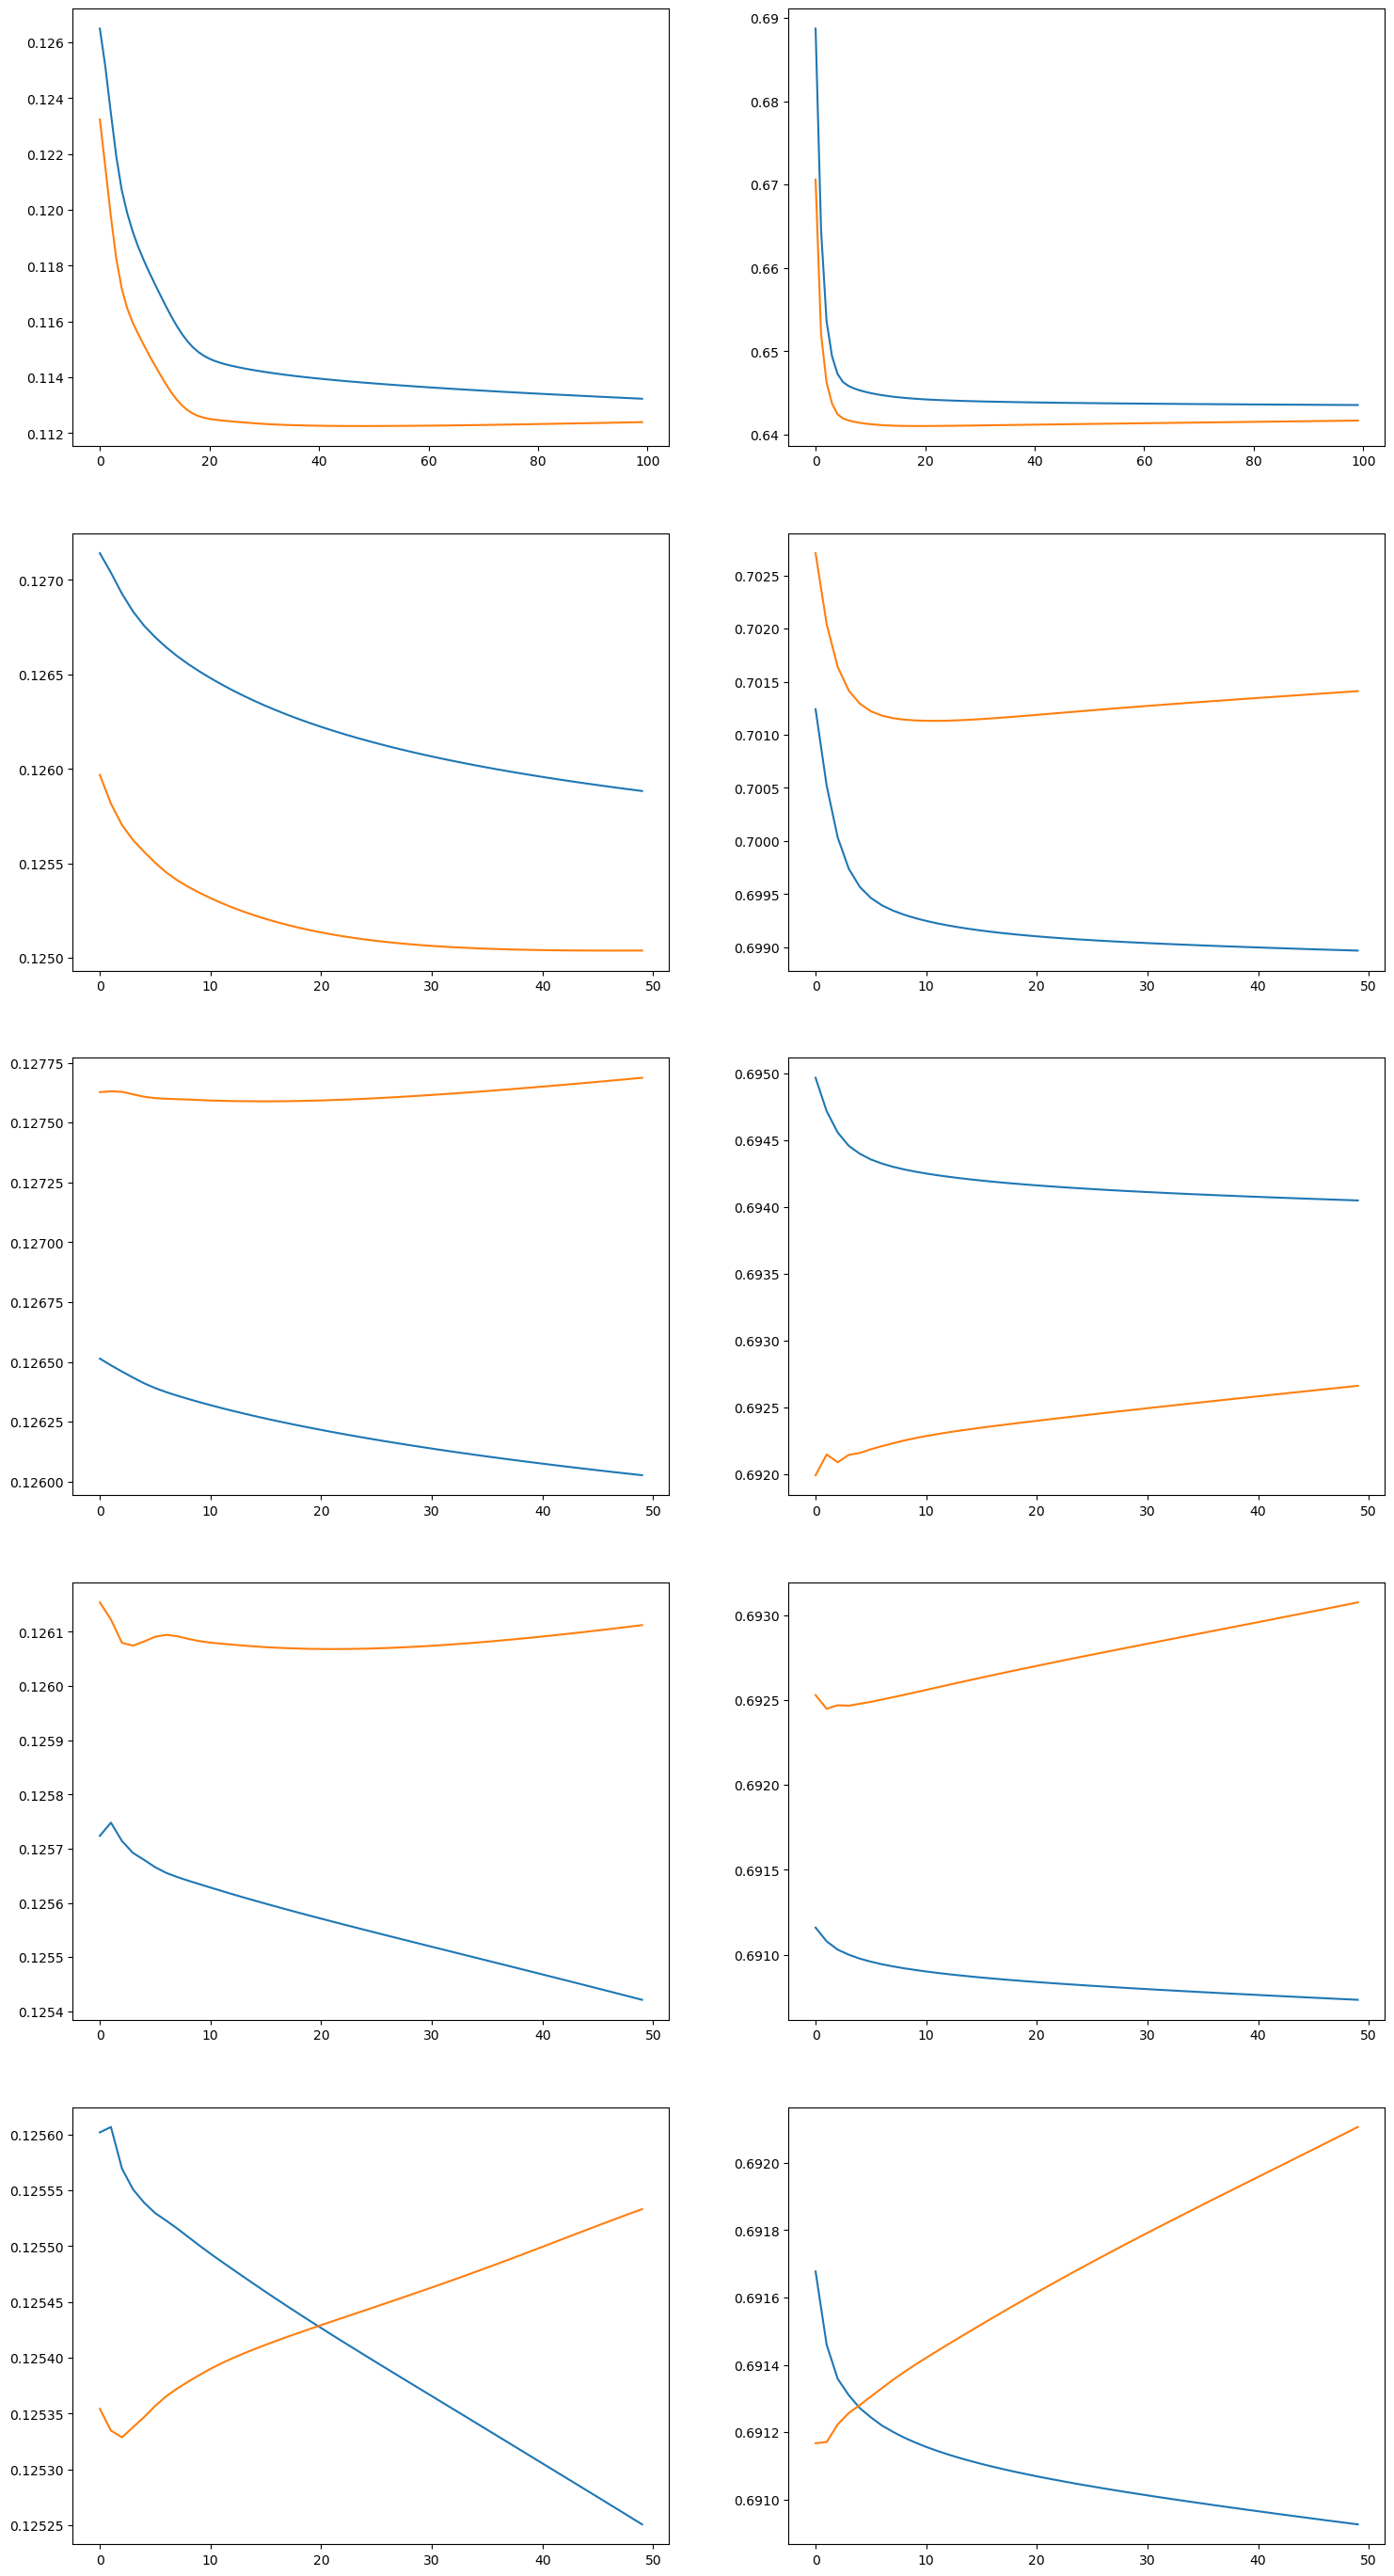

In [33]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

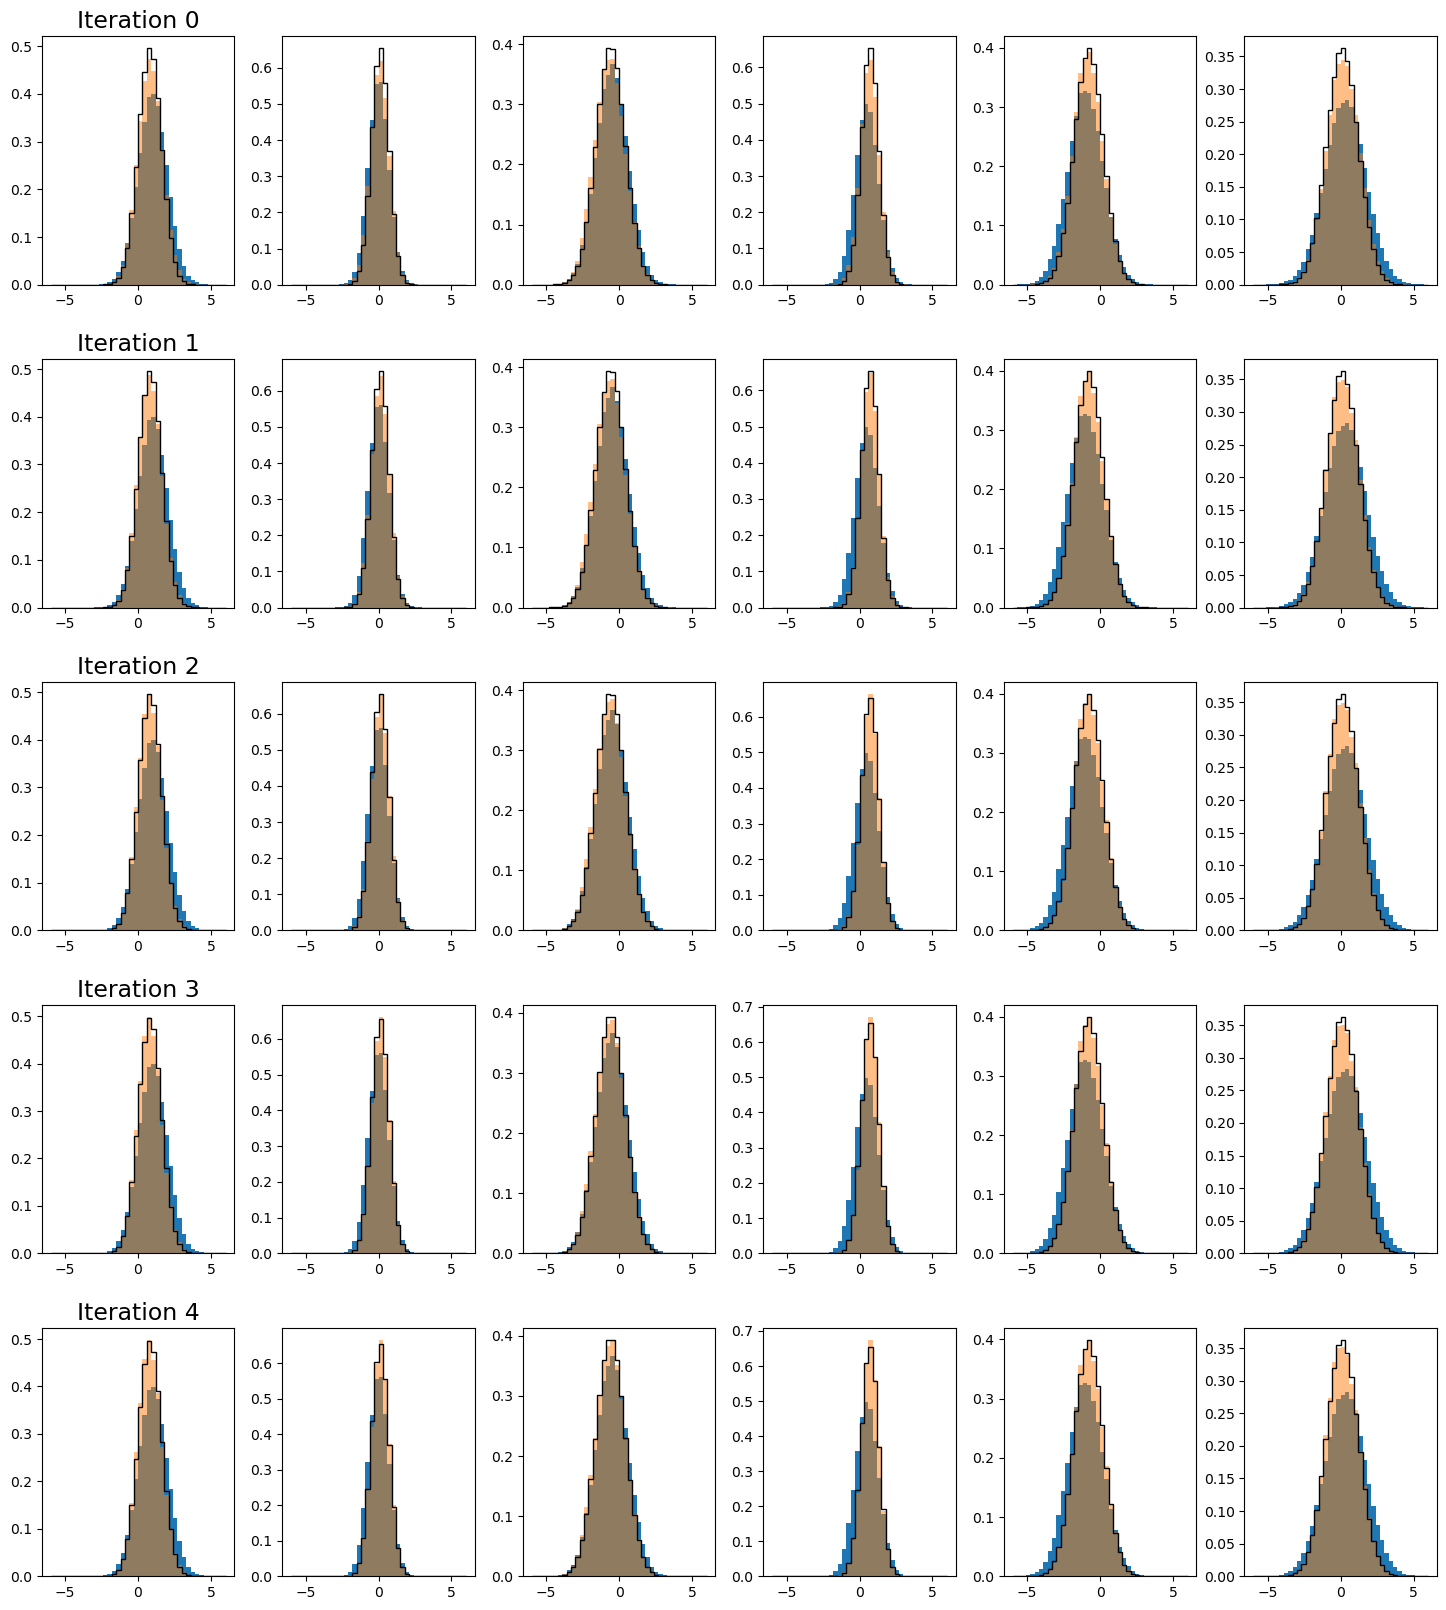

In [34]:



fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( mc_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [35]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

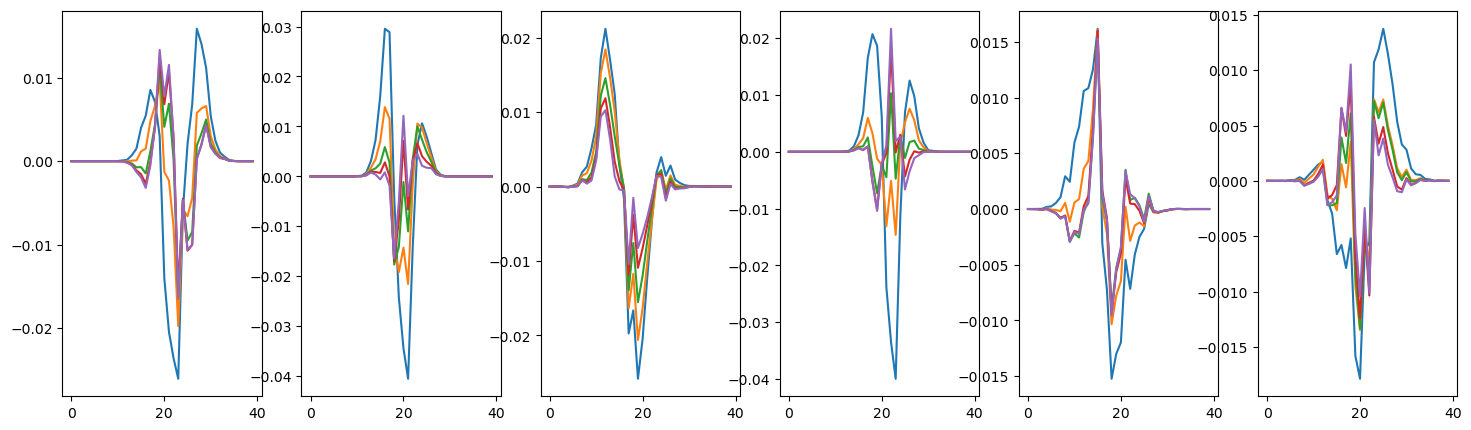

In [36]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

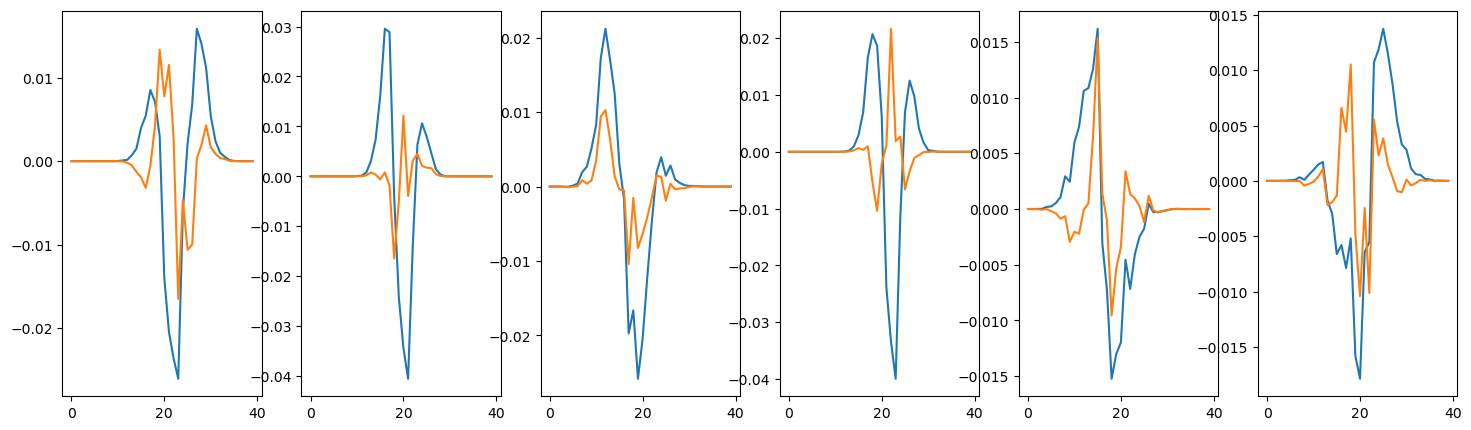

In [37]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

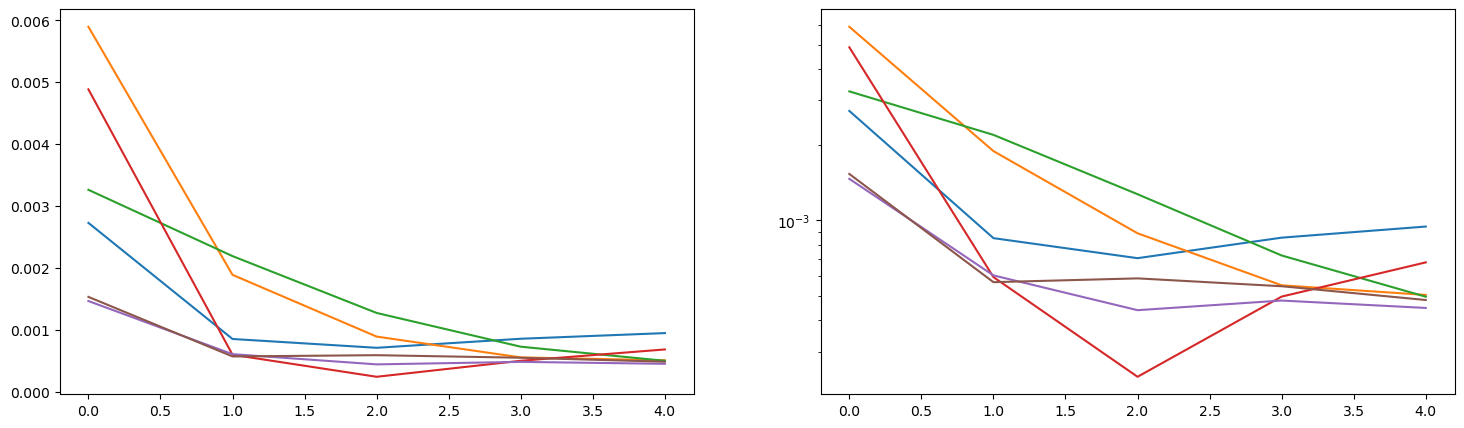

In [38]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

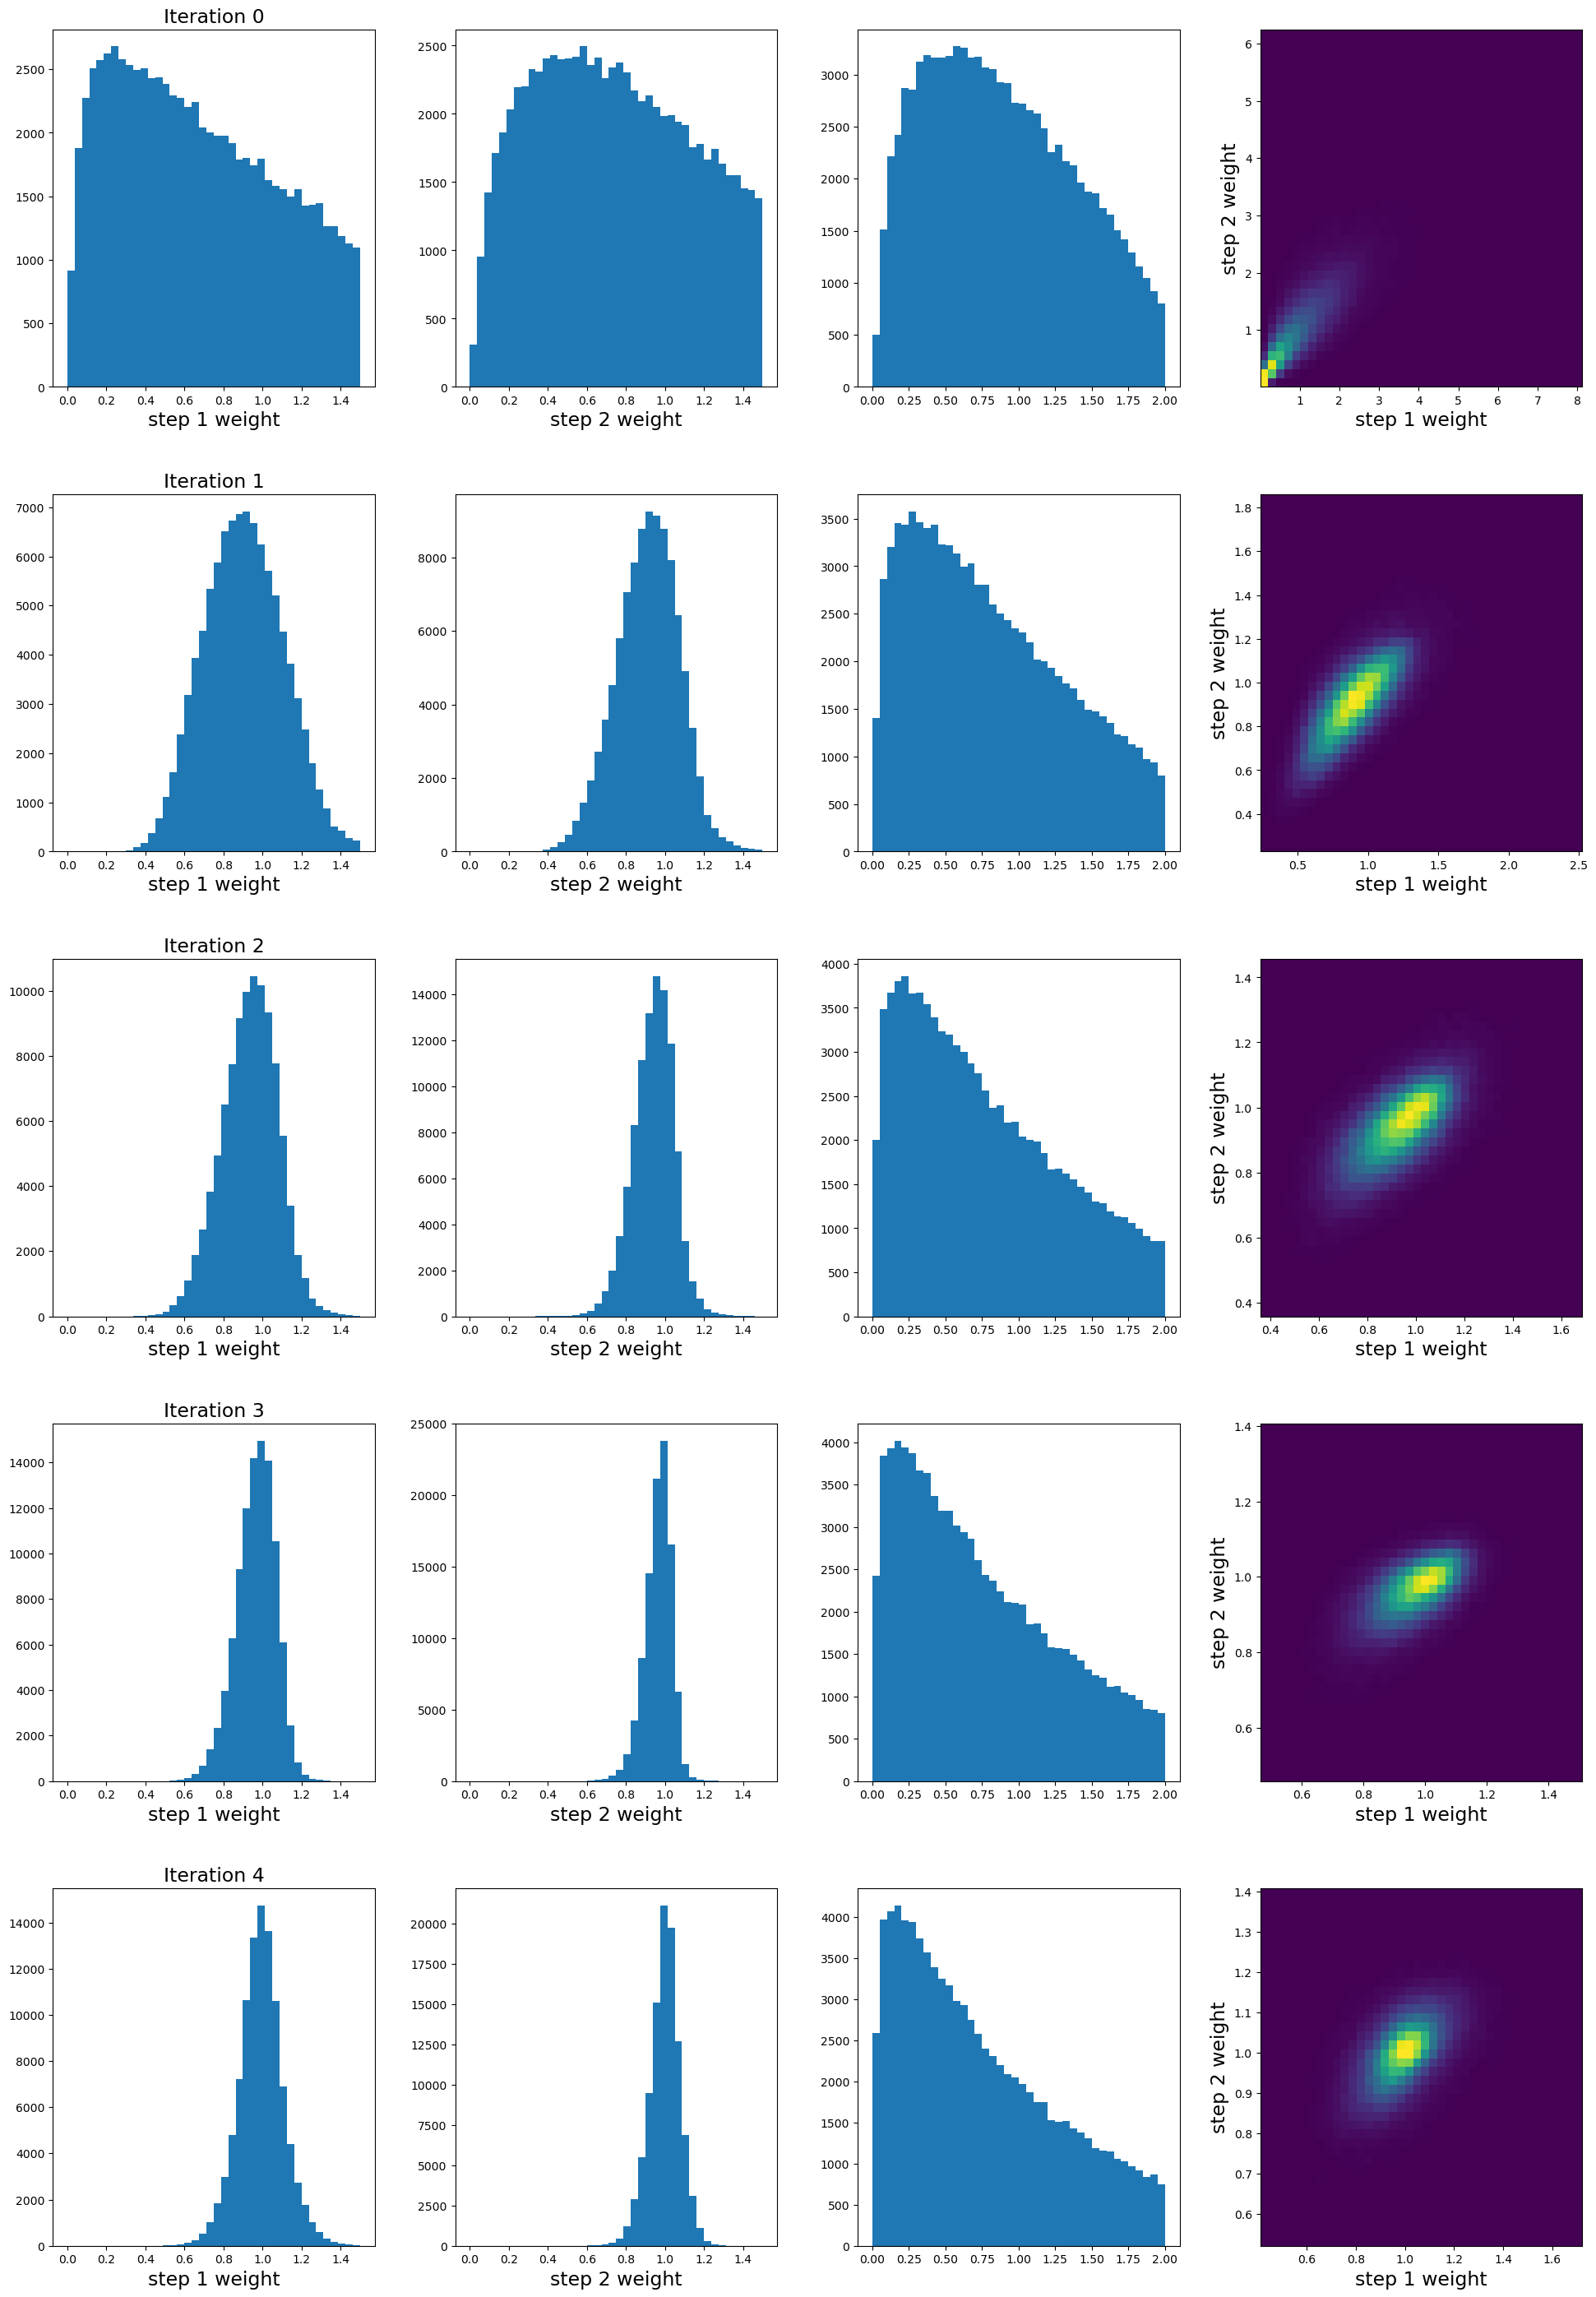

In [39]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.] )
    if ndim==1 :
        ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [40]:
if ndim==1 :
    
    fig,ax = plt.subplots( 1, 2, figsize=(2*6,6))

    hbins=200

    hpw,xe,ye,_ = ax[0].hist2d( mc_pts[:,0], push_weights[-1,:], 
                          bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

    hcw,_,_,_ = ax[1].hist2d( mc_pts[:,0], calc_weight, 
                          bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

    ax[0].plot([0,0],[0,1.5])
    ax[0].plot([-4.5,4.5],[1,1])

    ax[1].plot([0,0],[0,1.5])
    ax[1].plot([-4.5,4.5],[1,1])

    plt.show

In [41]:
if ndim==1 :
    
    ave_fpw, xvals = hist_to_func( hpw, xe, ye )
    
    calc_pw, xvals = hist_to_func( hcw, xe, ye )
    
    fig,ax = plt.subplots( 1, 1, figsize=(12,12))
    ax.plot(xvals, ave_fpw, label='OmniFold output function')
    ax.plot(xvals, calc_pw, label='Calculated true function')
    ax.plot([0,0],[0,1.3])
    
    ax.legend( fontsize=18 )
    
    ax.grid(True)
    
    ax.set_xlabel('Feature coordinate', fontsize=15)
    ax.set_ylabel('Event weight', fontsize=15)
    
    plt.show
    

<function matplotlib.pyplot.show(close=None, block=None)>

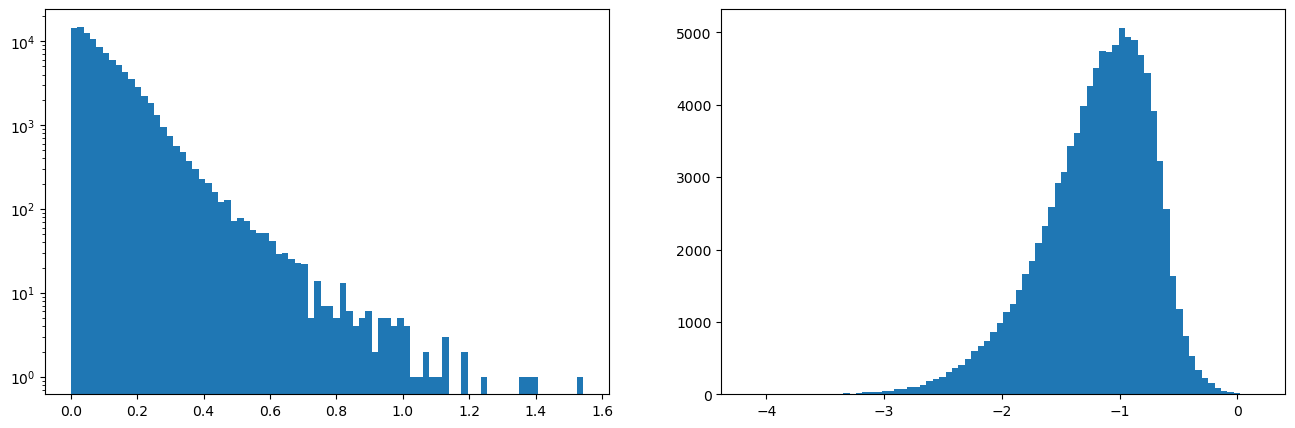

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

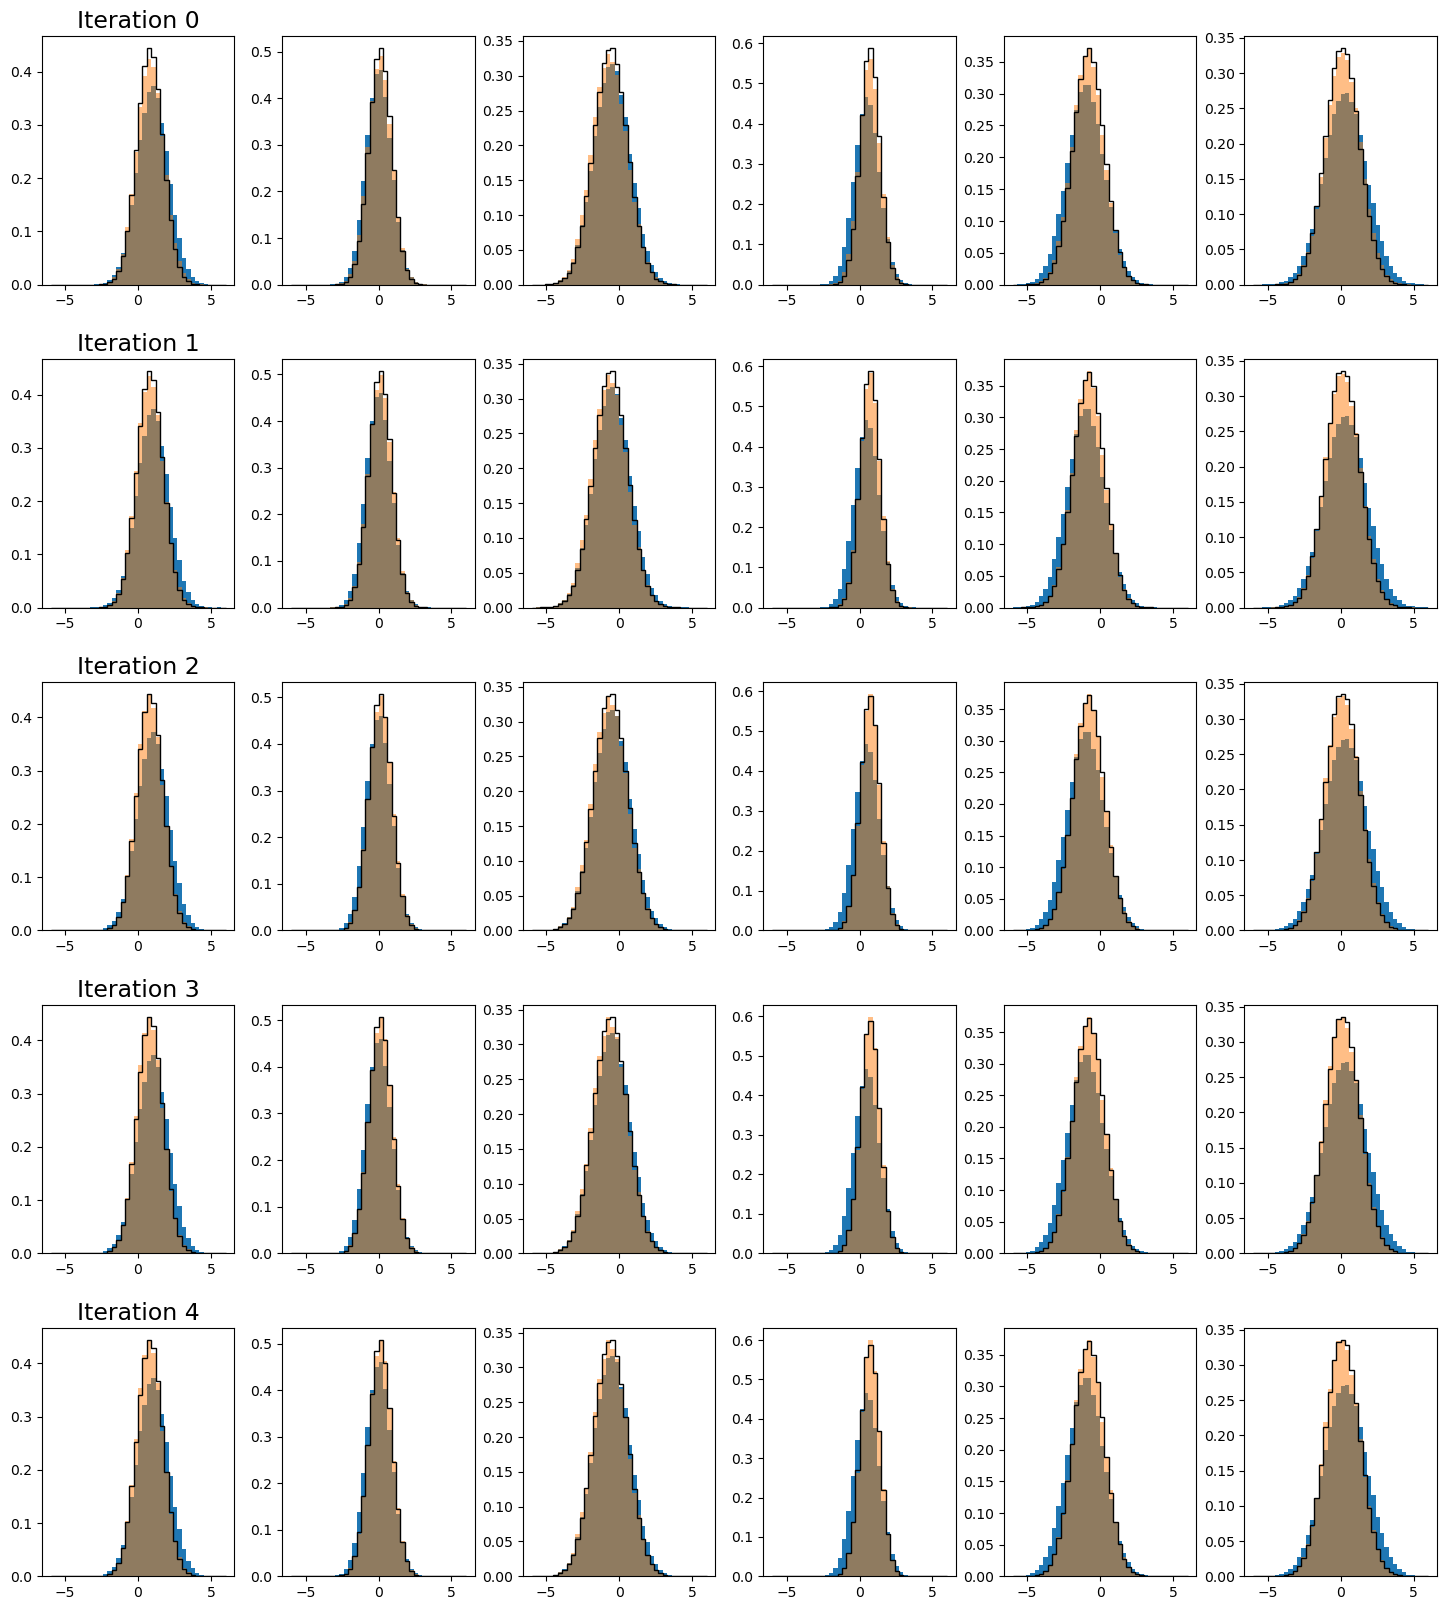

In [43]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( mc_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [44]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

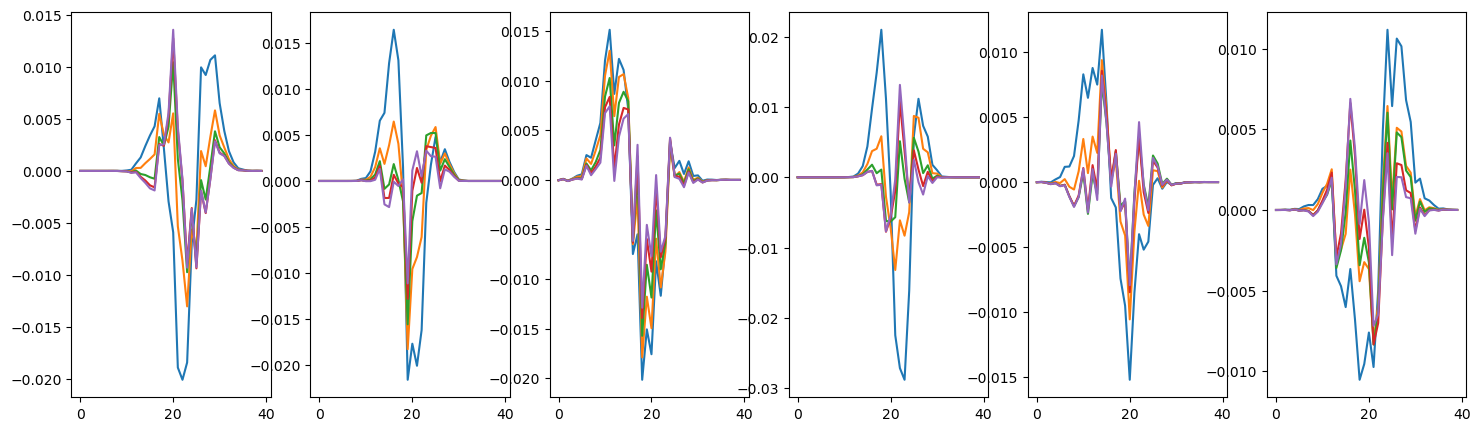

In [45]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

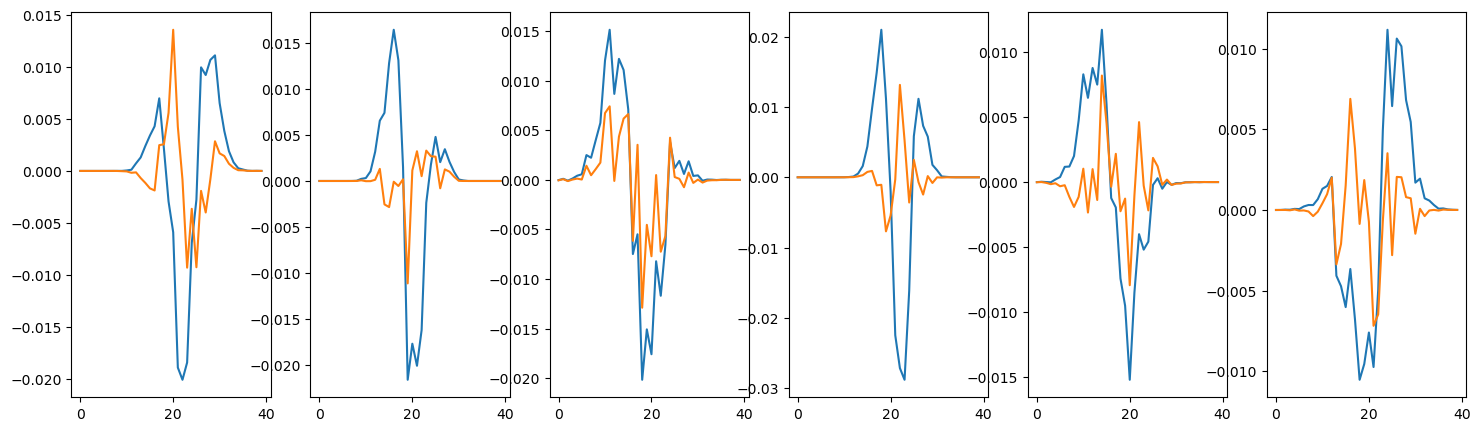

In [46]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

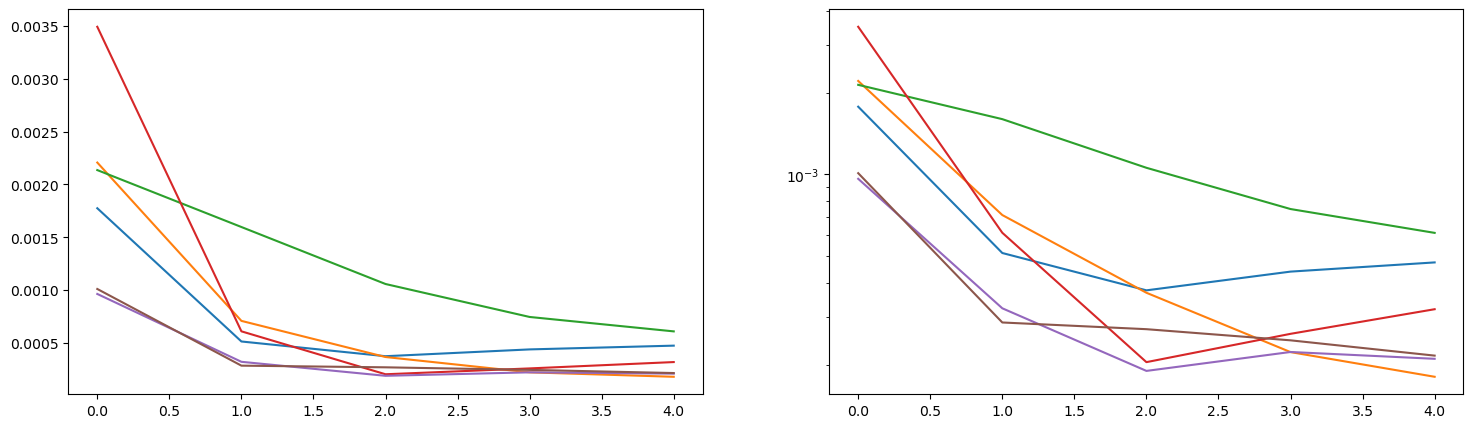

In [47]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [48]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.014  rms 0.801      step 2 mean  1.014  rms 0.666
  iter  1 : step 1 mean  0.910  rms 0.212      step 2 mean  0.913  rms 0.162
  iter  2 : step 1 mean  0.934  rms 0.143      step 2 mean  0.941  rms 0.105
  iter  3 : step 1 mean  0.966  rms 0.100      step 2 mean  0.965  rms 0.068
  iter  4 : step 1 mean  0.994  rms 0.116      step 2 mean  0.998  rms 0.078


<function matplotlib.pyplot.show(close=None, block=None)>

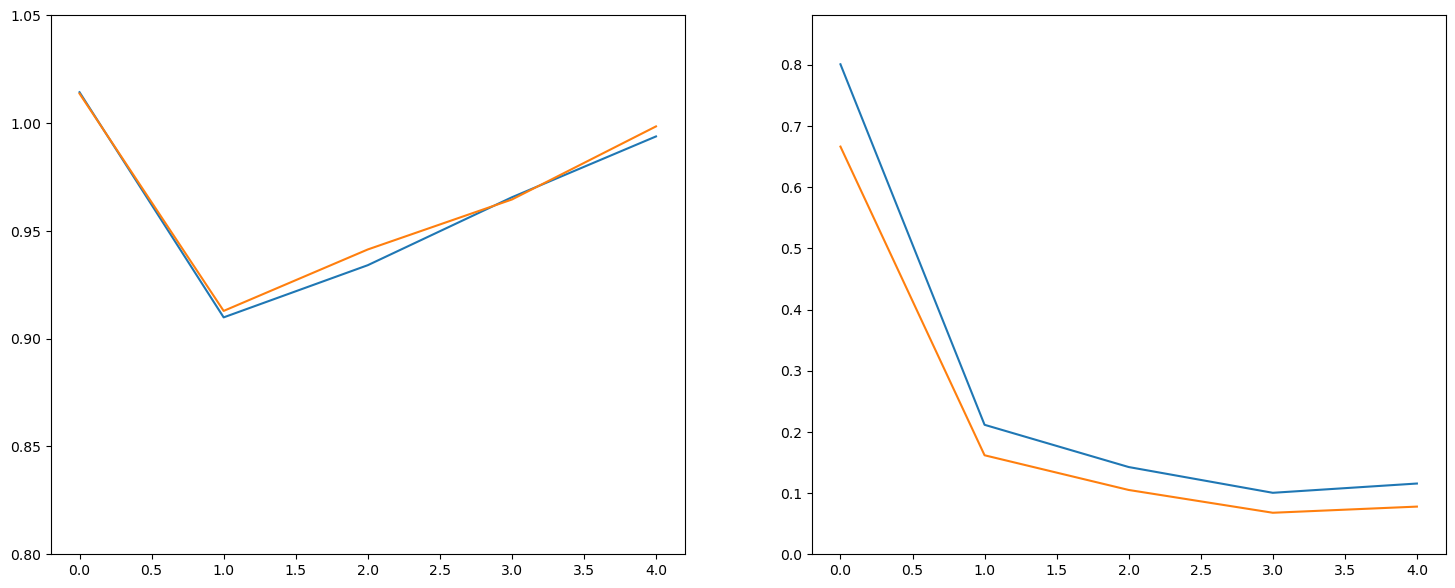

In [49]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

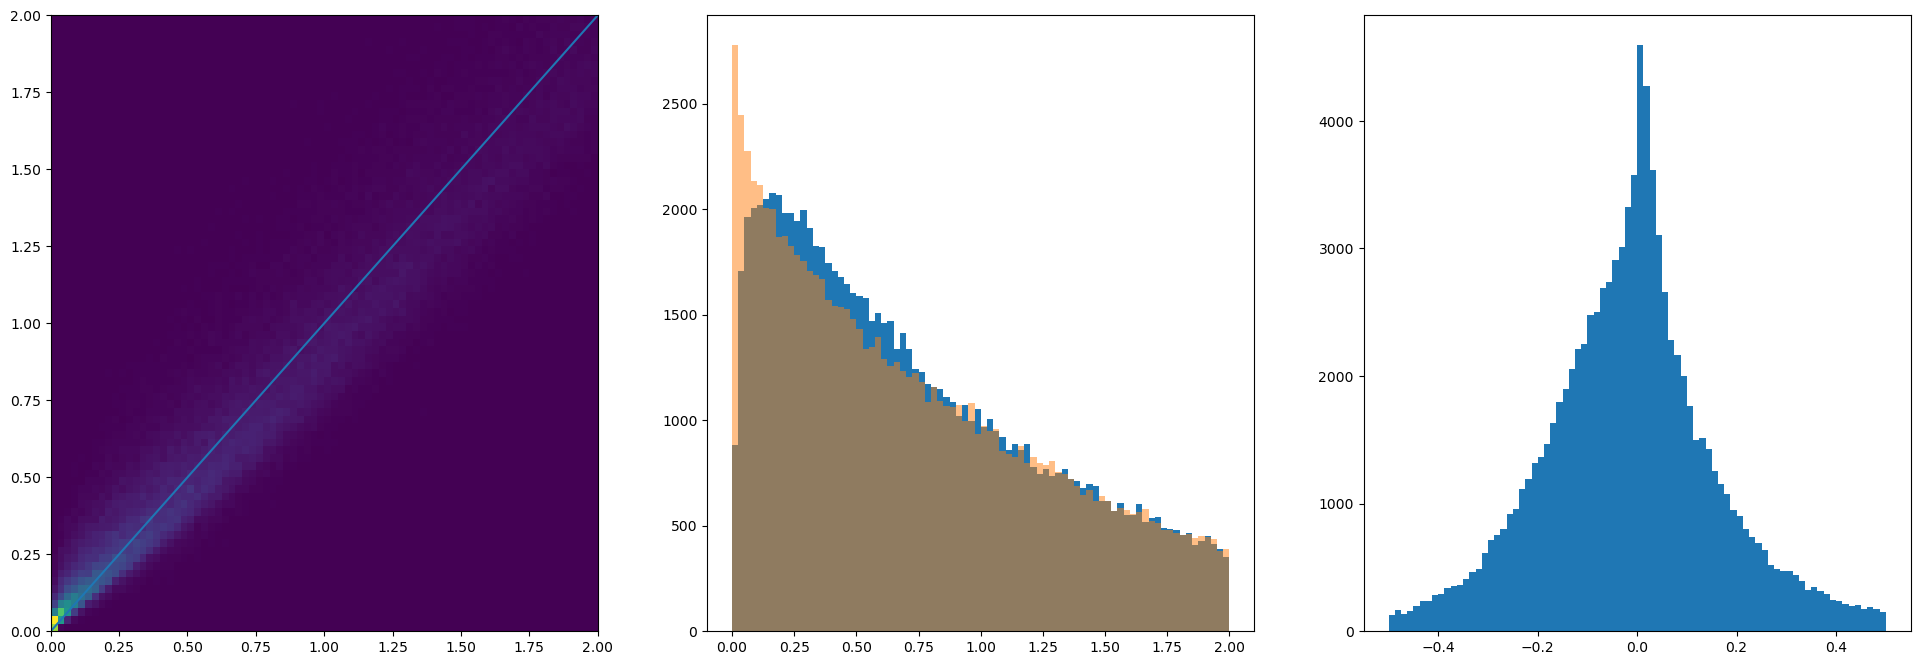

In [50]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [51]:
push_weights.shape

(5, 100000)

 Iteration 0:  delta weight  mean   0.0077, RMS   0.4735
 Iteration 1:  delta weight  mean  -0.0051, RMS   0.3525
 Iteration 2:  delta weight  mean  -0.0100, RMS   0.2998
 Iteration 3:  delta weight  mean  -0.0127, RMS   0.2816
 Iteration 4:  delta weight  mean  -0.0085, RMS   0.2796


<function matplotlib.pyplot.show(close=None, block=None)>

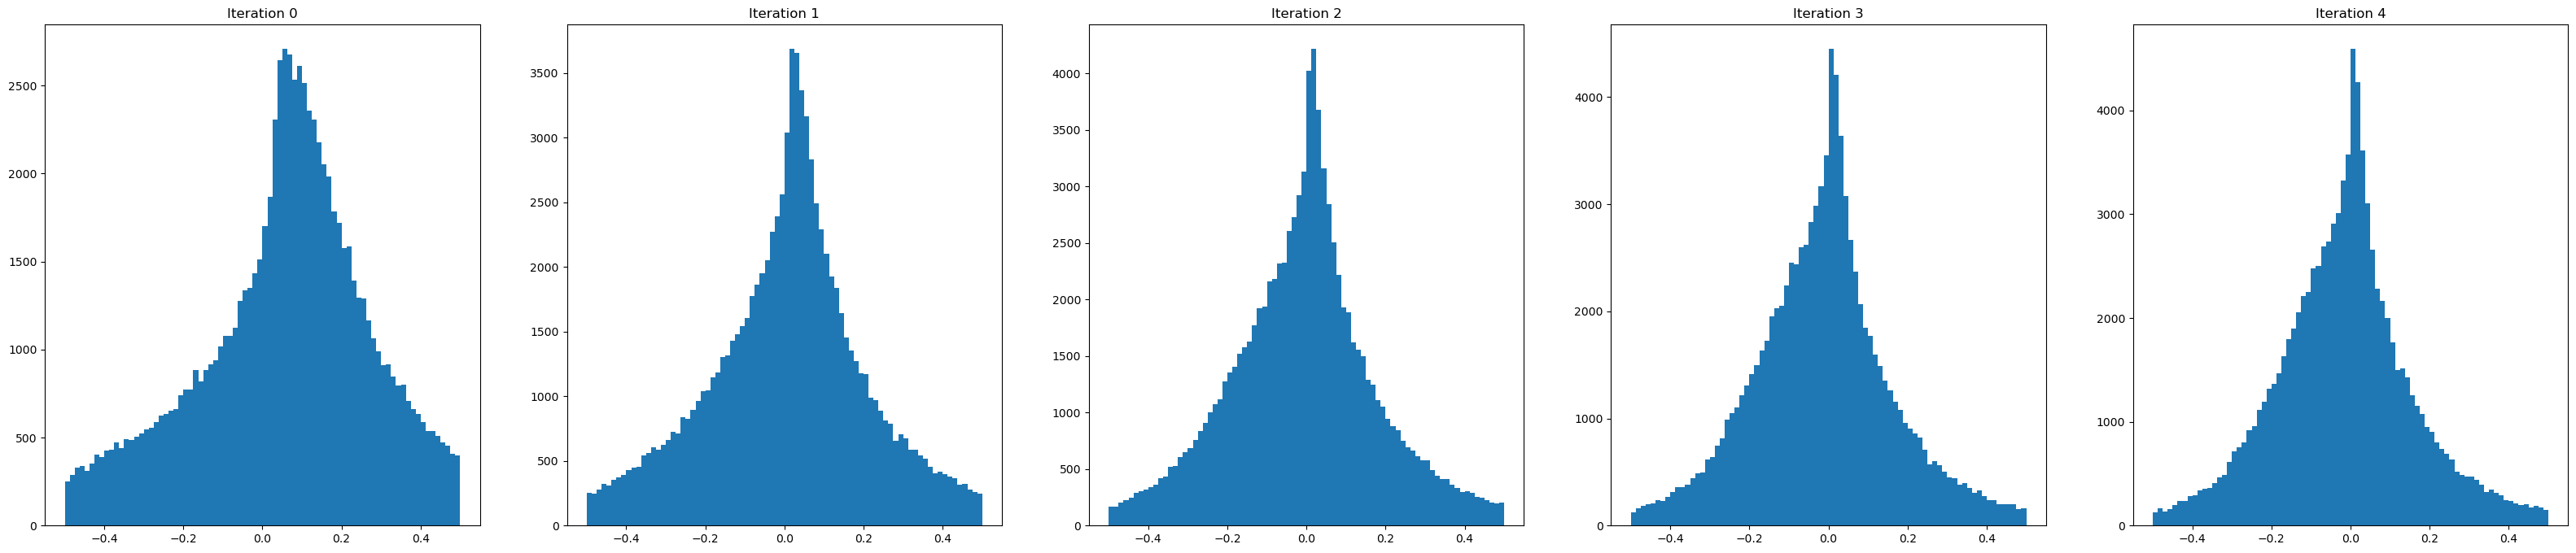

In [52]:
fig,ax = plt.subplots( 1, of_niter, figsize=(of_niter*8,1*8))

dw_mean = np.zeros( shape=(of_niter))
dw_rms = np.zeros( shape=(of_niter))

for i in range( of_niter ) :
    
    axi = ax[i]
    axi.hist( push_weights[i,:]-calc_weight, bins=80, range=[-0.5,0.5] )
    axi.set_title('Iteration %d' % i)
    
    dw_mean[i] = np.mean( push_weights[i,:]-calc_weight )
    dw_rms[i] = np.sqrt( np.cov(push_weights[i,:]-calc_weight))
    print(' Iteration %d:  delta weight  mean %8.4f, RMS %8.4f' % (i, dw_mean[i], dw_rms[i]))
    
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

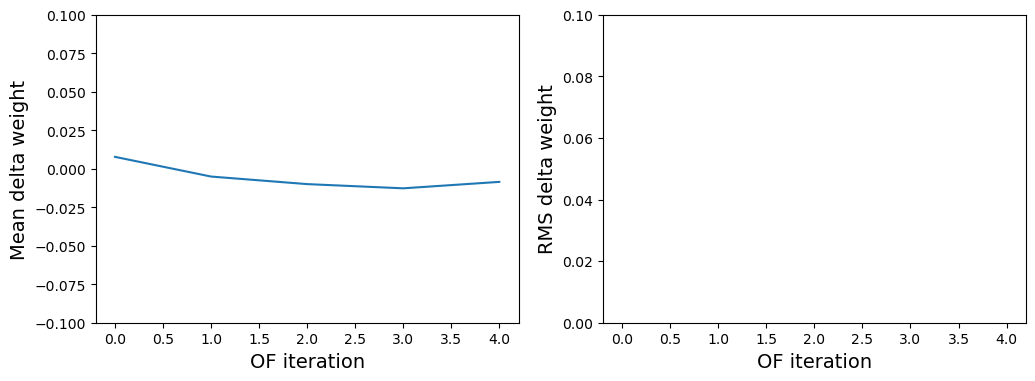

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(2*6,4))

axi=ax[0]
axi.plot( np.linspace(0,of_niter-1,of_niter), dw_mean )
axi.set_ylim([-0.1,0.1])
axi.set_xlabel('OF iteration', fontsize=14)
axi.set_ylabel('Mean delta weight', fontsize=14)

axi=ax[1]
axi.plot( np.linspace(0,of_niter-1,of_niter), dw_rms)
axi.set_ylim([0.0,0.1])
axi.set_xlabel('OF iteration', fontsize=14)
axi.set_ylabel('RMS delta weight', fontsize=14)


plt.show

In [54]:
def profile2d( axis, xvals, yvals, hbins, hrange, drawhist=True, drawline=False, drawcurve=True ) :
    
    hist_data = axis.hist2d( xvals, yvals, bins=hbins, range=hrange)
    
    if not drawhist :
        axis.cla()

    nybins = len(hist_data[0][0])
    #print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    #print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins ) :  
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    if drawcurve :
        axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, fmt='-', linewidth=5)

    
    plt.show
    
    return x_vals, avey_vals, rmsy_vals

In [55]:
ensemble_of_prob = of_return_dict['ensemble_weights'] / (1. + of_return_dict['ensemble_weights'])
ave_ensemble_of_prob = np.average( ensemble_of_prob, axis=0 )

In [56]:
ensemble_of_prob.shape

(10, 5, 2, 100000)

In [57]:
ensemble_of_prob[0,0,0,:]

array([0.22167145, 0.22988282, 0.70021349, ..., 0.67118667, 0.43986476,
       0.18705827])

In [58]:
if ndim==1 :
    
    fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))

    xmin = -4.5
    xmax = 4.5

    ymin = 0.2
    ymax = 0.6

    x = np.zeros(shape=(n_models_to_ensemble,200))
    y = np.zeros(shape=(n_models_to_ensemble,200))
    e = np.zeros(shape=(n_models_to_ensemble,200))


    for ofi in range( of_niter ) :

        for si in range( 2 ) :

            print(' OF iter %d, step %d ' % (ofi,si), end='')

            axi = ax[ofi,si]

            for ei in range(n_models_to_ensemble) :
                print('.', end='')
                x[ei,:],y[ei,:],e[ei,:] = profile2d( axi, mc_det_pts[:,0], ensemble_of_prob[ei,ofi,si,:], 
                  hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False, drawcurve=False ) 

            eax, eay, eae = profile2d( axi, mc_det_pts[:,0], ave_ensemble_of_prob[ofi,si,:], 
                  hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False, drawcurve=False )


            for ei in range(n_models_to_ensemble) :
                axi.errorbar( x[ei,:], y[ei,:], e[ei,:])

            axi.errorbar( eax, eay, eae, color='black', linewidth=2 )

            axi.plot([xmin,xmax],[0.5,0.5])



            print()


    plt.show


In [59]:
def prob_from_hists( points_a, points_b, weights_a, weights_b, hnbins, hxmin, hxmax ) :
    
    hbw = (hxmax-hxmin)/hnbins
    
    #-- calculate bin indices
    bin_indices_a = np.array( (points_a - hxmin)/hbw, dtype=int )
    bin_indices_b = np.array( (points_b - hxmin)/hbw, dtype=int )
    
    
    hist_binsum_a = np.zeros( hnbins )
    hist_binsum_b = np.zeros( hnbins )
    
    hist_err_a = np.zeros( hnbins )
    hist_err_b = np.zeros( hnbins )
    
    hist_ratio = np.zeros( hnbins )
    hist_ratio_err = np.zeros( hnbins )
    
    sample_wsum_a = np.sum(weights_a)
    sample_wsum_b = np.sum(weights_b)

    
    for bi in range( hnbins ) :
        hist_binsum_a[bi] = np.sum( weights_a[ bin_indices_a == bi ] ) / sample_wsum_a
        hist_binsum_b[bi] = np.sum( weights_b[ bin_indices_b == bi ] ) / sample_wsum_b
        hist_err_a[bi] = np.sqrt( np.sum( np.square( weights_a[ bin_indices_a == bi ] ) ) ) / sample_wsum_a
        hist_err_b[bi] = np.sqrt( np.sum( np.square( weights_b[ bin_indices_b == bi ] ) ) ) / sample_wsum_b
        if hist_binsum_b[bi] > 0 :
            hist_ratio[bi] = hist_binsum_b[bi] / (hist_binsum_a[bi] + hist_binsum_b[bi])
            if hist_binsum_a[bi] > 0 :
                hist_ratio_err[bi] = np.sqrt(
                    np.square( (hist_binsum_b[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_a[bi] ) +
                    np.square( (hist_binsum_a[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_b[bi] )
                )
        
    return_dict = {}
    return_dict['hist_binsum_a'] = hist_binsum_a
    return_dict['hist_binsum_b'] = hist_binsum_b
    return_dict['hist_err_a'] = hist_err_a
    return_dict['hist_err_b'] = hist_err_b
    return_dict['hist_ratio'] = hist_ratio
    return_dict['hist_ratio_err'] = hist_ratio_err
    
    return return_dict
    

## Examine the Likelihood Ratio output for Step 1 in OmniFold for each iteration

In [60]:

if ndim==1 :

    hxmin = -4.5
    hxmax = 4.5


    hnbins = 40



    hbw = (hxmax-hxmin) / hnbins

    xvals = np.zeros( hnbins )
    for bi in range( hnbins ) :
        xvals[bi] = hxmin + (0.5 + bi)*hbw

    nnbins = 1000

    plotymin=[0.30, 0.30, 0.40, 0.45, 0.45]
    plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]





    fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


    for ofi in range( of_niter ) :

        weights_ones_b = np.ones( len(true_det_pts[:,0]) )

        if ofi==0 :        
            weights_a = np.ones( len(mc_det_pts[:,0]) )        
        else :
            weights_a = of_return_dict['push_weights'][ofi-1]

        rd = prob_from_hists( mc_det_pts[:,0], 
                                 true_det_pts[:,0], 
                                 weights_a, 
                                 weights_ones_b, 
                                 hnbins, hxmin, hxmax )

        axi = ax[ofi][0]
        axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
        axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='Data')
        axi.legend( fontsize=22 )
        axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )

        axi = ax[ofi][1]
        profile2d( axi, mc_det_pts[:,0], ave_ensemble_of_prob[ofi,0,:], 
              hbins=[nnbins,nnbins], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
        axi.plot([hxmin,hxmax],[0.5,0.5])
        axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
        axi.legend( fontsize=22 )
        axi.set_ylabel('Likelihood ratio', fontsize=22 )

        axi.set_ylim( plotymin[ofi], plotymax[ofi] )
        axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )




    plt.show

In [61]:

if ndim==1 :

    hxmin = -4.5
    hxmax = 4.5


    hnbins = 40



    hbw = (hxmax-hxmin) / hnbins

    xvals = np.zeros( hnbins )
    for bi in range( hnbins ) :
        xvals[bi] = hxmin + (0.5 + bi)*hbw

    nnbins = 1000

    plotymin=[0.30, 0.40, 0.45, 0.45, 0.45]
    plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]






    fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


    for ofi in range( of_niter ) :

        previous_push_weights = np.ones( len(mc_pts[:,0]))
        if ofi > 0 :
            previous_push_weights = of_return_dict['push_weights'][ofi-1]

        #pull_weights = previous_push_weights * of_return_dict['weights'][ofi,0,:]



        rd = prob_from_hists( mc_pts[:,0], 
                                 mc_pts[:,0], 
                                 previous_push_weights, 
                                 pull_weights[ofi], 
                                 hnbins, hxmin, hxmax )

        axi = ax[ofi][0]
        axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
        axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='MC pull')
        axi.legend( fontsize=22 )
        axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )

        axi = ax[ofi][1]
        profile2d( axi, mc_pts[:,0], ave_ensemble_of_prob[ofi,1,:], 
              hbins=[nnbins,nnbins], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
        axi.plot([hxmin,hxmax],[0.5,0.5])
        axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
        axi.legend( fontsize=22 )
        axi.set_ylabel('Likelihood ratio', fontsize=22 )

        axi.set_ylim( plotymin[ofi], plotymax[ofi] )
        axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )




    plt.show

# Bootstrap / Toy MC below here

In [62]:

verbose = False



import gc

In [63]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [ ]:
%%time

rng = np.random.default_rng()

for bi in range(first_boot_sample_index,n_boot_samples) :
    
    this_random_seed = random_seed*10000+bi
    
    np.random.seed( this_random_seed )
    keras.utils.set_random_seed( this_random_seed )

    
    if do_bootstrap :
        print("\n\n\n\n ============= Creating bootstrap sample %3d,  seed %d" % (bi, this_random_seed) )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n\n\n\n\n ======================= Creating toy sample %3d,  this_ngen_true = %d, seed %d" % 
              (bi, this_ngen_true, this_random_seed) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        
  
        
    boot_of_return_dict = omnifold( 
        mc_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, 
        save_step2_model, modeldir, patience_setval, restore_best_weights_setval )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(mc_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    






 ======================= Creating toy sample 100,  this_ngen_true = 9934, seed 10100
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.38927838 0.22802357 2.36309958 ... 2.00185037 0.77488065 0.21740241]
 Ensemble  0, Iteration 0, step 2, weights
[0.49075565 0.37384096 1.30774081 ... 1.37033081 0.38663772 0.72325838]
 weights_push at the beginning
[0.49075565 0.37384096 1.30774081 ... 1.37033081 0.38663772 0.72325838]
 Ensemble  0, Iteration 1, step 1, weights
[0.76419467 0.63564312 1.01044738 ... 1.05692291 0.96181041 0.83710802]
 Ensemble  0, Iteration 1, step 2, weights
[0.71653903 0.68337208 0.83861065 ... 0.95452178 0.8074047  0.96621144]
 weights_push at the beginning
[0.35164557 0.25547247 1.09668537 ... 1.3080106  0.31217311 0.69882052]
 Ensemble  0, Iteration 2, step 1, weights
[0.886

 Ensemble  4, Iteration 3, step 1, weights
[0.8155247  0.67572308 1.0502187  ... 1.0631305  0.94004744 0.97067595]
 Ensemble  4, Iteration 3, step 2, weights
[0.81285471 0.73719299 0.88027728 ... 1.01705861 0.88364172 1.02917397]
 weights_push at the beginning
[0.21759749 0.1645964  0.83917011 ... 1.57080655 0.26653104 0.6351894 ]
 Ensemble  4, Iteration 4, step 1, weights
[0.954005   1.00356781 1.004143   ... 1.01682293 0.95882827 0.93761283]
 Ensemble  4, Iteration 4, step 2, weights
[0.91588622 0.91612124 0.91808659 ... 1.0144943  0.93060184 1.05939913]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.35514113 0.27081949 2.16780043 ... 2.15619874 0.85868001 0.22998947]
 Ensemble  5, Iteration 0, step 2, weights
[0.50668132 0.33990502 1.25067174 ... 1.43779159 0.35562551 0.56299704]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.74119109 0.68740499 0.87125206 ... 1.05340552 0.83421922 0.89357865]
 weights_push at the beginning
[0.29903888 0.25283581 1.05968218 ... 1.55865267 0.25854392 0.58589451]
 Ensemble  9, Iteration 2, step 1, weights
[0.83882695 0.7033301  0.9588629  ... 1.1438638  0.94021893 0.73192704]
 Ensemble  9, Iteration 2, step 2, weights
[0.82428348 0.76075751 0.95636964 ... 1.08939254 0.89472759 0.9918257 ]
 weights_push at the beginning
[0.24649281 0.19234674 1.01344787 ... 1.69798459 0.23132637 0.58110523]
 Ensemble  9, Iteration 3, step 1, weights
[0.83346736 0.82221293 1.00415373 ... 1.0397253  1.01709914 0.89297158]
 Ensemble  9, Iteration 3, step 2, weights
[0.82444012 0.82334071 0.92720443 ... 0.95226187 1.00050199 1.0858047 ]
 weights_push at the beginning
[0.20321856 0.1583669  0.93967335 ... 1.61692598 0.2314425  0.6309668 ]
 Ensemble  9, Iteration 4, step 1, weights
[0.98120707 0.80984104 0.85898656 ... 1.01246858 0.86425984 0.64368403]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.83016366 0.80850905 0.91923702 ... 0.95292652 1.04897201 1.18649065]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.33439419 0.23859298 2.02423286 ... 1.9170208  0.93737602 0.28662503]
 Ensemble  4, Iteration 0, step 2, weights
[0.41143492 0.33033592 1.31772017 ... 1.57376623 0.47723818 0.63114631]
 weights_push at the beginning
[0.41143492 0.33033592 1.31772017 ... 1.57376623 0.47723818 0.63114631]
 Ensemble  4, Iteration 1, step 1, weights
[0.72922772 0.64045906 1.12101495 ... 1.20681643 0.98474538 0.95954901]
 Ensemble  4, Iteration 1, step 2, weights
[0.76042145 0.68767315 0.93130767 ... 1.14498925 0.84112436 0.934066  ]
 weights_push at the beginning
[0.31286394 0.22716314 1.22720291 ... 1.80194542 0.40141666 0.58953231]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.85100812 0.7658577  0.82541382 ... 1.13140798 1.01894581 1.20555449]
 Ensemble  8, Iteration 3, step 2, weights
[0.84088314 0.91473013 0.9377113  ... 1.05748928 0.98871714 1.07190657]
 weights_push at the beginning
[0.21628039 0.1603275  0.94735625 ... 1.85791386 0.58838306 0.57872908]
 Ensemble  8, Iteration 4, step 1, weights
[0.80997854 0.64336288 0.99716753 ... 1.10830152 0.95178455 0.89477873]
 Ensemble  8, Iteration 4, step 2, weights
[0.82067597 0.81670535 0.99719924 ... 1.02039587 0.94074994 0.9458586 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.30496347 0.21248926 2.13713026 ... 2.28198123 1.00754404 0.47347027]
 Ensemble  9, Iteration 0, step 2, weights
[0.41331977 0.35123527 1.17753518 ... 1.61429274 0.43735448 0.55351669]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.63804901 0.6556285  1.02364612 ... 1.15768504 1.07058311 0.79427117]
 Ensemble  3, Iteration 1, step 2, weights
[0.67520976 0.67995554 0.8496834  ... 0.98131114 0.92489862 0.97638363]
 weights_push at the beginning
[0.28476634 0.31771005 1.13360893 ... 1.51682464 0.60392831 0.8179072 ]
 Ensemble  3, Iteration 2, step 1, weights
[0.8419264  0.9322077  0.95937741 ... 1.12834227 1.0820713  0.85077333]
 Ensemble  3, Iteration 2, step 2, weights
[0.88696784 0.90801442 0.85846108 ... 1.08325279 1.04688811 0.87638897]
 weights_push at the beginning
[0.25257859 0.28848531 0.97315914 ... 1.64310452 0.63224537 0.71680485]
 Ensemble  3, Iteration 3, step 1, weights
[0.9183358  0.94093752 0.96662307 ... 1.12172425 1.02087092 1.0511049 ]
 Ensemble  3, Iteration 3, step 2, weights
[0.90011507 0.95259422 0.89884895 ... 1.12115014 0.9772585  1.07565725]
 weights_push at the beginning
[0.22734979 0.27480944 0.87472308 ... 1.84216685 0.61786717 0.77103633]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.35476768 0.40562263 2.18034482 ... 2.13094568 1.46873808 0.28236964]
 Ensemble  8, Iteration 0, step 2, weights
[0.52562481 0.4808909  1.23696983 ... 1.68028438 0.59312934 0.60038215]
 weights_push at the beginning
[0.52562481 0.4808909  1.23696983 ... 1.68028438 0.59312934 0.60038215]
 Ensemble  8, Iteration 1, step 1, weights
[0.76568973 0.87044829 1.08920574 ... 1.19770992 1.13933647 0.66166675]
 Ensemble  8, Iteration 1, step 2, weights
[0.78937203 0.86956012 0.80368382 ... 1.046749   0.86997575 0.91434216]
 weights_push at the beginning
[0.41491352 0.41816355 0.99413263 ... 1.75883599 0.51600814 0.54895471]
 Ensemble  8, Iteration 2, step 1, weights
[0.81926233 0.74575102 1.19559598 ... 1.14591062 1.19084966 1.07403374]
 Ensemble  8, Iteration 2, step 2, weights
[0.92039585 0.87769675 0.93188328 ... 0.96415561 1.08655465 1.09482932]
 weights_push at the beginning
[0.38188469 0.36702079 0.92641558 ... 1.69579159 0.56067104 0.60101172]
 

 Ensemble  2, Iteration 3, step 1, weights
[0.89443177 0.85370702 1.06651926 ... 0.97775298 0.95893353 0.6301868 ]
 Ensemble  2, Iteration 3, step 2, weights
[0.9004907  0.93915546 0.93234348 ... 0.93891704 0.84398144 0.94769651]
 weights_push at the beginning
[0.21966924 0.19962484 0.85438352 ... 1.62415573 0.39812342 0.74933352]
 Ensemble  2, Iteration 4, step 1, weights
[0.9821738  0.83848947 0.99395794 ... 1.09076679 0.98136663 0.73609143]
 Ensemble  2, Iteration 4, step 2, weights
[1.03616524 0.99154955 0.89347667 ... 1.03303003 0.92176431 0.9464035 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.37406397 0.20461613 2.54014826 ... 1.92755878 0.69545329 0.68687069]
 Ensemble  3, Iteration 0, step 2, weights
[0.43494818 0.36741093 1.27241087 ... 1.55766225 0.40902409 0.7501955 ]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.69832468 0.61800289 0.89725894 ... 1.07634878 0.86148226 0.96946973]
 weights_push at the beginning
[0.25047706 0.25030852 1.11959734 ... 1.58369356 0.35467467 0.62046252]
 Ensemble  7, Iteration 2, step 1, weights
[0.76921773 0.65042651 1.0537262  ... 1.03834867 0.95407099 1.02674389]
 Ensemble  7, Iteration 2, step 2, weights
[0.77218539 0.77380711 0.88740283 ... 0.99244004 0.93836004 1.02548385]
 weights_push at the beginning
[0.19341472 0.19369051 0.99353385 ... 1.57172091 0.33281254 0.63627429]
 Ensemble  7, Iteration 3, step 1, weights
[0.80903494 0.72833192 1.02135861 ... 1.04214382 0.92108101 1.08533049]
 Ensemble  7, Iteration 3, step 2, weights
[0.85486001 0.88305712 0.926696   ... 1.031093   0.99549574 0.98577291]
 weights_push at the beginning
[0.16534251 0.17103979 0.92070385 ... 1.62059043 0.33131346 0.62722196]
 Ensemble  7, Iteration 4, step 1, weights
[0.72454828 0.8129971  0.97614378 ... 0.97694927 0.96195239 1.03908944]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.87200606 0.9720639  0.91360646 ... 0.98359185 1.16814041 1.11473393]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.52307218 0.2740733  2.5957284  ... 1.86664081 1.05499005 0.14511743]
 Ensemble  2, Iteration 0, step 2, weights
[0.51574844 0.48071194 1.42748964 ... 1.52062368 0.6390239  0.64121705]
 weights_push at the beginning
[0.51574844 0.48071194 1.42748964 ... 1.52062368 0.6390239  0.64121705]
 Ensemble  2, Iteration 1, step 1, weights
[0.66656125 0.50716341 1.12242258 ... 1.06267643 0.83896464 0.8022067 ]
 Ensemble  2, Iteration 1, step 2, weights
[0.62634569 0.6689682  0.88093823 ... 1.05418694 0.73430771 0.94622332]
 weights_push at the beginning
[0.32303682 0.321581   1.2575302  ... 1.60302163 0.46924017 0.60673453]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.9126159  0.76010561 1.03634346 ... 0.98310179 1.02670228 0.88477677]
 Ensemble  6, Iteration 3, step 2, weights
[0.92252392 0.92027766 0.91173035 ... 0.96120709 1.01615334 0.95251739]
 weights_push at the beginning
[0.38514009 0.27264066 1.04443554 ... 1.8109922  0.52962557 0.38904503]
 Ensemble  6, Iteration 4, step 1, weights
[0.88586527 0.75561661 1.06978142 ... 0.96751881 0.96858799 1.20075417]
 Ensemble  6, Iteration 4, step 2, weights
[0.87155187 0.8854025  0.94827694 ... 1.03824019 0.95621955 1.10279274]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.4594048  0.429694   2.44372582 ... 2.4393785  0.86411726 0.24696246]
 Ensemble  7, Iteration 0, step 2, weights
[0.50933951 0.50942761 1.29269886 ... 1.67821777 0.42260978 0.54687274]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.65549719 0.61871934 1.09138453 ... 1.16711044 0.99435633 0.91334248]
 Ensemble  1, Iteration 1, step 2, weights
[0.63407314 0.68349302 0.89527613 ... 1.09269798 0.93045413 0.98280239]
 weights_push at the beginning
[0.2519704  0.24556127 1.04590161 ... 2.20465043 0.48083334 0.81828537]
 Ensemble  1, Iteration 2, step 1, weights
[1.02529061 0.75377369 1.0619626  ... 1.22052586 1.0430336  0.88561302]
 Ensemble  1, Iteration 2, step 2, weights
[0.91808051 0.86861974 0.9644143  ... 1.17263365 0.95656455 1.0212059 ]
 weights_push at the beginning
[0.23132911 0.21329937 1.00868247 ... 2.58524728 0.45994812 0.83563785]
 Ensemble  1, Iteration 3, step 1, weights
[1.01100314 0.76814085 0.89065051 ... 1.08977306 0.99036753 0.75765997]
 Ensemble  1, Iteration 3, step 2, weights
[0.92101032 0.83100152 0.87550741 ... 1.06974447 0.96527058 0.98951244]
 weights_push at the beginning
[0.2130565  0.1772521  0.88310898 ... 2.76555397 0.44397439 0.82687405]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.31949571 0.23258698 2.32371163 ... 2.31532383 0.93626124 0.50887513]
 Ensemble  6, Iteration 0, step 2, weights
[0.48609269 0.37545624 1.24353063 ... 1.94093335 0.53104305 0.76102275]
 weights_push at the beginning
[0.48609269 0.37545624 1.24353063 ... 1.94093335 0.53104305 0.76102275]
 Ensemble  6, Iteration 1, step 1, weights
[0.62226164 0.62677413 1.1420269  ... 1.20590246 1.01516402 0.84884554]
 Ensemble  6, Iteration 1, step 2, weights
[0.67168045 0.67114836 0.88774389 ... 1.1362896  0.91009283 0.93504858]
 weights_push at the beginning
[0.32649895 0.25198684 1.10393672 ... 2.20546237 0.48329848 0.71159324]
 Ensemble  6, Iteration 2, step 1, weights
[0.74371487 0.75105894 0.97788417 ... 1.14123166 0.97937942 1.10364628]
 Ensemble  6, Iteration 2, step 2, weights
[0.7448132  0.77318597 0.92263937 ... 1.1290735  1.04018092 1.01459026]
 weights_push at the beginning
[0.24318073 0.19483269 1.01853548 ... 2.49012912 0.50271785 0.72197557]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.84872437 0.89021289 1.03610528 ... 1.06598198 1.03668487 0.74366242]
 Ensemble  0, Iteration 3, step 2, weights
[0.85733926 0.93443948 0.98299032 ... 1.0093497  0.92490208 1.02384996]
 weights_push at the beginning
[0.29381159 0.22458552 0.95247786 ... 1.80985729 0.30534082 0.71416797]
 Ensemble  0, Iteration 4, step 1, weights
[0.89251018 0.92792195 0.93456888 ... 1.06974649 1.02998269 0.59279507]
 Ensemble  0, Iteration 4, step 2, weights
[0.92318636 0.92352962 0.96735984 ... 1.03402627 0.9860962  1.02384329]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.27616543 0.30034786 2.23091531 ... 2.31799173 0.90502417 0.61869079]
 Ensemble  1, Iteration 0, step 2, weights
[0.5072754  0.37978175 1.13575745 ... 1.62075126 0.41181672 0.85204613]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.62878144 0.65132666 0.87614977 ... 1.12413538 0.77018887 0.90396702]
 weights_push at the beginning
[0.25312894 0.27387974 0.94982656 ... 1.81063226 0.25839249 0.75869794]
 Ensemble  5, Iteration 2, step 1, weights
[0.74975151 0.64607787 0.95481604 ... 1.07790232 1.06092632 0.92659038]
 Ensemble  5, Iteration 2, step 2, weights
[0.69123733 0.73805487 0.86011028 ... 1.09532118 0.89516675 0.93873215]
 weights_push at the beginning
[0.17497217 0.20213828 0.81695559 ... 1.98322387 0.23130437 0.71221415]
 Ensemble  5, Iteration 3, step 1, weights
[0.84400386 0.72126424 1.01441956 ... 1.03315485 1.12935233 0.83415747]
 Ensemble  5, Iteration 3, step 2, weights
[0.86469346 0.8398096  0.85997558 ... 0.97378355 1.06045878 1.03638077]
 weights_push at the beginning
[0.1512973  0.16975766 0.70256186 ... 1.93123078 0.24528875 0.73812504]
 Ensemble  5, Iteration 4, step 1, weights
[0.8895151  0.8504656  1.00480521 ... 1.08963919 0.96208638 0.77186018]
 






 ======================= Creating toy sample 107,  this_ngen_true = 10178, seed 10107
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.39111635 0.30022764 2.65027833 ... 2.30570555 1.10955667 0.49369469]
 Ensemble  0, Iteration 0, step 2, weights
[0.4286395  0.4659653  1.26142347 ... 1.48655415 0.47431791 0.50859648]
 weights_push at the beginning
[0.4286395  0.4659653  1.26142347 ... 1.48655415 0.47431791 0.50859648]
 Ensemble  0, Iteration 1, step 1, weights
[0.7552309  0.61796784 1.18762934 ... 1.23687828 1.01523137 0.81462026]
 Ensemble  0, Iteration 1, step 2, weights
[0.63705927 0.66965652 0.88671654 ... 1.0563103  0.7805016  0.88787431]
 weights_push at the beginning
[0.27306877 0.3120367  1.11852506 ... 1.57026245 0.37020589 0.45156975]
 Ensemble  0, Iteration 2, step 1, weights
[0.88

 Ensemble  4, Iteration 3, step 1, weights
[1.03818429 0.81340063 1.06707883 ... 1.09961772 1.04715288 0.88306195]
 Ensemble  4, Iteration 3, step 2, weights
[0.96120793 0.88559675 0.88815814 ... 1.0286305  0.99251151 0.87117147]
 weights_push at the beginning
[0.34845549 0.2055222  0.86036943 ... 1.49444896 0.24470554 0.43559402]
 Ensemble  4, Iteration 4, step 1, weights
[0.91416156 0.67645353 1.01990581 ... 1.15013814 1.09139931 1.09675419]
 Ensemble  4, Iteration 4, step 2, weights
[0.86804765 0.79887766 0.89991426 ... 1.0780642  1.01073992 0.98090714]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.41627669 0.39564291 2.44269776 ... 2.47944713 0.74661261 0.3828679 ]
 Ensemble  5, Iteration 0, step 2, weights
[0.49605614 0.49210471 1.49075067 ... 1.62480175 0.44137606 0.52688062]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.80674469 0.74592513 0.92754662 ... 1.15148509 0.83468598 0.92264837]
 weights_push at the beginning
[0.45518366 0.30762217 0.99251949 ... 1.87749268 0.32080079 0.59009915]
 Ensemble  9, Iteration 2, step 1, weights
[0.84571606 0.80979925 1.01128662 ... 1.10438633 1.03056252 1.08564734]
 Ensemble  9, Iteration 2, step 2, weights
[0.86217755 0.84027231 0.88839424 ... 1.04653251 0.93891615 1.08140337]
 weights_push at the beginning
[0.39244914 0.25848639 0.8817486  ... 1.96485713 0.30120504 0.63813521]
 Ensemble  9, Iteration 3, step 1, weights
[0.90021384 0.87262303 0.97619247 ... 1.08829713 1.06292701 0.74283028]
 Ensemble  9, Iteration 3, step 2, weights
[0.80580598 0.83843297 0.90528286 ... 0.9444924  0.99655032 0.87817419]
 weights_push at the beginning
[0.31623786 0.21672351 0.79823189 ... 1.85579262 0.30016598 0.56039387]
 Ensemble  9, Iteration 4, step 1, weights
[0.97253513 0.83964133 1.0485909  ... 1.01183963 1.00768042 0.84441429]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.84545666 0.83971035 0.87003839 ... 1.00048339 0.98085922 0.9698301 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.34003451 0.22132322 2.48046207 ... 2.15615058 0.6452865  0.30299717]
 Ensemble  4, Iteration 0, step 2, weights
[0.45895267 0.35120022 1.46415496 ... 1.65655971 0.34385699 0.69597471]
 weights_push at the beginning
[0.45895267 0.35120022 1.46415496 ... 1.65655971 0.34385699 0.69597471]
 Ensemble  4, Iteration 1, step 1, weights
[0.71451962 0.56104147 1.0811578  ... 1.21816921 0.93097436 0.55117196]
 Ensemble  4, Iteration 1, step 2, weights
[0.64127421 0.66533184 0.858477   ... 1.02471745 0.79328674 0.84198809]
 weights_push at the beginning
[0.29431451 0.23366469 1.25694335 ... 1.69750564 0.27277719 0.58600241]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.83601272 0.81784528 0.94876617 ... 0.97672909 0.94110131 0.54503316]
 Ensemble  8, Iteration 3, step 2, weights
[0.85417509 0.83120269 0.94759542 ... 0.96215838 0.96627057 0.88904488]
 weights_push at the beginning
[0.23810526 0.13216697 0.96745697 ... 1.5974427  0.28713665 0.68409333]
 Ensemble  8, Iteration 4, step 1, weights
[0.85370857 0.9254151  0.85294151 ... 1.00115323 0.91537344 0.55220795]
 Ensemble  8, Iteration 4, step 2, weights
[0.83271378 0.86852509 0.89327896 ... 0.99803638 0.9507513  0.95361978]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.32144532 0.26114291 2.5977664  ... 1.98502648 0.85387611 0.43230307]
 Ensemble  9, Iteration 0, step 2, weights
[0.42935014 0.32974088 1.37719548 ... 1.43129206 0.39013857 0.77666837]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.92402244 0.67316926 0.9795509  ... 1.35259104 0.86905861 0.81196463]
 Ensemble  3, Iteration 1, step 2, weights
[0.8400507  0.74495977 0.88490516 ... 1.11735129 0.73257357 0.96492124]
 weights_push at the beginning
[0.35235179 0.29831833 1.18081686 ... 1.81373317 0.27113425 0.5808119 ]
 Ensemble  3, Iteration 2, step 1, weights
[0.85296053 0.80551791 0.99236596 ... 1.20909894 1.0780338  0.75942874]
 Ensemble  3, Iteration 2, step 2, weights
[0.80066252 0.8698771  0.95063061 ... 1.08221674 0.9401412  0.95373201]
 weights_push at the beginning
[0.28211487 0.25950029 1.12252065 ... 1.9628524  0.25490448 0.5539389 ]
 Ensemble  3, Iteration 3, step 1, weights
[0.96426773 0.84845078 1.02117574 ... 1.12301672 1.08330917 0.72107792]
 Ensemble  3, Iteration 3, step 2, weights
[0.92629981 0.93137127 0.94362843 ... 1.12087476 0.97365785 0.84960097]
 weights_push at the beginning
[0.26132295 0.24169111 1.0592424  ... 2.20011172 0.24818974 0.47062703]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.26613396 0.21304677 2.30506921 ... 2.42595553 0.75746447 0.1111987 ]
 Ensemble  8, Iteration 0, step 2, weights
[0.57754439 0.43422419 1.39120102 ... 1.76981378 0.42835844 0.64269108]
 weights_push at the beginning
[0.57754439 0.43422419 1.39120102 ... 1.76981378 0.42835844 0.64269108]
 Ensemble  8, Iteration 1, step 1, weights
[0.68542176 0.546381   0.98711616 ... 1.21996641 1.00383687 0.54940063]
 Ensemble  8, Iteration 1, step 2, weights
[0.73591864 0.64593655 0.8269462  ... 1.11418092 0.92274708 0.84864503]
 weights_push at the beginning
[0.42502568 0.28048127 1.15044839 ... 1.97189275 0.39526649 0.54541659]
 Ensemble  8, Iteration 2, step 1, weights
[0.77362412 0.72084403 1.09651232 ... 1.18469095 1.06759119 0.57352972]
 Ensemble  8, Iteration 2, step 2, weights
[0.84087181 0.84934479 0.92442036 ... 1.08492231 0.98337293 0.96012849]
 weights_push at the beginning
[0.35739212 0.23822531 1.06349792 ... 2.13935044 0.38869437 0.52367   ]
 

 Ensemble  2, Iteration 3, step 1, weights
[0.88813418 0.76676667 0.94854522 ... 1.11516583 1.09870982 0.54478282]
 Ensemble  2, Iteration 3, step 2, weights
[0.81207323 0.79857856 0.91841847 ... 1.09925258 0.96511078 0.89218509]
 weights_push at the beginning
[0.26227808 0.174489   0.97758516 ... 1.80040304 0.47897101 0.58999002]
 Ensemble  2, Iteration 4, step 1, weights
[0.89693743 0.75886381 0.97702169 ... 1.17254806 0.94062304 0.55755472]
 Ensemble  2, Iteration 4, step 2, weights
[0.87617898 0.83977687 0.96585131 ... 1.1127739  0.84525847 0.89137489]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.30848417 0.26368204 2.27187943 ... 1.90986741 0.95869613 0.20095202]
 Ensemble  3, Iteration 0, step 2, weights
[0.4023855  0.37561128 1.26721156 ... 1.50163138 0.44915286 0.67183679]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.72162652 0.56065458 0.91014719 ... 1.06469727 0.96114975 0.99202418]
 weights_push at the beginning
[0.30605749 0.19321989 1.12762503 ... 1.60492178 0.57633027 0.87331743]
 Ensemble  7, Iteration 2, step 1, weights
[0.87843919 0.56452602 0.98777133 ... 0.95410836 1.09998965 0.60504729]
 Ensemble  7, Iteration 2, step 2, weights
[0.89842099 0.78030372 0.94657451 ... 1.03296125 1.0168916  0.8899948 ]
 weights_push at the beginning
[0.27496848 0.1507702  1.06738111 ... 1.657822   0.58606541 0.77724797]
 Ensemble  7, Iteration 3, step 1, weights
[1.02699077 0.80092937 1.06419027 ... 0.97261792 1.09616578 0.87028503]
 Ensemble  7, Iteration 3, step 2, weights
[1.02502835 0.98452759 0.95201504 ... 1.0236944  1.13812923 0.99846411]
 weights_push at the beginning
[0.28185048 0.14843742 1.01616287 ... 1.6971031  0.66701818 0.7760542 ]
 Ensemble  7, Iteration 4, step 1, weights
[0.88603806 0.62120384 1.06256866 ... 0.9350301  0.99211144 0.56167161]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.84012353 0.85683525 1.0126822  ... 1.01478696 0.92881757 1.0902729 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.35634464 0.28797141 2.35357785 ... 1.97552252 0.8918916  0.16413116]
 Ensemble  2, Iteration 0, step 2, weights
[0.56385738 0.49293819 1.27215719 ... 1.29718828 0.40664196 0.75861758]
 weights_push at the beginning
[0.56385738 0.49293819 1.27215719 ... 1.29718828 0.40664196 0.75861758]
 Ensemble  2, Iteration 1, step 1, weights
[0.70722526 0.6337567  1.03296614 ... 1.25152409 0.98062778 0.64322197]
 Ensemble  2, Iteration 1, step 2, weights
[0.76698542 0.73974437 0.83168918 ... 1.08800805 0.80918258 0.8633247 ]
 weights_push at the beginning
[0.43247038 0.36464825 1.05803937 ... 1.41135129 0.32904759 0.6549333 ]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.85446775 0.84507799 0.93965584 ... 1.13429487 1.05581522 0.79875284]
 Ensemble  6, Iteration 3, step 2, weights
[0.80457741 0.83652639 0.89320725 ... 1.1072706  0.97618765 0.94449544]
 weights_push at the beginning
[0.20049404 0.16826483 0.84109308 ... 1.71710974 0.43705432 0.60936954]
 Ensemble  6, Iteration 4, step 1, weights
[0.92499614 1.05155838 0.90959078 ... 1.01959741 0.98731738 0.93999398]
 Ensemble  6, Iteration 4, step 2, weights
[0.89071131 0.99534494 0.945503   ... 0.98660815 0.94396865 1.18122005]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.37466329 0.26427314 2.59217691 ... 1.72136164 0.90265781 0.36676249]
 Ensemble  7, Iteration 0, step 2, weights
[0.47941792 0.40471476 1.38829911 ... 1.42393231 0.47421613 0.65848094]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.76881242 0.58752751 0.98391879 ... 1.36545122 1.01617432 0.68179286]
 Ensemble  1, Iteration 1, step 2, weights
[0.69728971 0.68130249 0.84106004 ... 1.14864266 0.86075717 0.9163779 ]
 weights_push at the beginning
[0.39127249 0.33656917 1.02697087 ... 1.78298375 0.37673782 0.65092892]
 Ensemble  1, Iteration 2, step 1, weights
[1.00987613 0.69160986 0.93102562 ... 1.15472376 1.03633237 0.79970443]
 Ensemble  1, Iteration 2, step 2, weights
[0.87321985 0.8092249  0.85470045 ... 1.09752381 1.0380739  0.92912078]
 weights_push at the beginning
[0.3416669  0.27236015 0.87775246 ... 1.95686711 0.3910817  0.60479159]
 Ensemble  1, Iteration 3, step 1, weights
[1.16954231 0.83008158 0.97182995 ... 1.12185323 0.96677536 0.83335197]
 Ensemble  1, Iteration 3, step 2, weights
[1.01606965 0.89347494 0.90985006 ... 1.06297696 1.04626    0.93903685]
 weights_push at the beginning
[0.34715737 0.24334697 0.79862313 ... 2.08010465 0.40917314 0.56792158]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.38908023 0.24966489 2.33764744 ... 2.39202285 0.92369312 0.15099546]
 Ensemble  6, Iteration 0, step 2, weights
[0.44457173 0.40503636 1.14972293 ... 1.56170118 0.5100702  0.70549208]
 weights_push at the beginning
[0.44457173 0.40503636 1.14972293 ... 1.56170118 0.5100702  0.70549208]
 Ensemble  6, Iteration 1, step 1, weights
[0.72654587 0.50881004 0.97661966 ... 1.31579196 0.9613778  0.6032958 ]
 Ensemble  6, Iteration 1, step 2, weights
[0.71924698 0.69514674 0.82156628 ... 1.16895807 0.7982524  0.9252013 ]
 weights_push at the beginning
[0.31975688 0.28155971 0.9445736  ... 1.82556319 0.40716477 0.65272219]
 Ensemble  6, Iteration 2, step 1, weights
[0.85955971 0.64511859 0.91638827 ... 1.11900365 0.95940489 0.53384048]
 Ensemble  6, Iteration 2, step 2, weights
[0.83063495 0.84040493 0.84286308 ... 1.06085873 0.92601389 0.8657347 ]
 weights_push at the beginning
[0.26560124 0.23662416 0.79614621 ... 1.93666464 0.37704023 0.56508424]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.90829521 0.73813987 0.9278186  ... 0.95718712 0.98863465 0.6948989 ]
 Ensemble  0, Iteration 3, step 2, weights
[0.83616871 0.86648571 0.86350065 ... 0.91769075 0.97533464 0.97411472]
 weights_push at the beginning
[0.1688868  0.18535112 0.77545936 ... 1.47724317 0.35743441 0.63984427]
 Ensemble  0, Iteration 4, step 1, weights
[0.92204541 0.75025576 1.0051018  ... 0.96542805 1.09875333 0.70661217]
 Ensemble  0, Iteration 4, step 2, weights
[0.86656779 0.85455322 0.86708182 ... 0.9850747  0.98510987 1.03699493]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.40951484 0.24033143 2.16536856 ... 1.92824757 0.73849863 0.35947299]
 Ensemble  1, Iteration 0, step 2, weights
[0.5549227  0.44125715 1.34660232 ... 1.56440055 0.4538368  0.91475046]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.78218228 0.75519961 0.90191007 ... 1.09416831 0.77104837 1.02098513]
 weights_push at the beginning
[0.28337485 0.23502961 1.02894179 ... 1.77179431 0.28907287 0.62672429]
 Ensemble  5, Iteration 2, step 1, weights
[0.84363353 0.66157776 0.96178675 ... 1.0240916  1.00999415 0.72758669]
 Ensemble  5, Iteration 2, step 2, weights
[0.75769526 0.72560048 0.87874043 ... 0.98959696 0.88329875 0.95331436]
 weights_push at the beginning
[0.21471178 0.1705376  0.90417275 ... 1.75336227 0.2553377  0.59746527]
 Ensemble  5, Iteration 3, step 1, weights
[0.96251243 0.80550301 0.92645735 ... 0.98250282 1.02863908 0.7257753 ]
 Ensemble  5, Iteration 3, step 2, weights
[0.83518976 0.84477895 0.88426977 ... 1.01012444 0.91032463 1.11688316]
 weights_push at the beginning
[0.17932508 0.14406658 0.79953264 ... 1.77111409 0.2324402  0.6672989 ]
 Ensemble  5, Iteration 4, step 1, weights
[0.95162648 0.95128053 1.17050922 ... 1.01547003 1.03583395 0.65638739]
 






 ======================= Creating toy sample 114,  this_ngen_true = 10110, seed 10114
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.37553635 0.33489767 2.24739528 ... 2.83179426 0.96841896 0.21604003]
 Ensemble  0, Iteration 0, step 2, weights
[0.48540896 0.41893834 1.15766203 ... 1.79823935 0.49741781 0.72183627]
 weights_push at the beginning
[0.48540896 0.41893834 1.15766203 ... 1.79823935 0.49741781 0.72183627]
 Ensemble  0, Iteration 1, step 1, weights
[0.65795761 0.70236808 0.98658419 ... 1.23048925 1.01926756 0.66439646]
 Ensemble  0, Iteration 1, step 2, weights
[0.7236464  0.76797605 0.79194403 ... 1.07370722 0.92760915 0.94533646]
 weights_push at the beginning
[0.35126445 0.32173461 0.91680353 ... 1.93078258 0.46140931 0.68237814]
 Ensemble  0, Iteration 2, step 1, weights
[0.85

 Ensemble  4, Iteration 3, step 1, weights
[0.58877891 0.79146171 1.10327232 ... 1.11941409 1.08109248 0.70266497]
 Ensemble  4, Iteration 3, step 2, weights
[0.70907736 0.72924548 0.97262925 ... 1.02115655 1.02734935 0.95615077]
 weights_push at the beginning
[0.1910507  0.17707398 0.7829936  ... 1.94078626 0.41589767 0.66770862]
 Ensemble  4, Iteration 4, step 1, weights
[0.648081   0.88886064 1.03873217 ... 1.15638912 0.974877   0.65654016]
 Ensemble  4, Iteration 4, step 2, weights
[0.7746231  0.84835631 1.00571156 ... 1.21686172 0.96209472 1.03480458]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.33793277 0.34411669 2.37316513 ... 2.612077   0.99408805 0.4192073 ]
 Ensemble  5, Iteration 0, step 2, weights
[0.42448884 0.39662445 1.15655017 ... 1.95472515 0.47906798 0.78066885]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.66669732 0.57603401 0.80971342 ... 1.03508639 0.78922635 0.87015903]
 weights_push at the beginning
[0.34736192 0.27334984 0.94721448 ... 1.83059492 0.44062095 0.619445  ]
 Ensemble  9, Iteration 2, step 1, weights
[0.83672428 0.83016437 1.09280574 ... 1.09792984 0.96361119 0.95351833]
 Ensemble  9, Iteration 2, step 2, weights
[0.89655185 0.88738775 0.9714098  ... 1.07056415 0.95587045 1.03390467]
 weights_push at the beginning
[0.31142797 0.2425673  0.92013342 ... 1.9597693  0.42117654 0.64044708]
 Ensemble  9, Iteration 3, step 1, weights
[0.71720886 0.76355976 0.98102695 ... 0.97605634 1.00237322 0.82230318]
 Ensemble  9, Iteration 3, step 2, weights
[0.8614434  0.81376368 0.90553814 ... 0.95820093 0.97438437 0.96443617]
 weights_push at the beginning
[0.26827757 0.19739246 0.83321591 ... 1.87785277 0.41038784 0.61767033]
 Ensemble  9, Iteration 4, step 1, weights
[0.70724517 0.85425502 1.04518616 ... 1.06988537 0.92874956 0.87574512]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.8604244  0.78998357 0.88034284 ... 1.09753931 0.95188105 0.9855333 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.34153807 0.20370559 1.81658816 ... 1.78154719 0.8617655  0.13102648]
 Ensemble  4, Iteration 0, step 2, weights
[0.48106095 0.31729436 1.09922099 ... 1.42271173 0.44519407 0.66858745]
 weights_push at the beginning
[0.48106095 0.31729436 1.09922099 ... 1.42271173 0.44519407 0.66858745]
 Ensemble  4, Iteration 1, step 1, weights
[0.83240765 0.51872426 0.98658961 ... 1.1623913  0.94870824 0.5296489 ]
 Ensemble  4, Iteration 1, step 2, weights
[0.7953043  0.66649115 0.80720669 ... 1.12669635 0.81665272 0.98314542]
 weights_push at the beginning
[0.38258984 0.21147388 0.88729854 ... 1.60296411 0.36356894 0.65731868]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[1.06515658 0.86626846 0.94003272 ... 1.10256553 0.96231455 0.48962986]
 Ensemble  8, Iteration 3, step 2, weights
[0.95354176 1.00782084 0.79798484 ... 1.03270459 0.87690049 0.84597409]
 weights_push at the beginning
[0.30111579 0.19005614 0.65261912 ... 1.77282402 0.28980563 0.42959699]
 Ensemble  8, Iteration 4, step 1, weights
[1.03632021 0.88492465 1.17706156 ... 1.0146544  1.0250833  0.61709946]
 Ensemble  8, Iteration 4, step 2, weights
[0.89179528 0.94151664 0.92380643 ... 0.94391847 1.00254381 1.02735746]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.3382754  0.2960704  2.63185191 ... 1.97764969 0.86031115 0.15038571]
 Ensemble  9, Iteration 0, step 2, weights
[0.51365584 0.42063108 1.20343351 ... 1.56395566 0.37005243 0.67058182]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.86027586 0.73089755 1.04217756 ... 1.19935548 1.04346836 0.78073609]
 Ensemble  3, Iteration 1, step 2, weights
[0.8282997  0.81163669 0.9556002  ... 1.07520974 0.90005982 0.95623046]
 weights_push at the beginning
[0.24526943 0.22209266 1.11363247 ... 1.78700967 0.31844961 0.60252949]
 Ensemble  3, Iteration 2, step 1, weights
[0.89234197 0.79356545 1.00207353 ... 1.07851839 1.07405043 0.81796783]
 Ensemble  3, Iteration 2, step 2, weights
[0.8958708  0.87948006 0.9041     ... 0.99231583 0.97037649 0.97607189]
 weights_push at the beginning
[0.21972972 0.19532607 1.00683511 ... 1.77327798 0.30901602 0.5881121 ]
 Ensemble  3, Iteration 3, step 1, weights
[0.82906789 0.84458816 0.92270058 ... 1.07016563 1.05245268 0.63760483]
 Ensemble  3, Iteration 3, step 2, weights
[0.87811244 0.90866792 0.83407044 ... 1.03152442 0.92143273 0.98965877]
 weights_push at the beginning
[0.1929474  0.17748653 0.83977141 ... 1.82917954 0.28473747 0.5820303 ]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.19523023 0.17055823 2.51566982 ... 2.8566308  0.7441954  0.27027661]
 Ensemble  8, Iteration 0, step 2, weights
[0.29673108 0.36816853 1.18735492 ... 1.49399233 0.44720125 0.64689702]
 weights_push at the beginning
[0.29673108 0.36816853 1.18735492 ... 1.49399233 0.44720125 0.64689702]
 Ensemble  8, Iteration 1, step 1, weights
[0.67162144 0.60939026 1.08644044 ... 1.2814132  1.111202   0.57399666]
 Ensemble  8, Iteration 1, step 2, weights
[0.73314524 0.70436937 0.90563607 ... 1.14641821 1.01101112 0.92444074]
 weights_push at the beginning
[0.21754698 0.25932664 1.07531145 ... 1.71274002 0.45212544 0.59801796]
 Ensemble  8, Iteration 2, step 1, weights
[0.69637102 0.71641421 1.05417502 ... 1.19614887 1.08574533 0.73178107]
 Ensemble  8, Iteration 2, step 2, weights
[0.74429429 0.81275731 0.95838851 ... 1.0309056  1.04930007 1.00133169]
 weights_push at the beginning
[0.16191898 0.21076962 1.03056613 ... 1.76567328 0.47441526 0.59881433]
 

 Ensemble  2, Iteration 3, step 1, weights
[0.83783668 0.83049971 1.01809633 ... 1.00645113 1.0041703  1.01014638]
 Ensemble  2, Iteration 3, step 2, weights
[0.86114657 0.89953655 0.96334147 ... 0.99986649 1.01586723 1.08686042]
 weights_push at the beginning
[0.24689757 0.20818268 0.90157868 ... 2.32868514 0.39223114 0.72310889]
 Ensemble  2, Iteration 4, step 1, weights
[0.89720231 0.81490159 1.07081926 ... 1.10459626 1.07468808 0.74489152]
 Ensemble  2, Iteration 4, step 2, weights
[0.86800653 0.85090691 0.99790555 ... 1.05914712 1.08379018 0.9474057 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.30290458 0.2407368  2.46275187 ... 2.23132658 0.98769033 0.2656306 ]
 Ensemble  3, Iteration 0, step 2, weights
[0.4519991  0.3729201  1.21427643 ... 1.70974731 0.48848394 0.67123884]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.81978297 0.78948808 0.86183637 ... 1.01534295 0.78450459 0.94123894]
 weights_push at the beginning
[0.33533004 0.28809906 1.06649196 ... 1.99931047 0.42161844 0.50281889]
 Ensemble  7, Iteration 2, step 1, weights
[0.80988801 0.7419827  1.11385143 ... 0.99794668 1.19701171 0.77791762]
 Ensemble  7, Iteration 2, step 2, weights
[0.803074   0.78787357 0.90137738 ... 1.02566183 1.03783762 1.01933682]
 weights_push at the beginning
[0.26929484 0.22698564 0.96131173 ... 2.05061643 0.43757149 0.5125418 ]
 Ensemble  7, Iteration 3, step 1, weights
[0.81738216 0.76693314 0.95373106 ... 1.09540391 1.11501777 0.86406803]
 Ensemble  7, Iteration 3, step 2, weights
[0.78553766 0.7748512  0.88689846 ... 1.02563763 1.05495179 1.01925957]
 weights_push at the beginning
[0.21154124 0.17588009 0.85258589 ... 2.10318937 0.46161682 0.52241314]
 Ensemble  7, Iteration 4, step 1, weights
[0.85911953 0.8176828  1.03263366 ... 0.98736209 0.99266893 0.84619218]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.86355036 0.87318003 0.84052372 ... 1.05881536 1.00977147 0.83233315]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.36720288 0.19314916 2.67507076 ... 2.67475438 0.80146295 0.2311454 ]
 Ensemble  2, Iteration 0, step 2, weights
[0.49504551 0.37289023 1.31282401 ... 1.80821288 0.4389739  0.58965778]
 weights_push at the beginning
[0.49504551 0.37289023 1.31282401 ... 1.80821288 0.4389739  0.58965778]
 Ensemble  2, Iteration 1, step 1, weights
[0.71953094 0.58522975 1.25504971 ... 1.28354645 1.06037426 0.745426  ]
 Ensemble  2, Iteration 1, step 2, weights
[0.75623077 0.67122072 0.98897916 ... 1.06217396 0.97436315 0.85182166]
 weights_push at the beginning
[0.37436865 0.25029165 1.29835559 ... 1.92063664 0.42771999 0.50228327]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.91967583 0.74656487 1.01264822 ... 1.06713998 0.99485672 0.7814219 ]
 Ensemble  6, Iteration 3, step 2, weights
[0.90802431 0.84069049 0.95632356 ... 1.06254911 0.91216218 0.97276592]
 weights_push at the beginning
[0.27932076 0.14747793 1.02102562 ... 2.30839016 0.27334595 0.57865643]
 Ensemble  6, Iteration 4, step 1, weights
[0.75244409 0.66056514 1.09112298 ... 0.99411982 1.03487194 0.69713032]
 Ensemble  6, Iteration 4, step 2, weights
[0.80039996 0.79861021 0.93885761 ... 0.96564859 1.08768463 0.911304  ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.34519508 0.13031694 2.4161725  ... 2.35533571 1.02815592 0.28198564]
 Ensemble  7, Iteration 0, step 2, weights
[0.42701355 0.29440042 1.16029358 ... 1.74292278 0.55480933 0.66215533]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.6576308  0.58448207 1.06109118 ... 1.13882053 1.0199002  0.78201467]
 Ensemble  1, Iteration 1, step 2, weights
[0.63694292 0.60470957 0.83829647 ... 1.08079302 0.95294374 0.96347708]
 weights_push at the beginning
[0.30100399 0.22461914 0.88456892 ... 1.93527308 0.46474213 0.7686673 ]
 Ensemble  1, Iteration 2, step 1, weights
[0.83216423 0.72638202 0.93640113 ... 1.05095899 1.06252432 0.72588837]
 Ensemble  1, Iteration 2, step 2, weights
[0.83114314 0.8103829  0.90381449 ... 1.02156007 1.00076246 0.92246109]
 weights_push at the beginning
[0.2501774  0.18202751 0.79948621 ... 1.97699771 0.46509648 0.70906568]
 Ensemble  1, Iteration 3, step 1, weights
[0.81584376 0.80783045 0.91454244 ... 1.1665622  0.90707183 1.0040319 ]
 Ensemble  1, Iteration 3, step 2, weights
[0.81220829 0.83517963 0.92041034 ... 1.03968561 0.83356452 1.04760778]
 weights_push at the beginning
[0.20319616 0.15202567 0.73585537 ... 2.05545606 0.38768792 0.74282272]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.29823565 0.32094339 2.05632114 ... 2.28641725 1.03965783 0.2590974 ]
 Ensemble  6, Iteration 0, step 2, weights
[0.52673751 0.45257494 1.11038303 ... 1.79045105 0.37558067 0.73853767]
 weights_push at the beginning
[0.52673751 0.45257494 1.11038303 ... 1.79045105 0.37558067 0.73853767]
 Ensemble  6, Iteration 1, step 1, weights
[0.74513292 0.70122659 1.11020684 ... 1.29806864 1.09061491 0.76321799]
 Ensemble  6, Iteration 1, step 2, weights
[0.86739641 0.79053569 0.84659576 ... 1.09730041 0.8632459  0.95459044]
 weights_push at the beginning
[0.45689023 0.35777664 0.94004557 ... 1.96466267 0.32421847 0.705001  ]
 Ensemble  6, Iteration 2, step 1, weights
[0.81181115 0.81354719 1.07940888 ... 1.17021    1.11013007 0.75557745]
 Ensemble  6, Iteration 2, step 2, weights
[0.8140375  0.85533589 0.92994893 ... 1.06516159 0.89105254 0.9921484 ]
 weights_push at the beginning
[0.37192578 0.3060192  0.87419437 ... 2.09268321 0.2888957  0.69946561]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.89179182 0.84909207 1.17330265 ... 0.99555075 1.02883601 0.79901749]
 Ensemble  0, Iteration 3, step 2, weights
[0.93416113 0.89859354 0.94521016 ... 1.02295184 1.03841388 1.06726015]
 weights_push at the beginning
[0.25601512 0.17643441 0.9232159  ... 1.4894268  0.44729135 0.52696307]
 Ensemble  0, Iteration 4, step 1, weights
[0.99476427 0.87283319 1.10041761 ... 0.92301857 1.04790699 0.68703645]
 Ensemble  0, Iteration 4, step 2, weights
[0.95912641 0.89318842 0.92028779 ... 1.00684738 1.02610898 0.94108135]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.31992444 0.28244588 2.60943103 ... 1.92199051 0.97158515 0.26694733]
 Ensemble  1, Iteration 0, step 2, weights
[0.50432366 0.38366976 1.39468777 ... 1.57843971 0.48323432 0.60843903]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.63747025 0.57498825 0.8218779  ... 1.03943622 0.84501398 0.97250193]
 weights_push at the beginning
[0.3189669  0.26274596 1.19957376 ... 1.60444794 0.38627244 0.56813235]
 Ensemble  5, Iteration 2, step 1, weights
[0.8913874  0.67379981 1.02467966 ... 0.97269648 1.05617321 0.9529897 ]
 Ensemble  5, Iteration 2, step 2, weights
[0.81655228 0.79653126 1.02798259 ... 1.01805794 0.99495965 1.00398839]
 weights_push at the beginning
[0.26045315 0.20928537 1.23314095 ... 1.63342097 0.38432549 0.57039828]
 Ensemble  5, Iteration 3, step 1, weights
[0.93731397 0.73613828 0.92062008 ... 0.94279319 0.93796641 0.9060303 ]
 Ensemble  5, Iteration 3, step 2, weights
[0.82078803 0.84145206 0.94493437 ... 0.98922819 0.89245099 0.95070577]
 weights_push at the beginning
[0.21377683 0.1761036  1.16523726 ... 1.61582607 0.34299166 0.54228093]
 Ensemble  5, Iteration 4, step 1, weights
[1.04039729 0.86022747 0.91261828 ... 1.00218296 0.97670424 0.95014566]
 






 ======================= Creating toy sample 121,  this_ngen_true = 9896, seed 10121
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.29076776 0.229904   2.30209446 ... 2.45658207 1.15180242 0.11427047]
 Ensemble  0, Iteration 0, step 2, weights
[0.3214834  0.28334266 1.22074187 ... 1.66411078 0.70766383 0.5641973 ]
 weights_push at the beginning
[0.3214834  0.28334266 1.22074187 ... 1.66411078 0.70766383 0.5641973 ]
 Ensemble  0, Iteration 1, step 1, weights
[0.79024982 0.64089149 1.23402846 ... 1.22236824 0.95944506 0.69074965]
 Ensemble  0, Iteration 1, step 2, weights
[0.82012099 0.78740007 0.97025889 ... 1.14385808 0.85891438 1.00632679]
 weights_push at the beginning
[0.26365529 0.22310403 1.18443565 ... 1.90350655 0.60782264 0.56776686]
 Ensemble  0, Iteration 2, step 1, weights
[0.701

 Ensemble  4, Iteration 3, step 1, weights
[0.82300889 0.74390197 1.04835355 ... 1.05958116 1.05525565 0.71946889]
 Ensemble  4, Iteration 3, step 2, weights
[0.91095847 0.86427605 0.88277733 ... 0.98051733 0.93404233 0.98980761]
 weights_push at the beginning
[0.26142532 0.17928365 0.72603819 ... 1.83281118 0.60147078 0.41859033]
 Ensemble  4, Iteration 4, step 1, weights
[0.77876127 0.83366257 1.03444552 ... 0.9727478  1.09937572 0.67134511]
 Ensemble  4, Iteration 4, step 2, weights
[0.8731584  0.85113692 0.91764134 ... 1.07663095 1.02019596 0.9563325 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.23848847 0.31449687 2.08592868 ... 2.37465978 1.29363704 0.09946845]
 Ensemble  5, Iteration 0, step 2, weights
[0.33336797 0.40758565 1.12564874 ... 1.61369658 0.64890015 0.49188384]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.70988107 0.74007446 0.88502449 ... 1.16579783 1.05395019 1.03719437]
 weights_push at the beginning
[0.31876726 0.25744892 0.96397534 ... 2.09224878 0.68870018 0.42360594]
 Ensemble  9, Iteration 2, step 1, weights
[0.82906723 0.65436655 1.04820001 ... 1.15949833 1.03360164 0.78766841]
 Ensemble  9, Iteration 2, step 2, weights
[0.83701402 0.79679179 0.89622194 ... 1.11274695 0.92307961 1.00326383]
 weights_push at the beginning
[0.26681266 0.20513319 0.86393584 ... 2.32814346 0.6357251  0.42498852]
 Ensemble  9, Iteration 3, step 1, weights
[0.82355767 0.7816835  1.15207183 ... 1.12076294 1.10383403 0.95505601]
 Ensemble  9, Iteration 3, step 2, weights
[0.88053036 0.88641489 0.96637797 ... 1.06989479 1.03409946 1.05475998]
 weights_push at the beginning
[0.23493665 0.18183311 0.83488857 ... 2.49086856 0.65740298 0.44826089]
 Ensemble  9, Iteration 4, step 1, weights
[0.88422662 0.7341581  0.99767518 ... 1.05820262 1.16017878 0.8987425 ]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.81970525 0.80213255 0.9573608  ... 0.95406461 1.01140654 1.04787505]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.46398619 0.2898837  1.99937212 ... 2.36269379 0.95426196 0.18783461]
 Ensemble  4, Iteration 0, step 2, weights
[0.528678   0.45358622 1.30959332 ... 1.65915263 0.50878805 0.67432708]
 weights_push at the beginning
[0.528678   0.45358622 1.30959332 ... 1.65915263 0.50878805 0.67432708]
 Ensemble  4, Iteration 1, step 1, weights
[0.76177996 0.58340526 0.88183188 ... 1.17143655 1.04706717 0.55089271]
 Ensemble  4, Iteration 1, step 2, weights
[0.74732637 0.702106   0.82588363 ... 1.07874906 0.83988261 0.95378387]
 weights_push at the beginning
[0.39509501 0.31846561 1.08157168 ... 1.78980934 0.42732224 0.64316229]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.8481971  0.88602597 0.95604646 ... 1.09224594 1.10367465 0.71545231]
 Ensemble  8, Iteration 3, step 2, weights
[0.90146774 0.88436377 0.88664782 ... 1.04908562 1.08899188 0.95762634]
 weights_push at the beginning
[0.20333114 0.1951451  0.78606671 ... 1.98660174 0.37591523 0.71469546]
 Ensemble  8, Iteration 4, step 1, weights
[0.7974987  0.93056256 0.88710278 ... 0.991265   1.11030149 0.79903251]
 Ensemble  8, Iteration 4, step 2, weights
[0.85417533 0.85469383 0.91603893 ... 0.95182955 1.04817677 0.91841561]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.40218547 0.23686762 2.13665104 ... 2.07513094 0.95997119 0.24447349]
 Ensemble  9, Iteration 0, step 2, weights
[0.51103365 0.37388533 1.2133013  ... 1.68959868 0.45124823 0.76772875]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.74702305 0.51969832 1.01052308 ... 1.0937773  1.06189311 0.9048602 ]
 Ensemble  3, Iteration 1, step 2, weights
[0.721156   0.71367687 0.8055262  ... 0.99577838 0.86792761 0.96414709]
 weights_push at the beginning
[0.39642948 0.29926217 1.09588524 ... 1.80296196 0.63898908 0.73329347]
 Ensemble  3, Iteration 2, step 1, weights
[0.78797436 0.64012116 1.0547595  ... 1.0655961  1.0455128  0.76678342]
 Ensemble  3, Iteration 2, step 2, weights
[0.77565181 0.80120927 0.98454595 ... 1.0283128  0.92228514 0.87556738]
 weights_push at the beginning
[0.30749125 0.23977162 1.07894937 ... 1.85400887 0.58933013 0.64204784]
 Ensemble  3, Iteration 3, step 1, weights
[0.90191239 0.68755299 1.03943074 ... 1.16314185 1.16680443 0.735829  ]
 Ensemble  3, Iteration 3, step 2, weights
[0.89290774 0.89585704 0.93720967 ... 1.00858498 0.95952225 0.93311059]
 weights_push at the beginning
[0.27456132 0.21480109 1.01120178 ... 1.86992549 0.56547538 0.59910164]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.39898196 0.23588598 2.37822795 ... 2.32252884 1.52617478 0.33346337]
 Ensemble  8, Iteration 0, step 2, weights
[0.44643319 0.37988773 1.15975547 ... 1.54211986 0.60141361 0.64269757]
 weights_push at the beginning
[0.44643319 0.37988773 1.15975547 ... 1.54211986 0.60141361 0.64269757]
 Ensemble  8, Iteration 1, step 1, weights
[0.82963753 0.46754077 1.13351536 ... 1.39534152 1.13554895 0.8074097 ]
 Ensemble  8, Iteration 1, step 2, weights
[0.74031043 0.62067199 0.90480345 ... 1.27372217 0.85115039 0.98330528]
 weights_push at the beginning
[0.33049914 0.23578567 1.04935075 ... 1.96423226 0.51189343 0.63196791]
 Ensemble  8, Iteration 2, step 1, weights
[0.93333077 0.70684278 0.91918904 ... 1.13722908 1.16054177 0.83111739]
 Ensemble  8, Iteration 2, step 2, weights
[0.87012869 0.80542099 0.85333151 ... 1.07021511 0.99654198 1.0168668 ]
 weights_push at the beginning
[0.28757679 0.18990673 0.89544406 ... 2.10215103 0.51012329 0.64262719]
 

 Ensemble  2, Iteration 3, step 1, weights
[1.00542533 0.83223951 1.06797361 ... 0.99517679 1.00660205 0.75428855]
 Ensemble  2, Iteration 3, step 2, weights
[0.93434316 0.9046219  0.95858592 ... 0.97246641 0.95865202 0.97886294]
 weights_push at the beginning
[0.1925625  0.18278265 0.93483824 ... 1.59887771 0.34541463 0.69409627]
 Ensemble  2, Iteration 4, step 1, weights
[0.89427447 0.70780492 1.16202319 ... 1.04709339 1.05629575 0.69127905]
 Ensemble  2, Iteration 4, step 2, weights
[0.78274268 0.78780633 0.94736707 ... 0.98943102 1.05553412 1.07648861]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.26340243 0.25050113 2.58794713 ... 2.5885098  0.91160864 0.19799124]
 Ensemble  3, Iteration 0, step 2, weights
[0.41738009 0.34932911 1.2467947  ... 1.83448184 0.4388639  0.67905343]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.69298917 0.60889482 0.8572402  ... 1.07558846 0.89973533 0.93164968]
 weights_push at the beginning
[0.31459046 0.26071984 1.05054755 ... 1.74061169 0.45116521 0.68693406]
 Ensemble  7, Iteration 2, step 1, weights
[0.77984291 0.65772551 1.00279677 ... 1.11909795 1.00683081 0.80326885]
 Ensemble  7, Iteration 2, step 2, weights
[0.8038739  0.76678818 0.91784346 ... 1.03352356 0.99866521 0.90856212]
 weights_push at the beginning
[0.25289106 0.19991689 0.9642382  ... 1.79896319 0.450563   0.62412227]
 Ensemble  7, Iteration 3, step 1, weights
[0.84767133 0.78761142 1.07436943 ... 1.01756728 1.17817831 0.91161227]
 Ensemble  7, Iteration 3, step 2, weights
[0.88287306 0.88995695 0.99629492 ... 0.99156213 1.21024644 1.09299529]
 weights_push at the beginning
[0.2232707  0.17791743 0.96066561 ... 1.78378377 0.54529226 0.6821627 ]
 Ensemble  7, Iteration 4, step 1, weights
[0.81263512 0.76853287 0.99022633 ... 1.18365991 1.01125729 0.81640565]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.90706563 0.97690392 0.8566705  ... 1.07501721 0.88980538 0.98562258]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.43575156 0.29659641 2.27866983 ... 2.30417633 1.14698541 0.22123343]
 Ensemble  2, Iteration 0, step 2, weights
[0.66974682 0.43581635 1.18539011 ... 1.5437808  0.52133536 0.62803215]
 weights_push at the beginning
[0.66974682 0.43581635 1.18539011 ... 1.5437808  0.52133536 0.62803215]
 Ensemble  2, Iteration 1, step 1, weights
[0.74588335 0.66929901 1.13223422 ... 1.21999609 1.00365996 0.77819365]
 Ensemble  2, Iteration 1, step 2, weights
[0.74797535 0.72945863 0.91301239 ... 1.11643672 0.77811033 0.92709374]
 weights_push at the beginning
[0.50095411 0.31791    1.08227586 ... 1.72353358 0.40565643 0.58224468]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.78561276 0.95552051 0.98568553 ... 1.15174532 1.02774727 0.87856686]
 Ensemble  6, Iteration 3, step 2, weights
[0.79151756 0.91012973 0.92388141 ... 1.00374377 0.84884399 0.97554159]
 weights_push at the beginning
[0.35712328 0.24079974 0.81734061 ... 2.02395107 0.39137086 0.51478794]
 Ensemble  6, Iteration 4, step 1, weights
[1.06606138 1.00338364 0.92716002 ... 1.20464182 1.03069937 0.88089681]
 Ensemble  6, Iteration 4, step 2, weights
[1.04177499 0.96626258 0.87171596 ... 1.03403616 0.84064198 0.93470097]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.61392742 0.26455742 2.3975966  ... 2.45342803 1.16457272 0.24136367]
 Ensemble  7, Iteration 0, step 2, weights
[0.64941341 0.51217651 1.26452291 ... 1.54780948 0.39777881 0.58126777]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.59029549 0.4760108  1.03215599 ... 1.08150589 0.95102036 0.74163574]
 Ensemble  1, Iteration 1, step 2, weights
[0.61407876 0.60760278 0.83663464 ... 0.97634637 0.83345169 0.9797945 ]
 weights_push at the beginning
[0.25851935 0.18846786 1.0826227  ... 1.47168741 0.36168071 0.78416593]
 Ensemble  1, Iteration 2, step 1, weights
[0.92371684 0.81706667 0.94177753 ... 0.99279743 1.00787508 0.76557112]
 Ensemble  1, Iteration 2, step 2, weights
[0.91055357 0.90396613 0.82767868 ... 0.98181319 0.9410243  1.02622521]
 weights_push at the beginning
[0.23539571 0.17036857 0.89606373 ... 1.44492212 0.34035034 0.80473084]
 Ensemble  1, Iteration 3, step 1, weights
[0.92574829 0.8416338  0.93931234 ... 1.07706237 0.89944816 0.61721057]
 Ensemble  1, Iteration 3, step 2, weights
[0.9347586  0.96640241 0.87980789 ... 1.05259705 0.87059343 0.91463506]
 weights_push at the beginning
[0.22003817 0.16464459 0.78836394 ... 1.52092075 0.29630677 0.73603504]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.38067451 0.21717072 2.17733932 ... 1.91147578 0.79952055 0.30227667]
 Ensemble  6, Iteration 0, step 2, weights
[0.4914735  0.36031497 1.30150425 ... 1.56412971 0.36734113 0.87503052]
 weights_push at the beginning
[0.4914735  0.36031497 1.30150425 ... 1.56412971 0.36734113 0.87503052]
 Ensemble  6, Iteration 1, step 1, weights
[0.67346436 0.5023604  0.98358381 ... 1.04728031 1.0658505  0.69213557]
 Ensemble  6, Iteration 1, step 2, weights
[0.63127089 0.60254192 0.81093812 ... 1.02600336 0.83047849 0.8897081 ]
 weights_push at the beginning
[0.31025291 0.21710487 1.05543941 ... 1.60480234 0.30506891 0.77852174]
 Ensemble  6, Iteration 2, step 1, weights
[0.82686734 0.7577374  1.05998778 ... 1.03861547 1.06833875 0.81459308]
 Ensemble  6, Iteration 2, step 2, weights
[0.74928516 0.81714976 0.87686437 ... 1.01516283 0.97379595 1.11489093]
 weights_push at the beginning
[0.2324679  0.17740719 0.92547722 ... 1.62913568 0.29707487 0.86796683]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.82691592 0.73786092 0.98711526 ... 1.17038512 1.09270608 0.65223944]
 Ensemble  0, Iteration 3, step 2, weights
[0.87818122 0.89865214 0.91515917 ... 1.09514356 0.98137289 0.94320363]
 weights_push at the beginning
[0.20536776 0.14537862 0.83090028 ... 1.6768832  0.59947855 0.51330856]
 Ensemble  0, Iteration 4, step 1, weights
[0.92055792 0.73640066 0.99687976 ... 1.05782342 1.0167774  0.55439067]
 Ensemble  0, Iteration 4, step 2, weights
[0.84110284 0.86197597 0.90713632 ... 1.03858793 0.97957659 0.96465141]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.34786099 0.22374694 1.91392529 ... 2.57788467 1.23395407 0.22536242]
 Ensemble  1, Iteration 0, step 2, weights
[0.49261722 0.29547781 1.20234966 ... 1.52284026 0.46422985 0.65872031]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.63858753 0.61291564 1.02732146 ... 1.09149003 0.85039854 0.9665767 ]
 weights_push at the beginning
[0.31609094 0.26542528 1.16485621 ... 1.63240554 0.54176142 0.50985939]
 Ensemble  5, Iteration 2, step 1, weights
[1.01931596 0.71608043 0.93706656 ... 1.10704112 1.03592408 0.36910599]
 Ensemble  5, Iteration 2, step 2, weights
[0.96175456 0.89533478 0.86312991 ... 1.06473136 1.03694844 0.97939038]
 weights_push at the beginning
[0.3040019  0.23764448 1.00542224 ... 1.73807337 0.56177866 0.49935138]
 Ensemble  5, Iteration 3, step 1, weights
[0.85178787 0.70537698 1.03323352 ... 1.00902367 1.016693   0.41210055]
 Ensemble  5, Iteration 3, step 2, weights
[0.8572318  0.86431825 0.92472941 ... 0.98183584 0.8960622  1.0681926 ]
 weights_push at the beginning
[0.26060009 0.20540046 0.92974351 ... 1.70650273 0.50338862 0.53340345]
 Ensemble  5, Iteration 4, step 1, weights
[0.89204955 0.67504388 0.9599368  ... 1.01896048 0.99089026 0.48513201]
 






 ======================= Creating toy sample 128,  this_ngen_true = 9897, seed 10128
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.36491898 0.33603925 2.17423868 ... 2.07879329 0.99424779 0.23981316]
 Ensemble  0, Iteration 0, step 2, weights
[0.48387736 0.44075316 1.25558758 ... 1.75929797 0.54961181 0.68682003]
 weights_push at the beginning
[0.48387736 0.44075316 1.25558758 ... 1.75929797 0.54961181 0.68682003]
 Ensemble  0, Iteration 1, step 1, weights
[0.65929222 0.57794195 1.02608919 ... 1.123366   0.98839641 0.66410464]
 Ensemble  0, Iteration 1, step 2, weights
[0.67841494 0.70488662 0.74589914 ... 1.15609002 0.83285099 0.94976616]
 weights_push at the beginning
[0.32826963 0.310681   0.9365417  ... 2.03390682 0.45774474 0.65231842]
 Ensemble  0, Iteration 2, step 1, weights
[0.771

 Ensemble  4, Iteration 3, step 1, weights
[0.78710306 0.8663426  0.89453101 ... 1.15204203 1.09063137 0.88893622]
 Ensemble  4, Iteration 3, step 2, weights
[0.73924488 0.8263635  0.85491407 ... 1.08991277 1.00850511 1.10360587]
 weights_push at the beginning
[0.1998743  0.15194277 0.74110505 ... 2.01997665 0.27487587 0.54349693]
 Ensemble  4, Iteration 4, step 1, weights
[0.94858545 0.88038325 1.1084162  ... 1.08397472 1.12652707 0.79907823]
 Ensemble  4, Iteration 4, step 2, weights
[0.88167417 0.83543324 0.9287914  ... 0.98343706 1.10515153 1.01531363]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.31963935 0.32293618 2.00975704 ... 1.88322759 1.04079962 0.12793863]
 Ensemble  5, Iteration 0, step 2, weights
[0.46538708 0.41652837 1.18889284 ... 1.49329102 0.5986374  0.63154143]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.67929983 0.63756973 0.84801179 ... 1.12151277 0.99653774 0.95750087]
 weights_push at the beginning
[0.31053342 0.24924114 1.0709927  ... 1.79492048 0.53630207 0.578023  ]
 Ensemble  9, Iteration 2, step 1, weights
[0.85659915 0.76044679 0.90634412 ... 1.10494268 1.01000977 0.64600068]
 Ensemble  9, Iteration 2, step 2, weights
[0.88804144 0.90197217 0.82227021 ... 1.11517012 0.904993   0.94819272]
 weights_push at the beginning
[0.27576655 0.22480857 0.8806454  ... 2.00164169 0.48534961 0.5480772 ]
 Ensemble  9, Iteration 3, step 1, weights
[0.91724885 0.83890593 0.9107101  ... 1.0734055  1.14732647 0.7097556 ]
 Ensemble  9, Iteration 3, step 2, weights
[0.91075867 0.90389502 0.8886494  ... 1.05949342 1.08447862 0.93344486]
 weights_push at the beginning
[0.25115678 0.20320335 0.78258501 ... 2.1207262  0.52635128 0.51159984]
 Ensemble  9, Iteration 4, step 1, weights
[0.85015965 0.75797015 1.03806961 ... 1.13601601 1.02787304 0.79208457]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.92511952 0.91432774 0.91548634 ... 0.96760947 1.00768292 0.93299222]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.37174952 0.19462217 2.41380978 ... 2.29447174 0.72438061 0.18529759]
 Ensemble  4, Iteration 0, step 2, weights
[0.45897084 0.33997992 1.27955174 ... 1.74217141 0.34345508 0.66374159]
 weights_push at the beginning
[0.45897084 0.33997992 1.27955174 ... 1.74217141 0.34345508 0.66374159]
 Ensemble  4, Iteration 1, step 1, weights
[0.61170608 0.5241046  1.0858314  ... 1.22928178 1.00017762 0.70829362]
 Ensemble  4, Iteration 1, step 2, weights
[0.65168756 0.69504768 0.87376791 ... 1.10680985 0.8099004  0.96183926]
 weights_push at the beginning
[0.29910559 0.23630225 1.11803126 ... 1.92825248 0.2781644  0.63841272]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[1.00592244 0.68848056 0.99525857 ... 1.13935757 0.87853098 0.68662596]
 Ensemble  8, Iteration 3, step 2, weights
[0.94984394 0.855672   0.89883465 ... 1.06206596 0.87235433 0.97151059]
 weights_push at the beginning
[0.18200706 0.1488714  0.8981773  ... 2.16202724 0.35513256 0.65160735]
 Ensemble  8, Iteration 4, step 1, weights
[0.97581202 0.75568449 1.02662075 ... 1.00603461 0.90495831 0.48876211]
 Ensemble  8, Iteration 4, step 2, weights
[0.94509196 0.84575468 1.00899506 ... 1.00327194 0.89563745 0.87839925]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.28732854 0.22570293 2.61599135 ... 2.35924864 0.71017313 0.189761  ]
 Ensemble  9, Iteration 0, step 2, weights
[0.42887554 0.36725771 1.40314472 ... 1.65272522 0.37808448 0.60677356]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.77232099 0.61554164 1.03291988 ... 1.17658627 0.94567645 0.62048179]
 Ensemble  3, Iteration 1, step 2, weights
[0.83248889 0.73285711 0.80354112 ... 1.05930078 0.87778866 0.86967498]
 weights_push at the beginning
[0.39408898 0.27996472 1.01506863 ... 1.67512488 0.3866147  0.48871404]
 Ensemble  3, Iteration 2, step 1, weights
[0.86794817 0.83029217 1.12650847 ... 1.07374048 0.91090453 0.66990173]
 Ensemble  3, Iteration 2, step 2, weights
[0.87604678 0.8835277  0.889853   ... 1.03346312 0.8657732  0.96609205]
 weights_push at the beginning
[0.34524038 0.24735658 0.90326186 ... 1.73117978 0.33472065 0.47214274]
 Ensemble  3, Iteration 3, step 1, weights
[0.95193756 0.82492405 1.03422427 ... 1.03775728 0.87556851 0.57700759]
 Ensemble  3, Iteration 3, step 2, weights
[0.90206569 0.93670046 0.93347287 ... 1.00714922 0.86553514 1.01281965]
 weights_push at the beginning
[0.3114295  0.23169902 0.84317044 ... 1.74355637 0.28971248 0.47819545]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.45307952 0.20907453 2.06210852 ... 2.25991035 0.92179227 0.11126001]
 Ensemble  8, Iteration 0, step 2, weights
[0.53536332 0.44304177 1.18320405 ... 1.77367759 0.45023432 0.4937802 ]
 weights_push at the beginning
[0.53536332 0.44304177 1.18320405 ... 1.77367759 0.45023432 0.4937802 ]
 Ensemble  8, Iteration 1, step 1, weights
[0.76932204 0.67336601 1.03718817 ... 1.11132801 1.06162357 0.51385796]
 Ensemble  8, Iteration 1, step 2, weights
[0.79075277 0.75237674 0.94259697 ... 1.03811514 0.88199192 0.80811298]
 weights_push at the beginning
[0.42334002 0.33333432 1.11528456 ... 1.84128156 0.39710304 0.39903018]
 Ensemble  8, Iteration 2, step 1, weights
[0.83410752 0.67701465 0.96479273 ... 1.07536149 1.04219818 0.54769284]
 Ensemble  8, Iteration 2, step 2, weights
[0.90239602 0.87548184 0.89139551 ... 1.0433439  0.91770774 0.85481715]
 weights_push at the beginning
[0.38202035 0.29182815 0.99415965 ... 1.92108989 0.36442453 0.34109785]
 

 Ensemble  2, Iteration 3, step 1, weights
[0.9693107  0.94091398 0.92023814 ... 1.15552223 1.058375   0.6680479 ]
 Ensemble  2, Iteration 3, step 2, weights
[0.89670402 0.89294666 0.92541414 ... 1.07392561 0.92702419 0.89022994]
 weights_push at the beginning
[0.31995351 0.24374294 0.99944505 ... 2.04498562 0.32054353 0.61812417]
 Ensemble  2, Iteration 4, step 1, weights
[0.95773298 0.91845596 0.93311179 ... 1.08260965 1.10076165 0.84706414]
 Ensemble  2, Iteration 4, step 2, weights
[0.98646039 0.94762194 0.88142818 ... 0.99659872 1.02829123 0.97270125]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.47249129 0.38427639 2.48245096 ... 1.85297501 0.92905647 0.27393275]
 Ensemble  3, Iteration 0, step 2, weights
[0.54294974 0.51068431 1.32719398 ... 1.64706647 0.34782717 0.7110154 ]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.80620885 0.74299109 0.77871943 ... 1.00995421 0.82923394 0.90078086]
 weights_push at the beginning
[0.50038443 0.38803604 1.02283565 ... 1.61753851 0.35404265 0.62061268]
 Ensemble  7, Iteration 2, step 1, weights
[0.88442791 0.58069867 0.92720485 ... 1.13308465 1.04713988 0.71912551]
 Ensemble  7, Iteration 2, step 2, weights
[0.82566988 0.78987104 0.87672776 ... 1.10024071 0.84259999 0.94695961]
 weights_push at the beginning
[0.41315235 0.30649843 0.89674841 ... 1.77968171 0.29831633 0.58769514]
 Ensemble  7, Iteration 3, step 1, weights
[0.88533896 0.79302913 0.99520683 ... 1.14563644 1.04641378 0.83247602]
 Ensemble  7, Iteration 3, step 2, weights
[0.83478224 0.87978303 0.90585375 ... 1.03738701 0.9155246  0.97229725]
 weights_push at the beginning
[0.34489225 0.26965212 0.81232291 ... 1.8462187  0.27311594 0.57141437]
 Ensemble  7, Iteration 4, step 1, weights
[0.81993276 0.86892581 0.99713808 ... 1.2280494  1.11895573 0.62116653]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.88272476 0.9248994  0.94690722 ... 0.99468309 1.04999793 1.07396686]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.36471343 0.21932568 2.92718649 ... 2.07101226 0.82016242 0.17536949]
 Ensemble  2, Iteration 0, step 2, weights
[0.48073682 0.41285032 1.44440293 ... 1.54945838 0.36766219 0.91076452]
 weights_push at the beginning
[0.48073682 0.41285032 1.44440293 ... 1.54945838 0.36766219 0.91076452]
 Ensemble  2, Iteration 1, step 1, weights
[0.72028095 0.58596528 1.08032405 ... 1.04923725 0.96687782 0.72352195]
 Ensemble  2, Iteration 1, step 2, weights
[0.67693275 0.62186337 0.85727781 ... 0.99713218 0.72920042 0.89655018]
 weights_push at the beginning
[0.3254265  0.25673649 1.23825458 ... 1.54501482 0.26809943 0.81654609]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.94676304 0.72919708 0.99916106 ... 1.03027964 0.97540903 0.79455984]
 Ensemble  6, Iteration 3, step 2, weights
[0.90314192 0.86102313 0.88068676 ... 0.97069544 1.07477689 1.00478816]
 weights_push at the beginning
[0.23681395 0.17500206 0.86240425 ... 1.81893575 0.36228056 0.987318  ]
 Ensemble  6, Iteration 4, step 1, weights
[0.87269205 0.76287758 1.14653349 ... 1.0500555  0.90856647 0.93108314]
 Ensemble  6, Iteration 4, step 2, weights
[0.9060573  0.87119484 0.99170518 ... 0.96656007 0.96620101 1.03358865]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.3830612  0.14719461 2.13900852 ... 2.09911656 0.91901064 0.3857325 ]
 Ensemble  7, Iteration 0, step 2, weights
[0.48159775 0.26914018 1.16280723 ... 1.45012927 0.44824094 0.68563038]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.70636249 0.70889032 1.08876193 ... 0.94194275 1.0797801  0.53616405]
 Ensemble  1, Iteration 1, step 2, weights
[0.73181164 0.68343782 0.8608703  ... 0.97773391 0.94224417 0.89994335]
 weights_push at the beginning
[0.33898325 0.24652937 1.0304235  ... 1.403838   0.50002795 0.53647058]
 Ensemble  1, Iteration 2, step 1, weights
[0.63442665 0.73322463 1.1692183  ... 0.92356962 0.98527598 0.61747897]
 Ensemble  1, Iteration 2, step 2, weights
[0.7185694  0.73673695 0.86986959 ... 1.00459027 0.8641414  1.04901826]
 weights_push at the beginning
[0.24358299 0.1816273  0.89633406 ... 1.410282   0.43209485 0.56276744]
 Ensemble  1, Iteration 3, step 1, weights
[0.89400864 1.01844692 1.15180373 ... 0.95435458 1.07305968 0.58482844]
 Ensemble  1, Iteration 3, step 2, weights
[0.96991098 0.98840111 0.91949701 ... 1.11806071 0.97219402 0.93632603]
 weights_push at the beginning
[0.23625381 0.17952062 0.82417649 ... 1.57678089 0.42008003 0.5269338 ]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.33034208 0.28924161 2.37037539 ... 1.88863111 1.17706156 0.17096969]
 Ensemble  6, Iteration 0, step 2, weights
[0.40505731 0.3620885  1.11876285 ... 1.567994   0.68338209 0.56386948]
 weights_push at the beginning
[0.40505731 0.3620885  1.11876285 ... 1.567994   0.68338209 0.56386948]
 Ensemble  6, Iteration 1, step 1, weights
[0.68924141 0.60435849 1.12849545 ... 1.00415564 1.02246785 0.76334524]
 Ensemble  6, Iteration 1, step 2, weights
[0.75017834 0.71609378 0.86520165 ... 1.06275201 0.88072306 0.97320628]
 weights_push at the beginning
[0.30386522 0.25928932 0.96795547 ... 1.66638877 0.60187037 0.54876132]
 Ensemble  6, Iteration 2, step 1, weights
[0.73573452 0.67699748 0.99834716 ... 0.90760386 1.11620867 0.96889561]
 Ensemble  6, Iteration 2, step 2, weights
[0.78838021 0.77755243 0.86682063 ... 1.03234804 1.07698452 1.11278689]
 weights_push at the beginning
[0.23956132 0.20161104 0.83904377 ... 1.72029318 0.64820507 0.6106544 ]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.92323977 0.91751146 0.99388874 ... 1.04751766 1.0136894  0.80357814]
 Ensemble  0, Iteration 3, step 2, weights
[0.96570462 0.94990909 0.91465342 ... 1.05969107 1.04866493 0.98700583]
 weights_push at the beginning
[0.39895295 0.26613342 0.87207744 ... 2.38359851 0.42948577 0.74934022]
 Ensemble  0, Iteration 4, step 1, weights
[0.92697811 0.98708731 0.98355567 ... 1.07172036 0.9524951  0.91716778]
 Ensemble  0, Iteration 4, step 2, weights
[0.89999217 0.95556617 0.93181473 ... 1.04319203 0.99685615 1.15777242]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.3127363  0.28196055 1.87724411 ... 2.24164844 0.84441578 0.19427016]
 Ensemble  1, Iteration 0, step 2, weights
[0.56111628 0.46326911 1.09516704 ... 1.82083559 0.48689309 0.90702665]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.63855058 0.63001484 0.84713686 ... 1.14959347 0.8813765  1.00660706]
 weights_push at the beginning
[0.2646626  0.25173673 0.95898656 ... 2.08765419 0.41561904 0.80164879]
 Ensemble  5, Iteration 2, step 1, weights
[0.78261876 0.73202574 0.97991806 ... 1.14406633 1.01330614 0.9952141 ]
 Ensemble  5, Iteration 2, step 2, weights
[0.80603844 0.76508778 0.85568315 ... 1.03097868 0.89461225 1.03311467]
 weights_push at the beginning
[0.21332823 0.1926007  0.82058864 ... 2.15232696 0.37181789 0.82819513]
 Ensemble  5, Iteration 3, step 1, weights
[0.84371352 0.82512629 0.97340202 ... 1.08142197 1.06302726 1.02249956]
 Ensemble  5, Iteration 3, step 2, weights
[0.86106211 0.84137404 0.90869427 ... 0.93856323 0.98882473 1.06873655]
 weights_push at the beginning
[0.18368886 0.16204923 0.7456642  ... 2.02009494 0.36766272 0.88512241]
 Ensemble  5, Iteration 4, step 1, weights
[0.76772463 0.79230058 1.03251421 ... 1.15749383 1.00416696 0.84115428]
 






 ======================= Creating toy sample 135,  this_ngen_true = 10043, seed 10135
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.2719543  0.2303877  2.32797933 ... 2.27353024 0.84645391 0.26208058]
 Ensemble  0, Iteration 0, step 2, weights
[0.40858454 0.32641292 1.26716352 ... 1.65431154 0.36610091 0.66766232]
 weights_push at the beginning
[0.40858454 0.32641292 1.26716352 ... 1.65431154 0.36610091 0.66766232]
 Ensemble  0, Iteration 1, step 1, weights
[0.7107501  0.56418055 1.05202889 ... 1.20860422 1.14331055 0.65089852]
 Ensemble  0, Iteration 1, step 2, weights
[0.68343788 0.70399523 0.83053386 ... 1.12038612 1.02779508 0.87091106]
 weights_push at the beginning
[0.27924215 0.22979314 1.05242221 ... 1.85346769 0.37627671 0.5814745 ]
 Ensemble  0, Iteration 2, step 1, weights
[0.87

 Ensemble  4, Iteration 3, step 1, weights
[0.79820395 0.73641807 0.94597632 ... 1.2427088  0.97108167 0.76887846]
 Ensemble  4, Iteration 3, step 2, weights
[0.83283794 0.83427614 0.8743825  ... 1.02921093 0.93802178 1.05012619]
 weights_push at the beginning
[0.19059326 0.14672272 0.90146177 ... 1.85374842 0.33770082 0.59068066]
 Ensemble  4, Iteration 4, step 1, weights
[0.9943887  0.88584495 0.95475292 ... 1.2502569  0.93041551 0.84519422]
 Ensemble  4, Iteration 4, step 2, weights
[1.00284505 0.96580017 0.93729579 ... 1.06491506 0.88283736 1.04778707]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.23850635 0.23826984 2.39013791 ... 2.41435528 0.65866715 0.25844595]
 Ensemble  5, Iteration 0, step 2, weights
[0.34571359 0.30581799 1.3391633  ... 1.58318818 0.29679421 0.67334551]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.69397426 0.72072923 0.86837721 ... 1.19904995 0.81650627 0.93900532]
 weights_push at the beginning
[0.28754532 0.21496986 1.07574159 ... 2.19875014 0.26548795 0.58161678]
 Ensemble  9, Iteration 2, step 1, weights
[0.72155058 0.56637198 0.88295549 ... 1.0546782  1.01638055 0.78679127]
 Ensemble  9, Iteration 2, step 2, weights
[0.74797988 0.73525792 0.87974906 ... 1.02631652 0.94124752 1.04843938]
 weights_push at the beginning
[0.21507811 0.15805829 0.94638265 ... 2.2566136  0.24988987 0.60978994]
 Ensemble  9, Iteration 3, step 1, weights
[0.9286983  0.87017375 1.01985717 ... 1.0476855  0.97509414 0.83044958]
 Ensemble  9, Iteration 3, step 2, weights
[0.8974632  0.94524664 0.94182581 ... 1.02976704 0.94788516 1.02486217]
 weights_push at the beginning
[0.19302469 0.14940407 0.8913276  ... 2.3237863  0.2368669  0.62495064]
 Ensemble  9, Iteration 4, step 1, weights
[0.97102505 0.78886634 1.04026055 ... 1.00668657 0.94938695 0.8957606 ]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.95807993 0.89861244 0.92586106 ... 1.06397104 0.91638434 1.07499647]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.32464942 0.14876746 2.59599137 ... 2.20997667 0.94168645 0.14624116]
 Ensemble  4, Iteration 0, step 2, weights
[0.43405971 0.33844227 1.35387135 ... 1.71602511 0.41486698 0.59166628]
 weights_push at the beginning
[0.43405971 0.33844227 1.35387135 ... 1.71602511 0.41486698 0.59166628]
 Ensemble  4, Iteration 1, step 1, weights
[0.84331185 0.61136001 0.95257366 ... 1.13381517 1.07312834 0.72731185]
 Ensemble  4, Iteration 1, step 2, weights
[0.82031214 0.75096411 0.84801459 ... 1.03805828 0.86086243 0.93413931]
 weights_push at the beginning
[0.35606445 0.25415799 1.14810266 ... 1.78133408 0.3571434  0.55269873]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.99390376 0.79261154 0.98187059 ... 1.13587546 1.01256275 0.819152  ]
 Ensemble  8, Iteration 3, step 2, weights
[0.90352231 0.92529976 0.88289964 ... 1.02198613 0.83629    1.06772232]
 weights_push at the beginning
[0.27552355 0.21441594 0.85042494 ... 2.02254637 0.27938239 0.77649866]
 Ensemble  8, Iteration 4, step 1, weights
[1.03166437 0.74104226 0.98756093 ... 1.04515719 1.11262834 0.90441865]
 Ensemble  8, Iteration 4, step 2, weights
[0.86582428 0.86084878 0.89676839 ... 1.02504599 0.94981951 0.88027263]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.31791502 0.21083888 2.6206696  ... 2.31255484 0.78567642 0.56649202]
 Ensemble  9, Iteration 0, step 2, weights
[0.40244022 0.34269798 1.36222959 ... 1.68559122 0.34530813 0.71912748]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.78621203 0.6206333  0.96471179 ... 1.15636337 1.04591787 0.78283864]
 Ensemble  3, Iteration 1, step 2, weights
[0.80220938 0.71711677 0.83988178 ... 1.15183055 0.90146732 0.86157048]
 weights_push at the beginning
[0.36484053 0.33289648 1.083646   ... 1.9931097  0.48939884 0.79790336]
 Ensemble  3, Iteration 2, step 1, weights
[0.83192295 0.85256732 1.00183582 ... 1.09466386 1.09164345 0.8924017 ]
 Ensemble  3, Iteration 2, step 2, weights
[0.87572128 0.83859938 0.90115052 ... 1.05369198 1.07265174 0.97997534]
 weights_push at the beginning
[0.31949861 0.27916678 0.97652816 ... 2.10012371 0.52495452 0.78192562]
 Ensemble  3, Iteration 3, step 1, weights
[0.81381899 0.83294255 0.94422644 ... 1.09485054 0.97263813 1.05668819]
 Ensemble  3, Iteration 3, step 2, weights
[0.8692714  0.82734543 0.86660105 ... 1.09861445 0.96132952 1.06729174]
 weights_push at the beginning
[0.27773101 0.23096736 0.84626033 ... 2.30722627 0.50465428 0.83454275]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.32621694 0.31944838 2.52395082 ... 2.5600121  0.76133609 0.46397871]
 Ensemble  8, Iteration 0, step 2, weights
[0.59115571 0.61494917 1.31825018 ... 1.69141376 0.37690997 0.92923927]
 weights_push at the beginning
[0.59115571 0.61494917 1.31825018 ... 1.69141376 0.37690997 0.92923927]
 Ensemble  8, Iteration 1, step 1, weights
[0.71405631 0.6258235  0.96474165 ... 1.20173585 1.07130527 0.79178768]
 Ensemble  8, Iteration 1, step 2, weights
[0.79252076 0.76073378 0.82541716 ... 1.04506767 0.93753272 0.91335863]
 weights_push at the beginning
[0.46850317 0.46781261 1.08810632 ... 1.76764183 0.35336543 0.84872871]
 Ensemble  8, Iteration 2, step 1, weights
[0.76120442 0.61994249 0.96432984 ... 1.15008247 0.95406485 0.79196203]
 Ensemble  8, Iteration 2, step 2, weights
[0.76984596 0.74743462 0.89059037 ... 1.07937622 0.87694764 0.95364821]
 weights_push at the beginning
[0.36067528 0.34965934 0.96905701 ... 1.90795056 0.30988298 0.80938861]
 

 Ensemble  2, Iteration 3, step 1, weights
[0.86869508 0.74187648 0.94283235 ... 1.10733759 1.08450603 0.74816859]
 Ensemble  2, Iteration 3, step 2, weights
[0.89145935 0.83547378 0.90530932 ... 1.02879167 0.98887837 0.9814595 ]
 weights_push at the beginning
[0.24675281 0.16188651 0.84522711 ... 1.98228423 0.41463477 0.49235022]
 Ensemble  2, Iteration 4, step 1, weights
[0.91705745 0.82699955 0.89122635 ... 1.09485209 0.97389513 0.7744863 ]
 Ensemble  2, Iteration 4, step 2, weights
[0.98312801 0.9426043  0.89561945 ... 0.996571   0.93710995 0.9029088 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.35136548 0.22101951 2.20955062 ... 2.45654297 0.88779569 0.20265916]
 Ensemble  3, Iteration 0, step 2, weights
[0.58485973 0.367706   1.22999978 ... 1.9089129  0.45953143 0.65349466]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.73586082 0.69101894 0.86208397 ... 1.03773177 0.84878856 0.82557511]
 weights_push at the beginning
[0.32592993 0.28811552 0.98524154 ... 1.71563955 0.35119749 0.68325561]
 Ensemble  7, Iteration 2, step 1, weights
[0.8090511  0.80480963 0.9649232  ... 1.04353929 0.9363457  0.75132143]
 Ensemble  7, Iteration 2, step 2, weights
[0.86826295 0.94296777 0.87157446 ... 1.06981027 0.86577708 1.05146384]
 weights_push at the beginning
[0.28299288 0.27168365 0.85871137 ... 1.83540881 0.30405874 0.71841857]
 Ensemble  7, Iteration 3, step 1, weights
[1.01122808 0.84060663 0.96837831 ... 1.00624478 0.91399604 0.76525301]
 Ensemble  7, Iteration 3, step 2, weights
[0.98559535 0.97469145 0.91828656 ... 0.96219587 0.96886379 0.97050881]
 weights_push at the beginning
[0.27891647 0.26480773 0.78854311 ... 1.76602278 0.2945915  0.69723155]
 Ensemble  7, Iteration 4, step 1, weights
[0.79073238 0.77149701 0.97759384 ... 1.04622424 0.85205173 0.84960461]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.85633063 0.86813533 0.92285049 ... 1.02944732 1.06120181 1.09113741]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.40577573 0.34901386 2.32327914 ... 2.22676253 1.18815029 0.13900062]
 Ensemble  2, Iteration 0, step 2, weights
[0.55869949 0.47409308 1.31632149 ... 1.66695321 0.54665399 0.71411955]
 weights_push at the beginning
[0.55869949 0.47409308 1.31632149 ... 1.66695321 0.54665399 0.71411955]
 Ensemble  2, Iteration 1, step 1, weights
[0.7853986  0.63908964 0.9711467  ... 1.21556187 1.04523253 0.61276054]
 Ensemble  2, Iteration 1, step 2, weights
[0.70913917 0.65744722 0.86901492 ... 1.06353819 0.88240778 0.91316897]
 weights_push at the beginning
[0.39619569 0.31169118 1.14390301 ... 1.7728684  0.48237173 0.65211181]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.88664013 0.75561035 0.84130126 ... 1.10255194 1.30361772 0.74569404]
 Ensemble  6, Iteration 3, step 2, weights
[0.90298223 0.88522923 0.8344115  ... 1.02621281 1.24318206 0.94315976]
 weights_push at the beginning
[0.32479093 0.22776711 0.82100961 ... 2.12030288 0.39460288 0.60531219]
 Ensemble  6, Iteration 4, step 1, weights
[0.86820054 0.85939771 1.02841902 ... 1.06879199 0.97044337 0.84901875]
 Ensemble  6, Iteration 4, step 2, weights
[0.88818181 0.97659689 0.95934927 ... 1.03488326 0.91996539 1.08503199]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.38494939 0.28330758 2.04089928 ... 2.14980674 1.23944521 0.26458138]
 Ensemble  7, Iteration 0, step 2, weights
[0.49304032 0.38164583 1.30282795 ... 1.52376819 0.53489685 0.66573697]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.71037817 0.6531145  1.07185364 ... 1.15879536 1.07356441 0.64202052]
 Ensemble  1, Iteration 1, step 2, weights
[0.67878228 0.66717863 0.84055436 ... 1.05925834 0.85018754 1.0128752 ]
 weights_push at the beginning
[0.26182398 0.22040988 1.11678411 ... 1.86630141 0.47249731 0.72102836]
 Ensemble  1, Iteration 2, step 1, weights
[0.85551316 0.80797541 1.01053274 ... 1.15435612 1.1047647  0.65278345]
 Ensemble  1, Iteration 2, step 2, weights
[0.8298769  0.84373391 0.8412807  ... 1.10459888 0.98828471 1.01088357]
 weights_push at the beginning
[0.21728167 0.18596729 0.93952891 ... 2.06151445 0.46696187 0.72887572]
 Ensemble  1, Iteration 3, step 1, weights
[0.81745148 0.76740837 1.06178868 ... 0.99013734 0.96636879 0.50133836]
 Ensemble  1, Iteration 3, step 2, weights
[0.79135418 0.82307601 0.89893061 ... 1.03968644 0.89797133 1.01525986]
 weights_push at the beginning
[0.17194676 0.15306522 0.8445713  ... 2.14332862 0.41931837 0.73999826]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.33068332 0.2559022  2.61279249 ... 1.97203207 1.00974536 0.14743508]
 Ensemble  6, Iteration 0, step 2, weights
[0.4648166  0.43496418 1.33169806 ... 1.81228006 0.45216742 0.6784324 ]
 weights_push at the beginning
[0.4648166  0.43496418 1.33169806 ... 1.81228006 0.45216742 0.6784324 ]
 Ensemble  6, Iteration 1, step 1, weights
[0.69579566 0.50396693 1.15207148 ... 1.20956504 1.02937222 0.43086115]
 Ensemble  6, Iteration 1, step 2, weights
[0.72653329 0.63741887 0.88791209 ... 1.11892819 0.89605331 0.7442162 ]
 weights_push at the beginning
[0.33770474 0.27725437 1.18243081 ... 2.02781125 0.40516612 0.50490039]
 Ensemble  6, Iteration 2, step 1, weights
[0.77680898 0.65704894 1.04569709 ... 1.10322535 1.01179099 0.83474451]
 Ensemble  6, Iteration 2, step 2, weights
[0.73780298 0.74883658 0.86495119 ... 1.05802381 0.92665988 0.99790055]
 weights_push at the beginning
[0.24915956 0.20761822 1.02274494 ... 2.14547259 0.37545119 0.50384037]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.83304107 0.80584657 0.92208928 ... 1.15618432 0.94793117 0.71000963]
 Ensemble  0, Iteration 3, step 2, weights
[0.83241123 0.90826416 0.84735191 ... 1.13291562 0.90353584 0.9040426 ]
 weights_push at the beginning
[0.28135533 0.21369222 0.93582861 ... 2.38302523 0.34076986 0.50558175]
 Ensemble  0, Iteration 4, step 1, weights
[0.95014566 0.92857081 1.00608575 ... 1.07405758 0.98268837 0.51668268]
 Ensemble  0, Iteration 4, step 2, weights
[0.99506319 0.99767047 0.94801903 ... 1.00290501 0.85346705 0.8824349 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.31194648 0.2662836  2.60338569 ... 2.47788048 0.79192704 0.11635077]
 Ensemble  1, Iteration 0, step 2, weights
[0.4407717  0.38841763 1.32633305 ... 1.74007726 0.39168233 0.52032864]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.82407326 0.7080847  0.84459794 ... 1.06487489 0.92965972 0.8924461 ]
 weights_push at the beginning
[0.41592029 0.34696417 1.1168834  ... 1.99550834 0.37957841 0.45620883]
 Ensemble  5, Iteration 2, step 1, weights
[0.67838418 0.74192399 0.97074682 ... 1.06594467 1.05044162 0.54500729]
 Ensemble  5, Iteration 2, step 2, weights
[0.70400643 0.79946357 0.87738949 ... 1.05461502 0.95939797 0.8831026 ]
 weights_push at the beginning
[0.29281056 0.27738521 0.97994176 ... 2.10449307 0.36416676 0.4028792 ]
 Ensemble  5, Iteration 3, step 1, weights
[0.85487944 0.86995649 1.01494527 ... 1.0970484  1.04407251 0.85061204]
 Ensemble  5, Iteration 3, step 2, weights
[0.8456046  0.93860018 0.90144181 ... 1.04504478 0.99973208 1.0278399 ]
 weights_push at the beginning
[0.24760195 0.26035381 0.88336047 ... 2.19928949 0.36406919 0.41409532]
 Ensemble  5, Iteration 4, step 1, weights
[0.83102363 0.77579373 1.0460254  ... 0.99515086 0.92467427 0.82304549]
 






 ======================= Creating toy sample 142,  this_ngen_true = 9987, seed 10142
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.30722579 0.35524923 2.37423706 ... 2.49672771 0.78065467 0.20719753]
 Ensemble  0, Iteration 0, step 2, weights
[0.40394625 0.38442859 1.19925022 ... 1.7796452  0.4145647  0.56959677]
 weights_push at the beginning
[0.40394625 0.38442859 1.19925022 ... 1.7796452  0.4145647  0.56959677]
 Ensemble  0, Iteration 1, step 1, weights
[0.75788248 0.66543305 1.02985597 ... 1.1673497  1.07170701 0.63790977]
 Ensemble  0, Iteration 1, step 2, weights
[0.80076671 0.72562927 0.87873095 ... 1.10029531 0.9292978  0.94740641]
 weights_push at the beginning
[0.32346671 0.27895264 1.05381829 ... 1.95813526 0.38525406 0.53963963]
 Ensemble  0, Iteration 2, step 1, weights
[0.801

 Ensemble  4, Iteration 3, step 1, weights
[0.83226395 0.81594616 0.97915381 ... 1.06144059 1.04139018 0.68763947]
 Ensemble  4, Iteration 3, step 2, weights
[0.89437616 0.8754015  0.90276772 ... 1.01430249 1.0220468  0.97287601]
 weights_push at the beginning
[0.24927053 0.20355571 0.82901253 ... 1.87960227 0.53978747 0.71460482]
 Ensemble  4, Iteration 4, step 1, weights
[1.01635349 0.89825052 0.96167296 ... 1.14291859 0.86410904 0.43466002]
 Ensemble  4, Iteration 4, step 2, weights
[0.97636163 0.94983745 0.9383139  ... 1.01151383 0.89804024 0.99030882]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.39483207 0.42122671 2.11026597 ... 2.58778906 0.91536206 0.21317169]
 Ensemble  5, Iteration 0, step 2, weights
[0.51233751 0.47840974 1.16989672 ... 1.92720079 0.49449715 0.63578004]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.70866108 0.65930396 0.83735871 ... 1.00959253 0.89864206 1.0155977 ]
 weights_push at the beginning
[0.39160186 0.2543133  0.91856005 ... 1.71328493 0.3403783  0.6986744 ]
 Ensemble  9, Iteration 2, step 1, weights
[0.80574304 0.68353546 0.96510893 ... 1.08600438 1.01716578 0.66921753]
 Ensemble  9, Iteration 2, step 2, weights
[0.77277124 0.75230914 0.87264228 ... 1.05103827 0.93319172 0.96970773]
 weights_push at the beginning
[0.30261866 0.19132222 0.80157434 ... 1.80072803 0.31763821 0.67750996]
 Ensemble  9, Iteration 3, step 1, weights
[0.85910439 0.78122383 1.01546228 ... 1.04636276 0.96561873 0.66201109]
 Ensemble  9, Iteration 3, step 2, weights
[0.86956841 0.85318029 0.89835405 ... 0.99191755 0.93923163 0.97823042]
 weights_push at the beginning
[0.26314762 0.16323235 0.72009755 ... 1.78617373 0.29833586 0.66276086]
 Ensemble  9, Iteration 4, step 1, weights
[0.86685246 0.89896387 0.99907386 ... 1.14514208 1.08227909 0.60775191]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.97194433 0.96284169 0.95043719 ... 0.99721301 0.90203977 0.9720639 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.42287827 0.30999824 2.25295758 ... 1.73468506 1.1087538  0.24137563]
 Ensemble  4, Iteration 0, step 2, weights
[0.48760003 0.39522481 1.28774142 ... 1.41863692 0.54435325 0.61938787]
 weights_push at the beginning
[0.48760003 0.39522481 1.28774142 ... 1.41863692 0.54435325 0.61938787]
 Ensemble  4, Iteration 1, step 1, weights
[0.72851133 0.58596259 1.07890594 ... 1.14756012 1.04940021 0.66809517]
 Ensemble  4, Iteration 1, step 2, weights
[0.79854262 0.68162733 0.86242563 ... 1.06406713 0.8770085  0.88330865]
 weights_push at the beginning
[0.3893694  0.26939603 1.1105812  ... 1.50952491 0.47740242 0.54711066]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.99319917 0.80244058 0.94434226 ... 1.01795101 1.05812585 0.80095387]
 Ensemble  8, Iteration 3, step 2, weights
[0.96473086 0.88605988 0.928738   ... 1.03426254 0.99901295 1.04318738]
 weights_push at the beginning
[0.38972781 0.1948187  0.99277255 ... 2.07929216 0.45591121 0.62826402]
 Ensemble  8, Iteration 4, step 1, weights
[0.8242408  0.89107019 1.00086844 ... 1.08619499 0.9677918  0.71306282]
 Ensemble  8, Iteration 4, step 2, weights
[0.89444488 0.8966037  0.91043335 ... 1.02753389 0.93463516 0.9522692 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.44715196 0.3488844  2.89184976 ... 2.17948484 0.9607901  0.42994764]
 Ensemble  9, Iteration 0, step 2, weights
[0.52328622 0.35013622 1.39070654 ... 1.55990505 0.46210188 0.63269067]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.75862986 0.57065421 1.05632448 ... 1.27241325 0.97444171 0.74405825]
 Ensemble  3, Iteration 1, step 2, weights
[0.77781397 0.66043609 0.9379186  ... 1.02495229 0.89834994 0.98798621]
 weights_push at the beginning
[0.35602202 0.2175878  1.03447697 ... 1.89467552 0.45389814 0.66078802]
 Ensemble  3, Iteration 2, step 1, weights
[0.94612288 0.78438294 1.10513306 ... 1.23764145 1.06236029 0.70594019]
 Ensemble  3, Iteration 2, step 2, weights
[0.8960675  0.82020473 0.87322754 ... 1.15185571 0.92797291 0.93609065]
 weights_push at the beginning
[0.31901976 0.17846655 0.90333377 ... 2.18239281 0.42120518 0.61855749]
 Ensemble  3, Iteration 3, step 1, weights
[0.90541333 0.81797332 0.99061334 ... 1.13602746 1.07594883 0.82918662]
 Ensemble  3, Iteration 3, step 2, weights
[0.83681238 0.84971386 0.90818077 ... 1.00200212 1.10509503 1.1609211 ]
 weights_push at the beginning
[0.26695968 0.1516455  0.82039036 ... 2.18676222 0.46547175 0.71809644]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.41409212 0.23304385 2.56644845 ... 2.27710342 1.07401431 0.1415852 ]
 Ensemble  8, Iteration 0, step 2, weights
[0.45676091 0.32462859 1.05986154 ... 1.45525491 0.53827769 0.56530148]
 weights_push at the beginning
[0.45676091 0.32462859 1.05986154 ... 1.45525491 0.53827769 0.56530148]
 Ensemble  8, Iteration 1, step 1, weights
[0.79167765 0.6039533  1.13560033 ... 1.30530298 1.02820957 0.69213027]
 Ensemble  8, Iteration 1, step 2, weights
[0.86349034 0.72526193 0.89486855 ... 1.13889933 0.92046982 0.98207605]
 weights_push at the beginning
[0.39440864 0.23544076 0.94843676 ... 1.65738884 0.49546836 0.55516904]
 Ensemble  8, Iteration 2, step 1, weights
[0.79439771 0.70486677 1.02440083 ... 1.18569112 1.00823557 0.7264781 ]
 Ensemble  8, Iteration 2, step 2, weights
[0.82472652 0.76998633 0.86973816 ... 1.10909772 0.96549249 0.9734658 ]
 weights_push at the beginning
[0.32527926 0.18128617 0.82489165 ... 1.83820618 0.47837098 0.54043808]
 

 Ensemble  2, Iteration 3, step 1, weights
[1.00542581 0.78664517 0.91482574 ... 1.16778493 1.05410385 0.90187639]
 Ensemble  2, Iteration 3, step 2, weights
[0.9088279  0.8392902  0.84441024 ... 1.11122441 1.01856935 1.04307556]
 weights_push at the beginning
[0.29976726 0.20399936 0.73923937 ... 2.52923576 0.44619436 0.66217783]
 Ensemble  2, Iteration 4, step 1, weights
[0.94056898 0.83009815 0.93539751 ... 1.02319872 1.07675385 0.83866715]
 Ensemble  2, Iteration 4, step 2, weights
[0.92043191 0.86798114 0.91037506 ... 0.99251103 1.00310493 0.94733864]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.47191933 0.27546868 1.93774211 ... 2.46698952 0.89913958 0.33055434]
 Ensemble  3, Iteration 0, step 2, weights
[0.5754416  0.43016714 1.11486614 ... 1.67396247 0.5055905  0.77272272]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.80656761 0.74315    0.85612047 ... 1.09638548 0.877316   0.92699134]
 weights_push at the beginning
[0.40055532 0.31233352 0.85599269 ... 1.81757251 0.53781508 0.51710627]
 Ensemble  7, Iteration 2, step 1, weights
[1.07543647 0.90072441 1.03819442 ... 1.13183486 1.03460515 0.78830349]
 Ensemble  7, Iteration 2, step 2, weights
[0.928433   0.92460096 0.90958142 ... 1.06675363 1.05607772 1.08125043]
 weights_push at the beginning
[0.37188878 0.28878388 0.77859505 ... 1.93890207 0.56797452 0.55912137]
 Ensemble  7, Iteration 3, step 1, weights
[0.97664851 0.87241787 0.9442274  ... 1.20761609 1.02505672 0.7589311 ]
 Ensemble  7, Iteration 3, step 2, weights
[0.92929417 0.88891226 0.8663137  ... 1.04210997 1.02905238 0.91750067]
 weights_push at the beginning
[0.34559407 0.25670353 0.67450756 ... 2.02054917 0.58447553 0.51299424]
 Ensemble  7, Iteration 4, step 1, weights
[0.95230895 0.77869773 1.0617249  ... 1.09953439 0.94287241 0.83007759]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.85970771 0.89271206 0.98347908 ... 0.94351256 1.00404358 1.00476277]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.30059853 0.26715925 2.41331053 ... 2.81798339 1.10131228 0.2733289 ]
 Ensemble  2, Iteration 0, step 2, weights
[0.51429766 0.36402449 1.19490027 ... 1.63753057 0.69948596 0.74174821]
 weights_push at the beginning
[0.51429766 0.36402449 1.19490027 ... 1.63753057 0.69948596 0.74174821]
 Ensemble  2, Iteration 1, step 1, weights
[0.65683132 0.64319068 1.03581917 ... 1.27133596 1.05499029 0.70741874]
 Ensemble  2, Iteration 1, step 2, weights
[0.63343394 0.64486104 0.85546273 ... 1.02217209 0.88583261 0.91035271]
 weights_push at the beginning
[0.32577359 0.23474521 1.02219265 ... 1.67383805 0.61962747 0.67525249]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.95043892 0.81046379 0.90260231 ... 1.06253648 1.07521749 0.74796259]
 Ensemble  6, Iteration 3, step 2, weights
[0.95003641 0.94503838 0.84749079 ... 1.07443023 1.02428722 1.01312196]
 weights_push at the beginning
[0.36792876 0.21711643 0.79676682 ... 2.27865795 0.45147719 0.68126976]
 Ensemble  6, Iteration 4, step 1, weights
[0.86390764 0.81962621 1.00904608 ... 1.04367864 1.05150068 0.9296155 ]
 Ensemble  6, Iteration 4, step 2, weights
[0.90145224 0.88346064 0.90240085 ... 0.959355   0.98988765 1.01274288]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.37866345 0.28715312 2.16416621 ... 2.15381241 0.91160977 0.1821132 ]
 Ensemble  7, Iteration 0, step 2, weights
[0.44533035 0.33117452 1.13992512 ... 1.50730622 0.53088856 0.61461228]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.71803778 0.65060085 1.06797802 ... 1.1284914  1.09037161 1.01450419]
 Ensemble  1, Iteration 1, step 2, weights
[0.75362772 0.70017684 0.92854822 ... 1.02547324 0.95594794 1.0314312 ]
 weights_push at the beginning
[0.33974362 0.23774431 1.14209374 ... 1.70271206 0.52296966 0.75800684]
 Ensemble  1, Iteration 2, step 1, weights
[0.86661309 0.71783727 0.9141351  ... 0.97337043 1.16108024 0.89323676]
 Ensemble  1, Iteration 2, step 2, weights
[0.84848458 0.75344002 0.88030231 ... 0.90906209 0.996108   1.00205827]
 weights_push at the beginning
[0.28826722 0.17912608 1.00538775 ... 1.54787098 0.52093426 0.75956702]
 Ensemble  1, Iteration 3, step 1, weights
[0.92676723 0.9260422  0.92247534 ... 1.10213876 0.90426993 0.85839826]
 Ensemble  1, Iteration 3, step 2, weights
[0.88812017 0.92188829 0.96004999 ... 1.03872001 0.84767109 1.01255906]
 weights_push at the beginning
[0.25601593 0.16513423 0.9652225  ... 1.60780456 0.44158092 0.76910646]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.3987835  0.23274247 2.12146807 ... 2.4436841  0.97400153 0.14912058]
 Ensemble  6, Iteration 0, step 2, weights
[0.48307589 0.49435431 1.24936783 ... 1.85603464 0.54619223 0.64608228]
 weights_push at the beginning
[0.48307589 0.49435431 1.24936783 ... 1.85603464 0.54619223 0.64608228]
 Ensemble  6, Iteration 1, step 1, weights
[0.74493003 0.65183312 1.00707042 ... 1.1990701  0.89796638 0.68187714]
 Ensemble  6, Iteration 1, step 2, weights
[0.78483373 0.71275133 0.81950921 ... 1.03955376 0.79634851 0.92341954]
 weights_push at the beginning
[0.37913425 0.35235169 1.02386844 ... 1.92944779 0.43495937 0.596605  ]
 Ensemble  6, Iteration 2, step 1, weights
[0.76429021 0.72013426 0.8987025  ... 1.16487753 1.09065533 0.60887158]
 Ensemble  6, Iteration 2, step 2, weights
[0.81211573 0.79315954 0.79711646 ... 1.037902   0.96530855 0.9440152 ]
 weights_push at the beginning
[0.30790089 0.27947111 0.81614239 ... 2.00257771 0.41987    0.56320419]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.92442518 0.8532601  1.02016139 ... 1.08353817 1.11183321 0.88613957]
 Ensemble  0, Iteration 3, step 2, weights
[0.87583196 0.84729236 0.91077071 ... 1.00129092 1.06902969 1.03699589]
 weights_push at the beginning
[0.20957417 0.22857178 0.79585018 ... 2.07618549 0.36142071 0.74934594]
 Ensemble  0, Iteration 4, step 1, weights
[0.87314159 0.79661685 1.01456952 ... 1.09514201 0.99116099 0.76972932]
 Ensemble  0, Iteration 4, step 2, weights
[0.83420354 0.86960346 0.90831083 ... 1.01630867 0.86474097 1.0477078 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.45732811 0.19922121 2.29411411 ... 2.30801678 0.95974958 0.28346244]
 Ensemble  1, Iteration 0, step 2, weights
[0.47895351 0.43268639 1.1894362  ... 1.90650451 0.43705407 0.78373092]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.80791926 0.76216424 0.87783474 ... 1.04701447 0.90565598 0.97587705]
 weights_push at the beginning
[0.45504276 0.37027301 0.96397341 ... 1.75071435 0.39275066 0.66862405]
 Ensemble  5, Iteration 2, step 1, weights
[0.77106673 0.67695707 0.99316937 ... 1.10237825 1.00212109 0.81752312]
 Ensemble  5, Iteration 2, step 2, weights
[0.74129713 0.80230761 0.93621069 ... 1.11478615 0.92605692 1.08777809]
 weights_push at the beginning
[0.33732189 0.29707285 0.90248221 ... 1.9516721  0.36370947 0.72731459]
 Ensemble  5, Iteration 3, step 1, weights
[0.93510646 0.95567775 1.00627017 ... 1.1457659  1.05648732 0.6507653 ]
 Ensemble  5, Iteration 3, step 2, weights
[0.92849505 0.9933027  0.94863796 ... 1.09453046 1.02583742 1.0967083 ]
 weights_push at the beginning
[0.31320171 0.29508327 0.85612888 ... 2.13616457 0.37310678 0.79765194]
 Ensemble  5, Iteration 4, step 1, weights
[0.98085165 0.81757218 0.98900902 ... 1.15950525 1.07541955 0.65024179]
 






 ======================= Creating toy sample 149,  this_ngen_true = 9942, seed 10149
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.37331551 0.2436669  2.39948559 ... 1.92168868 0.99918854 0.30336481]
 Ensemble  0, Iteration 0, step 2, weights
[0.48453382 0.35570568 1.19397283 ... 1.5186156  0.51320422 0.59228337]
 weights_push at the beginning
[0.48453382 0.35570568 1.19397283 ... 1.5186156  0.51320422 0.59228337]
 Ensemble  0, Iteration 1, step 1, weights
[0.72063357 0.66997606 1.03516984 ... 1.11664498 0.94213068 0.780487  ]
 Ensemble  0, Iteration 1, step 2, weights
[0.739645   0.68915904 0.89190984 ... 1.12358081 0.77262431 0.95616114]
 weights_push at the beginning
[0.35838302 0.24513778 1.06491611 ... 1.70628735 0.39651406 0.56631834]
 Ensemble  0, Iteration 2, step 1, weights
[0.723

 Ensemble  4, Iteration 3, step 1, weights
[0.86272061 0.83884966 0.98102242 ... 1.05552733 1.10629416 0.93469208]
 Ensemble  4, Iteration 3, step 2, weights
[0.8521648  0.84866321 0.90465212 ... 1.07866073 1.06281495 1.0165689 ]
 weights_push at the beginning
[0.20916376 0.14443195 0.9213467  ... 1.90587742 0.39263444 0.62147596]
 Ensemble  4, Iteration 4, step 1, weights
[0.80717129 0.82131827 0.95405322 ... 0.89545041 1.00180221 0.94591582]
 Ensemble  4, Iteration 4, step 2, weights
[0.81483263 0.8405571  0.93088269 ... 1.00054896 0.95114148 0.95162195]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.39483207 0.23483157 2.25634551 ... 2.29244494 0.96956021 0.25319088]
 Ensemble  5, Iteration 0, step 2, weights
[0.46528435 0.34122232 1.20192277 ... 1.67358065 0.51737839 0.60408038]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.71219426 0.61720449 0.83026826 ... 1.11909151 0.79821604 0.86307073]
 weights_push at the beginning
[0.41208039 0.26174116 1.06333632 ... 1.86409136 0.2986489  0.5304586 ]
 Ensemble  9, Iteration 2, step 1, weights
[0.93795127 0.75400609 0.95402193 ... 1.05204546 1.04813826 0.6362716 ]
 Ensemble  9, Iteration 2, step 2, weights
[0.88269097 0.8862077  0.83071715 ... 0.98042983 0.94140679 0.9876405 ]
 weights_push at the beginning
[0.36373964 0.23195703 0.88333171 ... 1.82761077 0.2811501  0.5239024 ]
 Ensemble  9, Iteration 3, step 1, weights
[0.92561704 0.78393221 1.10620999 ... 1.02933466 1.08283794 0.68814588]
 Ensemble  9, Iteration 3, step 2, weights
[0.9058845  0.95161343 0.94282418 ... 1.01150966 0.91701883 0.97014612]
 weights_push at the beginning
[0.3295061  0.22073343 0.8328265  ... 1.84864595 0.25781994 0.50826188]
 Ensemble  9, Iteration 4, step 1, weights
[0.94529998 0.82801998 1.12619317 ... 1.01471341 1.02487683 0.62382746]
 

 Ensemble  3, Iteration 4, step 2, weights
[1.05994523 1.00871432 0.91264397 ... 0.88615996 0.8690995  1.0098362 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.44493997 0.22625147 2.04545712 ... 2.26683164 0.96445662 0.50105762]
 Ensemble  4, Iteration 0, step 2, weights
[0.55786127 0.36868042 1.30230939 ... 1.72761714 0.54487163 0.73896408]
 weights_push at the beginning
[0.55786127 0.36868042 1.30230939 ... 1.72761714 0.54487163 0.73896408]
 Ensemble  4, Iteration 1, step 1, weights
[0.6390906  0.5935061  1.08802426 ... 1.05069625 1.11225379 0.76586193]
 Ensemble  4, Iteration 1, step 2, weights
[0.69608372 0.68231237 0.84449166 ... 1.01425755 0.86879319 1.05462968]
 weights_push at the beginning
[0.38831815 0.25155521 1.09978942 ... 1.75224873 0.47338076 0.77933345]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.90255576 0.77461618 1.12563121 ... 1.08038354 0.98480111 1.01398325]
 Ensemble  8, Iteration 3, step 2, weights
[0.92592353 0.8617273  0.89199346 ... 1.04798675 0.89633024 0.99517226]
 weights_push at the beginning
[0.24257368 0.18424017 0.8143737  ... 1.85764218 0.2731579  0.56907633]
 Ensemble  8, Iteration 4, step 1, weights
[0.92511463 0.78081703 1.04051375 ... 1.11507297 1.00759804 1.00500882]
 Ensemble  8, Iteration 4, step 2, weights
[0.85711527 0.84726381 0.90289491 ... 0.98895204 0.99412596 1.06329513]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.45856366 0.24149281 2.27268291 ... 2.22498178 0.75597483 0.36956653]
 Ensemble  9, Iteration 0, step 2, weights
[0.5556559  0.41378874 1.11342645 ... 1.6834079  0.50954914 0.60722768]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.59929931 0.47476166 1.09801483 ... 1.09602511 1.11438608 0.70019406]
 Ensemble  3, Iteration 1, step 2, weights
[0.62742692 0.59423774 0.85554701 ... 1.02309513 0.89649475 1.0087949 ]
 weights_push at the beginning
[0.24158795 0.20034246 1.06581998 ... 1.82881587 0.43266333 0.85109386]
 Ensemble  3, Iteration 2, step 1, weights
[0.80819833 0.69291383 1.0362283  ... 1.08221054 1.12694955 0.65823668]
 Ensemble  3, Iteration 2, step 2, weights
[0.77788216 0.77450466 0.85504371 ... 1.03123856 1.06136358 0.91612029]
 weights_push at the beginning
[0.18792696 0.15516617 0.91132267 ... 1.88594543 0.4592131  0.77970435]
 Ensemble  3, Iteration 3, step 1, weights
[0.900895   0.82781684 1.1310209  ... 1.11005211 1.01356542 0.82616872]
 Ensemble  3, Iteration 3, step 2, weights
[0.86847907 0.86920106 0.97017747 ... 1.01881349 0.93478823 1.06895912]
 weights_push at the beginning
[0.16321063 0.1348706  0.88414472 ... 1.92142665 0.429267   0.83347207]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.2920928  0.18362717 2.57996583 ... 2.26512337 0.89021415 0.24715465]
 Ensemble  8, Iteration 0, step 2, weights
[0.41919914 0.29512596 1.22276342 ... 1.68729424 0.443681   0.58056253]
 weights_push at the beginning
[0.41919914 0.29512596 1.22276342 ... 1.68729424 0.443681   0.58056253]
 Ensemble  8, Iteration 1, step 1, weights
[0.57408565 0.46571583 1.02282286 ... 1.39697897 0.98134184 0.51356667]
 Ensemble  8, Iteration 1, step 2, weights
[0.679245   0.56697494 0.81689841 ... 1.20631468 0.82479376 0.84751153]
 weights_push at the beginning
[0.28473892 0.16732902 0.99887349 ... 2.03540782 0.36594532 0.49203344]
 Ensemble  8, Iteration 2, step 1, weights
[0.77871531 0.71941662 1.04167688 ... 1.04966009 1.11790156 0.85429275]
 Ensemble  8, Iteration 2, step 2, weights
[0.88537711 0.86439842 0.85782593 ... 1.06099391 1.01377296 1.00495446]
 weights_push at the beginning
[0.25210132 0.14463894 0.85685958 ... 2.1595553  0.37098547 0.4944712 ]
 

 Ensemble  2, Iteration 3, step 1, weights
[1.00428188 0.8095988  0.98035508 ... 1.13312256 1.13107824 0.98019171]
 Ensemble  2, Iteration 3, step 2, weights
[0.92932773 0.96053821 0.9271906  ... 1.10641253 0.9980849  1.06013191]
 weights_push at the beginning
[0.24484779 0.18830383 0.83323661 ... 2.37714004 0.37839328 1.00857557]
 Ensemble  2, Iteration 4, step 1, weights
[0.89849597 0.68854177 0.99738407 ... 1.1248126  1.12661195 1.23643732]
 Ensemble  2, Iteration 4, step 2, weights
[0.85499901 0.77754951 0.95767248 ... 1.07574952 1.05079055 1.03558373]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.42552233 0.31296545 2.35583043 ... 2.73412538 0.89163566 0.74733329]
 Ensemble  3, Iteration 0, step 2, weights
[0.53555298 0.37543193 1.22090387 ... 1.74105358 0.44430214 0.87146342]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.76612574 0.74000794 0.83176571 ... 1.08013213 1.02031565 1.04901052]
 weights_push at the beginning
[0.3271937  0.27338169 0.94325965 ... 1.83304914 0.37026317 0.91721605]
 Ensemble  7, Iteration 2, step 1, weights
[0.95947129 0.76395577 0.9435643  ... 1.21099091 1.06367707 0.75653344]
 Ensemble  7, Iteration 2, step 2, weights
[0.87831765 0.83571142 0.95951295 ... 1.04855585 1.02098238 1.00389504]
 weights_push at the beginning
[0.28738    0.2284682  0.90506985 ... 1.92205441 0.37803218 0.92078865]
 Ensemble  7, Iteration 3, step 1, weights
[0.9604407  0.83148217 0.96913177 ... 1.18572497 0.98909205 0.86807531]
 Ensemble  7, Iteration 3, step 2, weights
[0.99474955 0.97405601 0.91896838 ... 1.06833267 0.93298942 1.01241744]
 weights_push at the beginning
[0.28587112 0.22254082 0.83173057 ... 2.05339352 0.35270002 0.93222248]
 Ensemble  7, Iteration 4, step 1, weights
[0.96014833 0.87402999 1.00169253 ... 1.15336561 0.84446776 0.83058   ]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.88055509 0.85640854 0.90141082 ... 1.15784466 1.07751656 1.08962309]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.3994818  0.2575686  2.68910098 ... 2.55437446 0.96861839 0.19855413]
 Ensemble  2, Iteration 0, step 2, weights
[0.4792946  0.39953965 1.3803128  ... 1.59772122 0.5053333  0.57794416]
 weights_push at the beginning
[0.4792946  0.39953965 1.3803128  ... 1.59772122 0.5053333  0.57794416]
 Ensemble  2, Iteration 1, step 1, weights
[0.79100603 0.5997169  1.09606278 ... 1.29096258 1.13106418 0.72794545]
 Ensemble  2, Iteration 1, step 2, weights
[0.765567   0.66120386 0.88767481 ... 1.12618804 0.89124638 0.92884713]
 weights_push at the beginning
[0.36693213 0.26417716 1.2252689  ... 1.79933453 0.45037648 0.53682178]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[0.75212967 0.67117542 0.9801966  ... 1.17668259 1.13245749 0.67395556]
 Ensemble  6, Iteration 3, step 2, weights
[0.71366334 0.74087495 0.88804042 ... 0.94876969 1.11618209 0.9999609 ]
 weights_push at the beginning
[0.16890889 0.17136137 0.88547992 ... 2.0289766  0.43317384 0.55571617]
 Ensemble  6, Iteration 4, step 1, weights
[0.8392452  0.96133792 1.00896978 ... 1.21206117 1.0564661  0.71231407]
 Ensemble  6, Iteration 4, step 2, weights
[0.85260737 0.88633311 0.93386912 ... 1.03478587 1.04514349 0.96354824]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.26001593 0.21201326 1.8967663  ... 2.54129982 0.89222091 0.44794995]
 Ensemble  7, Iteration 0, step 2, weights
[0.4561877  0.3529366  1.25381494 ... 1.74957001 0.46905485 0.76923227]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.69215745 0.59762657 0.9090243  ... 1.19761539 1.05122709 0.70924956]
 Ensemble  1, Iteration 1, step 2, weights
[0.71616334 0.67570871 0.82527345 ... 1.06554854 0.911192   0.91997218]
 weights_push at the beginning
[0.34055993 0.24947135 1.11914632 ... 1.86248818 0.44227708 0.7079157 ]
 Ensemble  1, Iteration 2, step 1, weights
[0.86799848 0.74444234 0.96361166 ... 1.23000717 1.01630807 0.67428702]
 Ensemble  1, Iteration 2, step 2, weights
[0.84301895 0.78766418 0.9106406  ... 1.06172287 0.98466837 0.92143244]
 weights_push at the beginning
[0.28709847 0.19649964 1.01914007 ... 1.9774463  0.43549626 0.65229649]
 Ensemble  1, Iteration 3, step 1, weights
[0.97103643 0.90887624 0.91932815 ... 1.10330439 0.96650207 0.74121881]
 Ensemble  1, Iteration 3, step 2, weights
[0.93328905 0.90429503 0.86028987 ... 1.02968037 0.99796367 0.99641418]
 weights_push at the beginning
[0.26794586 0.17769365 0.87675588 ... 2.03613764 0.43460944 0.64995748]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.34429783 0.20581198 1.84199667 ... 2.11064124 0.89962512 0.17759082]
 Ensemble  6, Iteration 0, step 2, weights
[0.45490116 0.39452472 1.30867636 ... 1.58580673 0.48331505 0.63507146]
 weights_push at the beginning
[0.45490116 0.39452472 1.30867636 ... 1.58580673 0.48331505 0.63507146]
 Ensemble  6, Iteration 1, step 1, weights
[0.64704102 0.54226416 0.97253323 ... 1.28430665 0.86320889 0.51127082]
 Ensemble  6, Iteration 1, step 2, weights
[0.69947886 0.66633987 0.89333606 ... 1.15922403 0.75723785 0.82962078]
 weights_push at the beginning
[0.31819375 0.26288755 1.16908778 ... 1.83830527 0.36598445 0.52686848]
 Ensemble  6, Iteration 2, step 1, weights
[0.68069863 0.73566753 0.88366872 ... 1.02612078 1.05018187 0.72149545]
 Ensemble  6, Iteration 2, step 2, weights
[0.73896176 0.77749789 0.88590902 ... 0.94653684 1.01805151 1.00735688]
 weights_push at the beginning
[0.23513301 0.20439452 1.03570541 ... 1.74002366 0.37259102 0.53074459]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.98517185 0.91024935 0.94029653 ... 1.11874223 1.03648043 0.78556049]
 Ensemble  0, Iteration 3, step 2, weights
[0.94490582 0.95069528 0.84596419 ... 0.99399847 1.11514425 0.92816764]
 weights_push at the beginning
[0.28686531 0.23693004 0.90417092 ... 2.03711683 0.47472949 0.57661602]
 Ensemble  0, Iteration 4, step 1, weights
[0.89045787 0.8937043  1.07440078 ... 1.08207726 1.02878475 0.88250494]
 Ensemble  0, Iteration 4, step 2, weights
[0.86605507 0.90424812 0.91251707 ... 0.93346316 1.030388   0.98668432]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.27952421 0.2421519  2.56387043 ... 2.39049411 1.14813828 0.34230942]
 Ensemble  1, Iteration 0, step 2, weights
[0.4421134  0.37613052 1.36053658 ... 1.61878192 0.54750222 0.63878202]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.76611066 0.77003229 0.89727551 ... 1.11875772 0.83282548 0.94633442]
 weights_push at the beginning
[0.31410806 0.27083115 1.23581801 ... 2.06457722 0.39925548 0.52718356]
 Ensemble  5, Iteration 2, step 1, weights
[0.91454244 0.77844983 0.99358314 ... 1.13545382 0.97297215 0.54287648]
 Ensemble  5, Iteration 2, step 2, weights
[0.835356   0.85056561 0.87985909 ... 1.01215744 0.91731304 0.96182114]
 weights_push at the beginning
[0.26239205 0.23035966 1.08734571 ... 2.08967719 0.36624225 0.50705629]
 Ensemble  5, Iteration 3, step 1, weights
[0.99290425 0.80944151 1.04026902 ... 1.26309764 0.96227574 0.70964354]
 Ensemble  5, Iteration 3, step 2, weights
[0.90955907 0.87647194 0.92957741 ... 1.11757517 0.85741001 0.94730651]
 weights_push at the beginning
[0.23866107 0.20190378 1.01077201 ... 2.33537134 0.31401978 0.48033773]
 Ensemble  5, Iteration 4, step 1, weights
[1.0103898  0.8802492  0.99959213 ... 1.12591076 0.97181791 0.7550472 ]
 






 ======================= Creating toy sample 156,  this_ngen_true = 10092, seed 10156
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.33571467 0.26975664 2.87876725 ... 1.77242315 0.94752514 0.40189967]
 Ensemble  0, Iteration 0, step 2, weights
[0.36832428 0.33549967 1.15860808 ... 1.34243381 0.49549916 0.6555841 ]
 weights_push at the beginning
[0.36832428 0.33549967 1.15860808 ... 1.34243381 0.49549916 0.6555841 ]
 Ensemble  0, Iteration 1, step 1, weights
[0.75723332 0.66514909 1.3386941  ... 1.32024562 1.05227745 0.93424809]
 Ensemble  0, Iteration 1, step 2, weights
[0.74031514 0.71784973 0.99730039 ... 1.17064595 0.94904166 1.01757705]
 weights_push at the beginning
[0.27267604 0.24083835 1.15548028 ... 1.57151471 0.47024935 0.66710733]
 Ensemble  0, Iteration 2, step 1, weights
[0.73

 Ensemble  4, Iteration 3, step 1, weights
[0.9868331  0.90698248 0.99551451 ... 1.1050359  1.16996157 1.02344227]
 Ensemble  4, Iteration 3, step 2, weights
[0.903579   0.90069818 0.86717868 ... 0.99424261 1.18581033 1.04692733]
 weights_push at the beginning
[0.19073902 0.18981493 0.72309233 ... 1.99410311 0.48011993 0.51227113]
 Ensemble  4, Iteration 4, step 1, weights
[0.94159079 0.83576244 1.12899673 ... 1.16458166 0.99127781 1.02939093]
 Ensemble  4, Iteration 4, step 2, weights
[0.97346979 0.8699863  1.00398135 ... 1.01629066 0.94984102 1.04114377]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.41113362 0.32890281 2.73292971 ... 2.44564104 1.03891122 0.20284559]
 Ensemble  5, Iteration 0, step 2, weights
[0.47915521 0.43169266 1.2546376  ... 1.74594903 0.56757337 0.65859026]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.69855785 0.70718139 0.86832619 ... 1.08154774 0.94434994 1.02405035]
 weights_push at the beginning
[0.2758342  0.2854072  1.19397356 ... 1.7171807  0.53436359 0.55916891]
 Ensemble  9, Iteration 2, step 1, weights
[0.69800425 0.77560908 1.07094884 ... 1.1279577  0.99381906 0.83679616]
 Ensemble  9, Iteration 2, step 2, weights
[0.84503609 0.89379787 0.88189518 ... 1.01760316 0.96790993 0.94335783]
 weights_push at the beginning
[0.23308985 0.25509635 1.05295953 ... 1.74740851 0.51721582 0.52749637]
 Ensemble  9, Iteration 3, step 1, weights
[0.87366408 0.96522409 1.17856324 ... 1.02694595 0.98856139 1.18108559]
 Ensemble  9, Iteration 3, step 2, weights
[1.06928647 1.02928603 0.98221809 ... 1.1286931  1.04789495 1.13905752]
 weights_push at the beginning
[0.24923982 0.26256711 1.0342359  ... 1.97228793 0.54198785 0.60084871]
 Ensemble  9, Iteration 4, step 1, weights
[0.63049567 0.88716859 1.06353879 ... 1.02552044 1.08500886 0.80800772]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.90212989 0.91804647 0.93847543 ... 0.96183717 1.0116291  0.94699985]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.359595   0.28454283 2.47204995 ... 2.2156167  0.89347851 0.36571059]
 Ensemble  4, Iteration 0, step 2, weights
[0.41275513 0.38621318 1.23130357 ... 1.72305417 0.4369159  0.75889206]
 weights_push at the beginning
[0.41275513 0.38621318 1.23130357 ... 1.72305417 0.4369159  0.75889206]
 Ensemble  4, Iteration 1, step 1, weights
[0.84725833 0.53043222 1.01561117 ... 1.2549336  0.99641609 0.82854313]
 Ensemble  4, Iteration 1, step 2, weights
[0.77665615 0.6662901  0.81306803 ... 1.15347815 0.79620737 1.00227714]
 weights_push at the beginning
[0.32056881 0.25733002 1.00113357 ... 1.98750533 0.34787566 0.76062016]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[0.89511299 0.63209283 0.91966152 ... 1.16059542 0.88315898 0.72293669]
 Ensemble  8, Iteration 3, step 2, weights
[0.7804364  0.77121478 0.90113407 ... 1.07999754 0.91001189 0.99022633]
 weights_push at the beginning
[0.18501801 0.1504296  0.92719989 ... 2.72383691 0.26148913 0.68305319]
 Ensemble  8, Iteration 4, step 1, weights
[0.86829311 0.73675025 0.95604604 ... 1.16337872 0.90147322 0.84008765]
 Ensemble  8, Iteration 4, step 2, weights
[0.78334159 0.8120206  0.89096248 ... 1.07825112 0.89391011 1.04697847]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[0.31640452 0.20197298 2.39184856 ... 2.43178535 0.68272328 0.35001308]
 Ensemble  9, Iteration 0, step 2, weights
[0.32140705 0.32173288 1.07793319 ... 1.6854769  0.39415351 0.67616212]
 weights_pus

 Ensemble  3, Iteration 1, step 1, weights
[0.66796416 0.55510205 1.04597998 ... 1.25251043 1.08394349 0.48301271]
 Ensemble  3, Iteration 1, step 2, weights
[0.67427129 0.67760032 0.8112765  ... 1.10814047 0.86087447 0.86345398]
 weights_push at the beginning
[0.29609989 0.3066496  1.19782318 ... 2.01636208 0.42466683 0.73053118]
 Ensemble  3, Iteration 2, step 1, weights
[0.74945527 0.61073899 0.92827284 ... 1.2310673  1.16632068 0.72861654]
 Ensemble  3, Iteration 2, step 2, weights
[0.70680988 0.76695961 0.85883778 ... 1.11013138 1.01858616 1.02503002]
 weights_push at the beginning
[0.20928633 0.23518786 1.0287358  ... 2.23842682 0.43255976 0.74881639]
 Ensemble  3, Iteration 3, step 1, weights
[0.78768933 0.64357978 0.90371245 ... 1.18662775 1.07476687 0.67797762]
 Ensemble  3, Iteration 3, step 2, weights
[0.7014733  0.75644618 0.86744553 ... 1.0757035  0.97480565 0.9680841 ]
 weights_push at the beginning
[0.14680877 0.17790696 0.89237227 ... 2.40788357 0.42166169 0.72491724]
 

 Ensemble  8, Iteration 0, step 1, weights
[0.38997304 0.26296976 1.90517581 ... 1.96113706 0.93449348 0.22829317]
 Ensemble  8, Iteration 0, step 2, weights
[0.47996601 0.37362248 1.21734631 ... 1.7767911  0.62448323 0.72108638]
 weights_push at the beginning
[0.47996601 0.37362248 1.21734631 ... 1.7767911  0.62448323 0.72108638]
 Ensemble  8, Iteration 1, step 1, weights
[0.65308434 0.5224399  1.16191149 ... 1.09887755 1.03857255 0.7299456 ]
 Ensemble  8, Iteration 1, step 2, weights
[0.63031948 0.59135795 0.90321189 ... 1.06429994 0.82484823 1.09028983]
 weights_push at the beginning
[0.30253193 0.22094462 1.09952166 ... 1.89103866 0.51510389 0.78619315]
 Ensemble  8, Iteration 2, step 1, weights
[0.80893093 0.72347677 0.93074429 ... 1.10210848 1.08260524 0.79553294]
 Ensemble  8, Iteration 2, step 2, weights
[0.76899594 0.77644485 0.81194073 ... 1.12759364 0.99877506 0.96932411]
 weights_push at the beginning
[0.23264582 0.17155131 0.89274642 ... 2.13232316 0.51447292 0.76207598]
 

 Ensemble  2, Iteration 3, step 1, weights
[0.87399143 0.76849097 0.94268745 ... 1.04342496 1.01366162 0.6901902 ]
 Ensemble  2, Iteration 3, step 2, weights
[0.82964116 0.81808233 0.87339973 ... 0.97690761 1.00434411 1.00842726]
 weights_push at the beginning
[0.18705153 0.15805463 0.78552961 ... 1.65453779 0.75163537 0.55490956]
 Ensemble  2, Iteration 4, step 1, weights
[0.86985517 0.8875491  1.00240827 ... 0.97363091 1.04619515 0.75321507]
 Ensemble  2, Iteration 4, step 2, weights
[0.8545115  0.91393709 0.93741959 ... 0.95731187 1.04441249 1.0457195 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  3, Iteration 0, step 1, weights
[0.33774528 0.20042293 1.74040616 ... 1.97920954 0.8828221  0.15551668]
 Ensemble  3, Iteration 0, step 2, weights
[0.44289604 0.32291266 1.07389128 ... 1.60242283 0.59210622 0.65921956]
 weights_pus

 Ensemble  7, Iteration 1, step 2, weights
[0.76340294 0.67186403 0.88109905 ... 0.99776763 1.0230397  0.97541595]
 weights_push at the beginning
[0.36093144 0.27228654 1.02507393 ... 1.52113613 0.47237645 0.65809432]
 Ensemble  7, Iteration 2, step 1, weights
[0.93065745 0.66244316 0.95170093 ... 1.18644416 0.97461623 0.64258778]
 Ensemble  7, Iteration 2, step 2, weights
[0.85122383 0.76231408 0.83226132 ... 1.02248347 0.96414447 1.05736339]
 weights_push at the beginning
[0.30723344 0.20756787 0.85312939 ... 1.55533655 0.45543914 0.69584484]
 Ensemble  7, Iteration 3, step 1, weights
[1.01395571 0.89139706 0.97455198 ... 1.10061991 0.96172392 0.77232623]
 Ensemble  7, Iteration 3, step 2, weights
[1.04835653 0.96892458 0.9215306  ... 0.92254257 0.98308724 1.09381938]
 weights_push at the beginning
[0.32209018 0.20111761 0.78618484 ... 1.43486418 0.44773641 0.76112858]
 Ensemble  7, Iteration 4, step 1, weights
[0.81054896 0.7382524  1.05197918 ... 1.03603089 0.98439711 0.61736858]
 

 Ensemble  1, Iteration 4, step 2, weights
[0.900585   0.82686949 0.91640157 ... 1.00441599 0.87933052 0.86093098]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  2, Iteration 0, step 1, weights
[0.38449132 0.45035869 1.92387867 ... 1.80107653 0.91890103 0.12797737]
 Ensemble  2, Iteration 0, step 2, weights
[0.50067705 0.49199194 1.19720304 ... 1.55866241 0.45062006 0.62795961]
 weights_push at the beginning
[0.50067705 0.49199194 1.19720304 ... 1.55866241 0.45062006 0.62795961]
 Ensemble  2, Iteration 1, step 1, weights
[0.69409913 0.58793736 1.02105689 ... 1.08969808 1.07921076 0.58643752]
 Ensemble  2, Iteration 1, step 2, weights
[0.65930283 0.63582534 0.89641613 ... 0.98593354 0.97750974 0.90543175]
 weights_push at the beginning
[0.3300978  0.31282094 1.07319211 ... 1.53673756 0.44048549 0.56857457]
 Ensemble  2, Iteration 

 Ensemble  6, Iteration 3, step 1, weights
[1.02734816 0.91031569 1.0199554  ... 1.08047104 1.01382017 0.54367816]
 Ensemble  6, Iteration 3, step 2, weights
[0.91242564 0.94917685 0.88132584 ... 1.01812422 1.00002337 0.84016269]
 weights_push at the beginning
[0.29551    0.2569861  0.81838409 ... 1.73902306 0.47556162 0.48529232]
 Ensemble  6, Iteration 4, step 1, weights
[1.00768769 0.89567685 0.90841275 ... 1.04891741 0.93867958 0.52183568]
 Ensemble  6, Iteration 4, step 2, weights
[0.97022724 0.99008542 0.85458559 ... 1.02088284 0.86634755 0.92987794]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  7, Iteration 0, step 1, weights
[0.34254563 0.26190051 2.6212604  ... 1.97645211 1.01878703 0.2676957 ]
 Ensemble  7, Iteration 0, step 2, weights
[0.42973262 0.36600044 1.24302971 ... 1.55911362 0.5517199  0.63869011]
 weights_pus

 Ensemble  1, Iteration 1, step 1, weights
[0.63903803 0.55768538 1.05088532 ... 1.32242846 0.99411029 0.73427224]
 Ensemble  1, Iteration 1, step 2, weights
[0.72260159 0.65023839 0.92079514 ... 1.1294167  0.90009868 1.04496825]
 weights_push at the beginning
[0.30003428 0.2608646  1.15158349 ... 1.91489682 0.40943901 0.67899633]
 Ensemble  1, Iteration 2, step 1, weights
[0.77372032 0.81199473 1.04326725 ... 1.28081429 1.09537745 0.6103949 ]
 Ensemble  1, Iteration 2, step 2, weights
[0.7659089  0.80450034 0.94490218 ... 1.0980072  1.00489593 0.99267077]
 weights_push at the beginning
[0.22979892 0.20986566 1.08813375 ... 2.1025705  0.41144359 0.67401981]
 Ensemble  1, Iteration 3, step 1, weights
[1.01127768 1.02722514 1.01168823 ... 1.21868134 1.0645926  0.51884168]
 Ensemble  1, Iteration 3, step 2, weights
[0.9141674  0.95093608 0.90474343 ... 1.0537132  1.07019138 0.94261479]
 weights_push at the beginning
[0.21007468 0.19956882 0.98448187 ... 2.2155063  0.44032338 0.63534104]
 

 Ensemble  6, Iteration 0, step 1, weights
[0.2416229  0.25786796 2.36772799 ... 2.49747491 0.97673565 0.04770739]
 Ensemble  6, Iteration 0, step 2, weights
[0.40979373 0.45561498 1.42721963 ... 1.91649342 0.38063538 0.63279402]
 weights_push at the beginning
[0.40979373 0.45561498 1.42721963 ... 1.91649342 0.38063538 0.63279402]
 Ensemble  6, Iteration 1, step 1, weights
[0.60172433 0.52358824 1.04834735 ... 1.16117179 1.06969905 0.50657845]
 Ensemble  6, Iteration 1, step 2, weights
[0.67710394 0.64955723 0.87043262 ... 1.09046543 0.75260097 0.79455966]
 weights_push at the beginning
[0.27747295 0.29594801 1.24229851 ... 2.08986981 0.28646656 0.5027926 ]
 Ensemble  6, Iteration 2, step 1, weights
[0.81117612 0.76261461 0.90385801 ... 1.15605628 1.11217463 0.7460261 ]
 Ensemble  6, Iteration 2, step 2, weights
[0.85481286 0.897672   0.91478062 ... 1.10619605 0.96888739 1.03479123]
 weights_push at the beginning
[0.23718745 0.26566424 1.1364306  ... 2.31180572 0.27755383 0.52028538]
 

 Ensemble  0, Iteration 3, step 1, weights
[0.94655961 0.96197164 1.03408122 ... 1.22325683 1.04577315 0.66098052]
 Ensemble  0, Iteration 3, step 2, weights
[0.91954339 0.92182708 0.91306806 ... 1.10750985 0.90760654 0.93279284]
 weights_push at the beginning
[0.31482431 0.25868795 0.85435308 ... 1.73661546 0.21157544 0.62819272]
 Ensemble  0, Iteration 4, step 1, weights
[0.88681805 0.75912642 1.0688287  ... 1.08634293 1.05196893 0.96588963]
 Ensemble  0, Iteration 4, step 2, weights
[0.93629968 0.92761272 0.96149415 ... 1.05561113 1.03440094 1.11375523]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  1, Iteration 0, step 1, weights
[0.56275064 0.2530944  2.81254601 ... 2.49557233 0.73816091 0.19749235]
 Ensemble  1, Iteration 0, step 2, weights
[0.61022675 0.38334957 1.25637269 ... 1.71779513 0.42377013 0.71648926]
 weights_pus

 Ensemble  5, Iteration 1, step 2, weights
[0.73748231 0.79758835 0.86823356 ... 1.11466515 0.84641117 1.03817141]
 weights_push at the beginning
[0.3298815  0.38739502 1.02785928 ... 1.90355861 0.27925533 0.63678103]
 Ensemble  5, Iteration 2, step 1, weights
[0.76513457 0.6316011  1.04651535 ... 1.23956156 0.93644863 0.59590614]
 Ensemble  5, Iteration 2, step 2, weights
[0.80615199 0.82321405 0.86727798 ... 1.19199347 0.91293359 0.9845081 ]
 weights_push at the beginning
[0.26593462 0.31890902 0.89143972 ... 2.26902944 0.25494157 0.62691608]
 Ensemble  5, Iteration 3, step 1, weights
[0.79658455 0.7482003  1.114182   ... 0.96099609 0.83331859 0.66969246]
 Ensemble  5, Iteration 3, step 2, weights
[0.85161412 0.87443596 0.89315003 ... 1.00733268 0.95935017 0.95490718]
 weights_push at the beginning
[0.22647368 0.27886552 0.79618941 ... 2.28566751 0.24457824 0.59864667]
 Ensemble  5, Iteration 4, step 1, weights
[0.87841952 0.88858223 1.15429389 ... 1.10790658 0.8487404  0.68772638]
 






 ======================= Creating toy sample 163,  this_ngen_true = 10037, seed 10163
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[0.30129829 0.33420601 2.42510223 ... 2.2569859  0.84165472 0.16674784]
 Ensemble  0, Iteration 0, step 2, weights
[0.46634352 0.48905215 1.31381536 ... 1.53072727 0.48997796 0.70349061]
 weights_push at the beginning
[0.46634352 0.48905215 1.31381536 ... 1.53072727 0.48997796 0.70349061]
 Ensemble  0, Iteration 1, step 1, weights
[0.77218992 0.7163325  1.05683017 ... 1.17214048 0.98298395 0.56589097]
 Ensemble  0, Iteration 1, step 2, weights
[0.74251765 0.73126888 0.83902025 ... 1.01939547 0.8764295  0.97241908]
 weights_push at the beginning
[0.3462683  0.35762862 1.10231769 ... 1.56041644 0.42943113 0.6840877 ]
 Ensemble  0, Iteration 2, step 1, weights
[0.76

 Ensemble  4, Iteration 3, step 1, weights
[0.88513047 0.74760556 0.92317671 ... 1.16140521 0.92719793 0.69946247]
 Ensemble  4, Iteration 3, step 2, weights
[0.84112191 0.77696264 0.88088876 ... 1.02287579 0.89810747 0.98144883]
 weights_push at the beginning
[0.2343382  0.1876804  0.96344653 ... 1.8943137  0.29660906 0.69140394]
 Ensemble  4, Iteration 4, step 1, weights
[1.06202793 1.05993259 0.85897136 ... 1.07844853 0.98351592 0.60685343]
 Ensemble  4, Iteration 4, step 2, weights
[1.02393484 1.01835394 0.87055856 ... 0.94635499 0.98642522 0.99319941]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[0.30203629 0.25096476 2.40007806 ... 2.31237316 0.89158857 0.22168264]
 Ensemble  5, Iteration 0, step 2, weights
[0.41261211 0.3858209  1.32795763 ... 1.53785837 0.43794733 0.75174212]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[0.92315155 0.87467963 0.89936453 ... 1.06767797 0.90987629 1.02038908]
 weights_push at the beginning
[0.33527699 0.27905492 0.9865406  ... 1.47027998 0.40986007 0.7479782 ]
 Ensemble  9, Iteration 2, step 1, weights
[0.78372955 0.71931523 0.93921858 ... 1.04560733 1.03946328 0.49034733]
 Ensemble  9, Iteration 2, step 2, weights
[0.80132687 0.81217712 0.88399643 ... 1.01371324 0.88870764 0.9432624 ]
 weights_push at the beginning
[0.26866646 0.22664202 0.87209837 ... 1.49044229 0.36424577 0.70553971]
 Ensemble  9, Iteration 3, step 1, weights
[0.75830841 0.77363014 1.06740713 ... 1.09040725 1.14520347 0.72059047]
 Ensemble  9, Iteration 3, step 2, weights
[0.85335457 0.82656986 1.02142346 ... 1.05695796 1.01578677 1.0565201 ]
 weights_push at the beginning
[0.22926775 0.18733546 0.89078173 ... 1.57533484 0.36999604 0.74541689]
 Ensemble  9, Iteration 4, step 1, weights
[0.91576535 0.92376095 0.8487075  ... 0.98562825 0.98566389 0.70307696]
 

 Ensemble  3, Iteration 4, step 2, weights
[0.89769572 0.97380167 0.91862792 ... 1.05301297 1.11182094 0.85188216]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[0.35899621 0.33327696 2.30964494 ... 2.60046411 1.41578078 0.19189715]
 Ensemble  4, Iteration 0, step 2, weights
[0.49500346 0.47312838 1.24008512 ... 1.77505815 0.6086908  0.67854524]
 weights_push at the beginning
[0.49500346 0.47312838 1.24008512 ... 1.77505815 0.6086908  0.67854524]
 Ensemble  4, Iteration 1, step 1, weights
[0.64714986 0.50762522 0.88519913 ... 1.13555813 1.13136709 0.7743398 ]


In [ ]:
print('\n\n Done.\n\n')